# Business Problem

## Problem Statement
&emsp;&emsp;It is observed that in many businesses only a small percentage of the customers generate high revenue. It is known as the 80-20 rule, also called Pareto Principle, is an aphorism which implies 80% of the revenue is generated by just 20% of the customers. Therefore, it becomes very important for a company to target those customers maybe by showing some ads or by giving them any offers, to get higher profits.<br><br>
&emsp;&emsp;Given a customer’s previous transactions done, we need to predict the revenue generated by them in the near future, so that the marketing team can invest appropriately on promotional strategies. In simple words we need to find out the potential customer and the revenue they would generate in the near future.

## Objectives
Objective is to predict the natural log of sum of all transactions done per user in the given time period. Therefore, our constraints can be
1. No low latency constraints, as long as time taken is reasonable
2. Interpretability is important as it tells us which customers to target for the marketing team.

## ML Formulation

Since we are predicting the revenue generated by the customers, we can pose this problem as a Regression problem. Since the data has a temporal nature, we may need to do a time-base splitting for creation of train and test set.
<br><br>
We have decided to use the Idea of Classification + Regression, where classification model will predict whether the user will return back and Regression will predict The revenue generated.

<br>
<b>So, predicted output will be probability_of_return*pred_revenue_generated</b>

## Data

&emsp;&emsp;We are given train_v2.csv and test_v2.csv for our analysis, and finally we for every fullvisitorId in sample_submission_v2.csv we need to predict the revenue generated by them in the timeframe December 1st 2018 to January 31st 2019.<br><br>
&emsp;&emsp;The train_v2.csv has the transactions data between August 1st 2016 to April 30th 2018 and the test_v2.csv has the data between May 1st 2018 to October 15th 2018.
<br><br>
### Data Fields: -
1. <b>fullVisitorId</b>- A unique identifier for each user
2. <b>channelGrouping</b> - The channel via which the user came to the Store
3. <b>date</b> - The date on which the user visited
4. <b>device</b> - The specifications for the device used to access (json column)
5. <b>geoNetwork</b> - This section contains information about the geography of the user (json column)
6. <b>socialEngagementType</b> - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
7. <b>totals</b> - This section contains aggregate values across the session. (json column)
8. <b>trafficSource</b> - This section contains information about the Traffic Source from which the session originated. (json column)
9. <b>visitId</b> - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user.
10. <b>visitNumber</b> - The session number for this user. If this is the first session, then this is set to 1.
11. <b>visitStartTime</b> - The timestamp (expressed as POSIX time).
12. <b>hits</b> - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.

## Performance Metric

Since this is a Regression problem, we can use metrics like: -
1. MSE (Mean squared Error)
2. RMSE (Root Mean squared Error)
3. R squared Error
4. Adjusted R squared
5. Mean Absolute Error (MAE)
<br><br>
The competition gave RMSE as their Evaluation metric

# Downloading Data

In [ ]:
!pip install zipfile38
!pip install kaggle

  Preparing metadata (setup.py) ... done
  Created wheel for zipfile38: filename=zipfile38-0.0.3-py3-none-any.whl size=22758 sha256=593dbcad7a0e1f190a660075f8977070ad1612e4560007762b85b05bc632e49f
  Stored in directory: /home/bhagya_prakki2020/.cache/pip/wheels/5e/32/fb/4d734ca36a237b62bcc324351576a7fcc6e031b485211f014f
Successfully built zipfile38
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=41b5ca559f55107e7ade50361e69799ffeebce6dd455a27f4df4b049a4bf374f
  Stored in directory: /home/bhagya_prakki2020/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle


In [ ]:
import sys
if sys.version_info >= (3,8):
    import zipfile
else:
    import zipfile38 as zipfile

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "srivatsadattaprakki"
os.environ['KAGGLE_KEY'] = "bb83ac63e89baafd4adab1a322092821"
!kaggle competitions download ga-customer-revenue-prediction -f test_v2.csv
!kaggle competitions download ga-customer-revenue-prediction -f train_v2.csv
!kaggle competitions download ga-customer-revenue-prediction -f sample_submission_v2.csv

 98%|████████████████████████████████████████ | 326M/333M [00:02<00:00, 139MB/s]
100%|█████████████████████████████████████████| 333M/333M [00:02<00:00, 119MB/s]
 98%|██████████████████████████████████████▍| 1.09G/1.11G [00:08<00:00, 153MB/s]
100%|███████████████████████████████████████| 1.11G/1.11G [00:08<00:00, 143MB/s]
  0%|                                               | 0.00/2.55M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 2.55M/2.55M [00:00<00:00, 201MB/s]


In [ ]:
s = os.getcwd()
for i in [s+'/test_v2.csv.zip',s+'/train_v2.csv.zip',s+'/sample_submission_v2.csv.zip']:
    with zipfile.ZipFile(i,'r') as zip_ref:
        zip_ref.extractall()
    zip_ref.close()
    os.remove(i)

## Normalizing Data

In [ ]:
import pandas as pd
from tqdm import tqdm
from pandas import json_normalize
import json
import os

In [ ]:
#Referred: https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue
def json_df(path):
    name = path.split('_')[0]+'_fin.csv'
    json_col = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(path,
                    converters={column: json.loads for column in json_col},
                    dtype={'fullVisitorId': 'str'}) #reads vistiorid as string
    
    for column in tqdm(json_col):
        column_as_df = json_normalize(df[column]) # converts json column into dataframe
        
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        #change column name as main_col.subcol to help differentitate
        
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True) 
        # dropping the old json/object column and appending this new dataframe which has splitted json data
        
    df['totals.transactionRevenue'] = df['totals.transactionRevenue'].astype(float)
    print(df.shape) #prints shape
    df.to_csv(name) # saves jsonified data, for easy future use
    os.remove(path) #removes original file to save space
    del df

In [ ]:
df_train = json_df('train_v2.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [01:21<00:00, 20.40s/it]


(1708337, 60)


NameError: name 'os' is not defined

In [ ]:
json_df('test_v2.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.98s/it]


(401589, 59)


# Basic Data Info and Cleaning

In [ ]:
import pandas as pd

In [ ]:
df_train = pd.read_csv('train_fin.csv',dtype={'fullVisitorId': 'str'})
print(df_train.shape)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (60) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1708337, 61)


In [ ]:
df_test = pd.read_csv('test_fin.csv',dtype={'fullVisitorId': 'str'})
print(df_test.shape)

(401589, 60)


We would we be taking the following data preprocessing steps to clean our data:
1. Looking at CustomDimension and hits column as they are json like, if not useful we can drop them, else extract data
2. Drop columns with unique value throughout
3. Handling Missing Values

In [ ]:
df_train.columns

Index(['Unnamed: 0', 'channelGrouping', 'customDimensions', 'date',
       'fullVisitorId', 'hits', 'socialEngagementType', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.browserVersion', 'device.browserSize', 'device.operatingSystem',
       'device.operatingSystemVersion', 'device.isMobile',
       'device.mobileDeviceBranding', 'device.mobileDeviceModel',
       'device.mobileInputSelector', 'device.mobileDeviceInfo',
       'device.mobileDeviceMarketingName', 'device.flashVersion',
       'device.language', 'device.screenColors', 'device.screenResolution',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.cityId',
       'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 

In [ ]:
df_train['customDimensions'][150:160]

150             [{'index': '4', 'value': 'EMEA'}]
151             [{'index': '4', 'value': 'APAC'}]
152             [{'index': '4', 'value': 'EMEA'}]
153             [{'index': '4', 'value': 'APAC'}]
154    [{'index': '4', 'value': 'North America'}]
155                                            []
156    [{'index': '4', 'value': 'North America'}]
157             [{'index': '4', 'value': 'APAC'}]
158             [{'index': '4', 'value': 'APAC'}]
159    [{'index': '4', 'value': 'North America'}]
Name: customDimensions, dtype: object

This column looks to have data from where the user came to website which we already have in geoNetwork so we can drop this

In [ ]:
df_train['hits'][0]

"[{'hitNumber': '1', 'time': '0', 'hour': '17', 'minute': '0', 'isInteraction': True, 'isEntrance': True, 'isExit': True, 'referer': 'https://www.google.co.uk/search?q=water+bottle&ie=utf-8&num=100&oe=utf-8&hl=en&gl=GB&uule=w+CAIQIFISCamRx0IRO1oCEXoliDJDoPjE&glp=1&gws_rd=cr&fg=1', 'page': {'pagePath': '/google+redesign/bags/water+bottles+and+tumblers', 'hostname': 'shop.googlemerchandisestore.com', 'pageTitle': 'Water Bottles & Tumblers | Drinkware | Google Merchandise Store', 'pagePathLevel1': '/google+redesign/', 'pagePathLevel2': '/bags/', 'pagePathLevel3': '/water+bottles+and+tumblers', 'pagePathLevel4': ''}, 'transaction': {'currencyCode': 'USD'}, 'item': {'currencyCode': 'USD'}, 'appInfo': {'screenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'landingScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'exitScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tum

The column seems to have data of the product/s user looked at when he visited to our website, we can drop for now but add later if needed.

In [ ]:
drop_col = ['Unnamed: 0','customDimensions','hits']

In [ ]:
#Columns with 1 unique value throughout if any
for i in df_train.columns:
    if i not in drop_col:
        if df_train[i].nunique() == 1:
            drop_col.append(i)

print('Columns with 1 value thorughout: ',len(drop_col)-3)

Columns with 1 value thorughout:  24


In [ ]:
#Columns with %missing values
for i in df_train.columns:
    if i not in drop_col:
        if df_train[i].isnull().sum()*100/len(df_train) > 0:
            print('%Missing in',i,'=',df_train[i].isnull().sum()*100/len(df_train))
print('\nRest all columns have no missing values')

%Missing in totals.pageviews = 0.013990213874662902
%Missing in totals.sessionQualityDim = 48.89398286169532
%Missing in totals.timeOnSite = 51.17807552022815
%Missing in totals.transactions = 98.9136218439336
%Missing in totals.transactionRevenue = 98.9162559846213
%Missing in totals.totalTransactionRevenue = 98.9162559846213
%Missing in trafficSource.keyword = 61.62601407099419
%Missing in trafficSource.referralPath = 66.85291016936354
%Missing in trafficSource.adContent = 96.2105252066776
%Missing in trafficSource.adwordsClickInfo.page = 95.59372653053818
%Missing in trafficSource.adwordsClickInfo.slot = 95.59372653053818
%Missing in trafficSource.adwordsClickInfo.gclId = 95.5850045980389
%Missing in trafficSource.adwordsClickInfo.adNetworkType = 95.59372653053818

Rest all columns have no missing values


Columns with missing % less than 90 we will be doing some imputation and filling, even though column like totals.transactions and totals.transactionRevenue have missing % greater than 90 but are very important so we will be imputing them. We would be dropping totals.totalTransactionRevenue, as per Kaggle totals.transactionRevenue is our target and both columns convey same information.  We will look at remaining cols with >90% missing individually

In [ ]:
#fill nan's with 0 for totals.transactions and totals.transactionRevenue
df_train['totals.transactions'].fillna(0,inplace=True)
df_train['totals.transactionRevenue'].fillna(0,inplace=True)

df_test['totals.transactions'].fillna(0,inplace=True)
df_test['totals.transactionRevenue'].fillna(0,inplace=True)

In [ ]:
def effect_miss(col,df_train):
    print(df_train[col].unique())
    df = df_train.groupby(col).agg({'totals.transactionRevenue':'sum'}).reset_index()
    df['Contribution'] = df['totals.transactionRevenue']*100/sum(df_train['totals.transactionRevenue'])
    print('Non-Missing Contribute to',sum(df['Contribution']),'% to the revenue')
    return df.sort_values(by=['Contribution'],axis=0,ascending=False)

In [ ]:
df = effect_miss('totals.sessionQualityDim',df_train)
df_train['totals.sessionQualityDim'].head().fillna(0,inplace=True)
df_test['totals.sessionQualityDim'].head().fillna(0,inplace=True)
df.head()

[  1.   2.   3.   4.   6.   8.   5.   7.  11.  13.   9.  10.  49.  52.
  22.  54.  31.  28.  60.  35.  30.  32.  41.  19.  25.  15.  24.  62.
  12.  14.  17.  38.  63.  16.  23.  42.  21.  18.  48.  40.  73.  53.
  61.  36.  67.  47.  72.  77.  58.  45.  26.  75.  68.  59.  43.  80.
  46.  74.  76.  66.  81.  82.  70.  27.  56.  50.  88.  39.  44.  85.
  55.  79.  64.  93.  83.  78.  86.  65.  69.  84.  71.  51.  nan  34.
  20.  57.  37.  29.  90.  87.  92.  91.  96.  33.  89.  94.  95.  97.
  99.  98. 100.]
Non-Missing Contribute to 39.16224171409909 % to the revenue


totals.sessionQualityDim  totals.transactionRevenue  Contribution
82                      83.0               3.622894e+10      1.564056
83                      84.0               3.205234e+10      1.383746
84                      85.0               3.066038e+10      1.323653
79                      80.0               2.998499e+10      1.294496
81                      82.0               2.818976e+10      1.216993

In [ ]:
df = effect_miss('totals.timeOnSite',df_train)
df_train['totals.timeOnSite'].fillna(0,inplace=True)
df_test['totals.timeOnSite'].fillna(0,inplace=True)
df.head()

[  nan   28.   38. ... 4665. 5381. 8811.]
Non-Missing Contribute to 99.97889563065031 % to the revenue


totals.timeOnSite  totals.transactionRevenue  Contribution
1366             1367.0               2.359920e+10      1.018812
2893             2896.0               1.787549e+10      0.771711
1485             1486.0               1.650892e+10      0.712714
1874             1875.0               1.341973e+10      0.579349
720               721.0               1.303512e+10      0.562745

In [ ]:
df = effect_miss('totals.pageviews',df_train)
df_train['totals.pageviews'].fillna(0,inplace=True)
df_test['totals.pageviews'].fillna(0,inplace=True)
df.head()

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  20.  19.  21.  23.  22.  26.  28.  25.  31.  27.
  24.  29.  30.  32.  33.  42.  38.  53.  40.  62.  61.  54.  60. 111.
  98.  34.  35.  36.  37.  39.  43.  45.  47.  52.  44.  50.  49.  46.
  51.  56.  59.  71.  57.  82.  84.  92.  90.  68. 115.  nan  41.  79.
 138.  48.  69. 112.  65.  63.  58.  74. 165. 100.  85.  55.  70.  80.
  78.  72. 188.  73.  75.  86. 197.  76.  67. 102. 148.  64. 103. 144.
  81. 119.  66. 104. 128. 230.  87. 152. 101.  94.  83. 135.  91.  99.
 118. 107. 140. 108.  77. 202. 127.  93. 106. 155. 117.  89. 143. 105.
  95. 110. 137. 125. 120. 116. 208. 126. 400. 333.  97.  96. 113. 327.
 154. 121. 183. 123. 141. 224.  88. 157. 195. 343. 193. 156. 150. 122.
 145. 174. 147. 131. 169. 164. 249. 114. 189. 223. 386. 199. 243. 194.
 124. 139. 365. 483. 146. 309. 341. 469. 162. 176. 270. 233. 153. 161.
 179. 129. 220. 171. 191. 323. 431. 351. 132. 305. 175. 130. 166. 200.
 109. 

totals.pageviews  totals.transactionRevenue  Contribution
15              16.0               8.277376e+10      3.573464
13              14.0               7.655167e+10      3.304848
19              20.0               7.613963e+10      3.287059
21              22.0               7.322285e+10      3.161138
25              26.0               7.130266e+10      3.078240

In [ ]:
df = effect_miss('trafficSource.keyword',df_train)
df_train['trafficSource.keyword'].fillna('other',inplace=True)
df_train['trafficSource.keyword'].replace('(not provided)','other',inplace=True)

df_test['trafficSource.keyword'].fillna('other',inplace=True)
df_test['trafficSource.keyword'].replace('(not provided)','other',inplace=True)
df.head()

['water bottle' nan '(not provided)' ... 'Mug pic' 'shorter google'
 'google shirts for sale']
Non-Missing Contribute to 19.501444901354894 % to the revenue


trafficSource.keyword  totals.transactionRevenue  Contribution
7               (not provided)               3.999310e+11     17.265607
104           6qEhsCssdK0z36ri               2.105986e+10      0.909185
220         Google Merchandise               1.117130e+10      0.482281
1721  google merchandise store               7.769740e+09      0.335431
92            1hZbAqLCbjwfgOH7               3.060760e+09      0.132137

In [ ]:
df = effect_miss('trafficSource.referralPath',df_train)
df_train['trafficSource.referralPath'].fillna('miss',inplace=True)
df_test['trafficSource.referralPath'].fillna('miss',inplace=True)
df.head()

[nan '/a/google.com/transportation/mtv-services/bikes/bike2workmay2016'
 '/offer/2145' ... '/mail/mu/mp/118/' '/BB1QfReObs' '/mail/mu/mp/509/']
Non-Missing Contribute to 43.317760897601694 % to the revenue


trafficSource.referralPath  \
0                                                     /   
2198                                         /mail/u/0/   
2254                                        /offer/2145   
539   /deal/-ds-sign-up-for-google-merchandise-store...   
248   /a/google.com/googletopia/discounts-deals-and-...   

      totals.transactionRevenue  Contribution  
0                  9.436750e+11     40.739832  
2198               2.481533e+10      1.071314  
2254               8.441160e+09      0.364417  
539                3.477840e+09      0.150143  
248                3.289480e+09      0.142012

In [ ]:
df = effect_miss('trafficSource.adwordsClickInfo.adNetworkType',df_train)
df.head()

[nan 'Google Search' 'Content' 'Search partners']
Non-Missing Contribute to 2.7379268005234696 % to the revenue


trafficSource.adwordsClickInfo.adNetworkType  totals.transactionRevenue  \
1                                Google Search               6.329432e+10   
0                                      Content               1.255100e+08   
2                              Search partners               0.000000e+00   

   Contribution  
1      2.732508  
0      0.005418  
2      0.000000

In [ ]:
df = effect_miss('trafficSource.adwordsClickInfo.gclId',df_train)
df.head()

[nan
 'Cj0KCQjwsZHPBRClARIsAC-VMPBHdNF2oMOgh6Xp6YhjXWSk11sDu3eCo4De_u6l4xafqgrPVPSGYdkaArkiEALw_wcB'
 'CODVoMjJ9tYCFUIvgQod_dsKEA' ...
 'CjwKEAiA17LDBRDElqOGq8vR7m8SJAA1AC0_F8I700U-81N2_1WVZF0O31tFIIq0ZrkCf2QJTXTgHRoCaxXw_wcB'
 'CjwKEAiA17LDBRDElqOGq8vR7m8SJAA1AC0_HT9qtS8geJzhbHcNi9P0HfV_VqljevGJkARlqcV0GxoCkbPw_wcB'
 'CjwKEAiA17LDBRDElqOGq8vR7m8SJAA1AC0_0wzbDX0fd-gzNVm4iuZRBFQ6id5RBK7XQZGOS1kIHRoCXJPw_wcB']
Non-Missing Contribute to 2.7473230692951414 % to the revenue


trafficSource.adwordsClickInfo.gclId  \
36716  Cj0KEQjw-73GBRCC7KODl9zToJMBEiQAj1Jgf4L-TvGf-1...   
43682  CjwKCAjwuOHHBRBmEiwAlEMW0B4j09Ol1dHOsKhSIJYpaA...   
44812  CjwKEAiAg5_CBRDo4o6e4o3NtG0SJAB-IatYpK8-KPIoYe...   
42011  CjwKCAjw5YfHBRBzEiwArj4pdP2ubuZxgPuL5eTz9B-LBX...   
56295  EAIaIQobChMIrKaN2L3O2QIVULbACh0Byg7NEAAYASAAEg...   

       totals.transactionRevenue  Contribution  
36716               2.217350e+09      0.095726  
43682               1.664870e+09      0.071875  
44812               1.242850e+09      0.053656  
42011               1.194040e+09      0.051548  
56295               1.094410e+09      0.047247

In [ ]:
df = effect_miss('trafficSource.adwordsClickInfo.slot',df_train)
df.head()

[nan 'Top' 'RHS' 'Google Display Network']
Non-Missing Contribute to 2.737926800523469 % to the revenue


trafficSource.adwordsClickInfo.slot  totals.transactionRevenue  Contribution
2                                 Top               6.255867e+10      2.700749
1                                 RHS               8.611600e+08      0.037178
0              Google Display Network               0.000000e+00      0.000000

In [ ]:
df = effect_miss('trafficSource.adwordsClickInfo.page',df_train)
df.head()

[nan  1.  3.  2.  5.  6.  4. 14.  7.  8.  9. 12.]
Non-Missing Contribute to 2.7379268005234696 % to the revenue


trafficSource.adwordsClickInfo.page  totals.transactionRevenue  \
0                                  1.0               6.341983e+10   
1                                  2.0               0.000000e+00   
2                                  3.0               0.000000e+00   
3                                  4.0               0.000000e+00   
4                                  5.0               0.000000e+00   

   Contribution  
0      2.737927  
1      0.000000  
2      0.000000  
3      0.000000  
4      0.000000

In [ ]:
df = effect_miss('trafficSource.adContent',df_train)
df.head()

[nan 'Placement Accessories 300 x 250' 'Google Merchandise Store'
 'Bags 300x250' 'Display Ad created 3/11/14' 'Placement Office 300x250'
 'Placement Drinkware 300x250' 'Office Placement 160x600' 'Bags 336x280'
 'test_tyler_hr_merchant' 'Drinkware 336x280'
 'Official Google Merchandise' 'First Full Auto Template Test Ad'
 'Full auto ad IMAGE ONLY' '{KeyWord:Google Brand Items}'
 'Ad from 11/7/16' 'Display Ad created 3/11/15' 'Ad from 11/3/16'
 'Ad from 12/13/16' 'Google Online Store' 'Google Merchandise Collection'
 'Display Ad created 11/17/14' '{KeyWord:Want Google Stickers?}'
 '{KeyWord:Google Merchandise}' '{KeyWord:Google Drinkware}'
 "{KeyWord:Google Men's T-Shirts}" '{KeyWord:Google Branded Gear}'
 '{KeyWord:Google Branded Apparel}' 'Smart display ad - 8/17/2017' 'BQ'
 'Placement Accessores 300 x 250' 'Placement Accessories 336 x 280'
 'Placement Accessories 160 x 600' 'Ad from 12/15/17'
 'Placement Elecronics 300 x 250' '{KeyWord:Looking for Google Bags?}'
 'Google Paraphernali

trafficSource.adContent  totals.transactionRevenue  Contribution
27   Google Merchandise Collection               2.064188e+10      0.891140
39     Official Google Merchandise               1.719470e+09      0.074232
44  Placement Accessores 300 x 250               5.771900e+08      0.024918
13      Display Ad created 3/11/14               5.697200e+08      0.024596
19         Full auto ad IMAGE ONLY               2.623800e+08      0.011327

All the non-missing columns in trafficSource.adwordsClickInfo.page, trafficSource.adwordsClickInfo.slot, trafficSource.adwordsClickInfo.gclId,trafficSource.adContent and trafficSource.adwordsClickInfo.adNetworkType contribute to 2-3% to revenue, it is similar to saying 1 value of column is giving huge revenue so we can drop these columns

Acc to Kaggle "In one of those JSON columns, totals, the sub-column transactionRevenue contains the revenue information we are trying to predict.", therefore dropping totals.totalTransactionRevenue

In [ ]:
drop_col += ['totals.totalTransactionRevenue','trafficSource.adwordsClickInfo.page',
             'trafficSource.adwordsClickInfo.slot','trafficSource.adwordsClickInfo.gclId','trafficSource.adContent',\
             'trafficSource.adwordsClickInfo.adNetworkType']
drop_col

['Unnamed: 0',
 'customDimensions',
 'hits',
 'socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode',
 'totals.totalTransactionRevenue',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType']

In [ ]:
for i in drop_col:
    df_train.drop(i,axis=1,inplace=True)
    if i in df_test.columns:
        df_test.drop(i,axis=1,inplace=True)

print('Train: ',df_train.shape)
print("Test: ",df_test.shape)

Train:  (1708337, 28)
Test:  (401589, 28)


### Final %of Missing values

In [ ]:
for i in df_train.columns:
    print('%Missing in',i,'=',df_train[i].isnull().sum()*100/len(df_train))

%Missing in channelGrouping = 0.0
%Missing in date = 0.0
%Missing in fullVisitorId = 0.0
%Missing in visitId = 0.0
%Missing in visitNumber = 0.0
%Missing in visitStartTime = 0.0
%Missing in device.browser = 0.0
%Missing in device.operatingSystem = 0.0
%Missing in device.isMobile = 0.0
%Missing in device.deviceCategory = 0.0
%Missing in geoNetwork.continent = 0.0
%Missing in geoNetwork.subContinent = 0.0
%Missing in geoNetwork.country = 0.0
%Missing in geoNetwork.region = 0.0
%Missing in geoNetwork.metro = 0.0
%Missing in geoNetwork.city = 0.0
%Missing in geoNetwork.networkDomain = 0.0
%Missing in totals.hits = 0.0
%Missing in totals.pageviews = 0.0
%Missing in totals.sessionQualityDim = 0.0
%Missing in totals.timeOnSite = 0.0
%Missing in totals.transactions = 0.0
%Missing in totals.transactionRevenue = 0.0
%Missing in trafficSource.campaign = 0.0
%Missing in trafficSource.source = 0.0
%Missing in trafficSource.medium = 0.0
%Missing in trafficSource.keyword = 0.0
%Missing in trafficSour

In [ ]:
df_train.to_csv('train_fin.csv')
df_test.to_csv('test_fin.csv')

# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [ ]:
df_train = pd.read_csv('train_fin.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)
df_test = pd.read_csv('test_fin.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)

In [ ]:
df_train.head()

channelGrouping      date        fullVisitorId     visitId  visitNumber  \
0  Organic Search  20171016  3162355547410993243  1508198450            1   
1        Referral  20171016  8934116514970143966  1508176307            6   
2          Direct  20171016  7992466427990357681  1508201613            1   
3  Organic Search  20171016  9075655783635761930  1508169851            1   
4  Organic Search  20171016  6960673291025684308  1508190552            1   

   visitStartTime device.browser device.operatingSystem  device.isMobile  \
0      1508198450        Firefox                Windows            False   
1      1508176307         Chrome              Chrome OS            False   
2      1508201613         Chrome                Android             True   
3      1508169851         Chrome                Windows            False   
4      1508190552         Chrome                Windows            False   

  device.deviceCategory  ... totals.pageviews totals.sessionQualityDim  \
0               desktop  ...              1.0                      1.0   
1               desktop  ...              2.0                      2.0   
2                mobile  ...              2.0                      1.0   
3               desktop  ...              2.0                      1.0   
4               desktop  ...              2.0                      1.0   

  totals.timeOnSite totals.transactions totals.transactionRevenue  \
0               0.0                 0.0                       0.0   
1              28.0                 0.0                       0.0   
2              38.0                 0.0                       0.0   
3               1.0                 0.0                       0.0   
4              52.0                 0.0                       0.0   

  trafficSource.campaign trafficSource.source  trafficSource.medium  \
0              (not set)               google               organic   
1              (not set)     sites.google.com              referral   
2              (not set)             (direct)                (none)   
3              (not set)               google               organic   
4              (not set)               google               organic   

   trafficSource.keyword                         trafficSource.referralPath  
0           water bottle                                               miss  
1                  other  /a/google.com/transportation/mtv-services/bike...  
2                  other                                               miss  
3                  other                                               miss  
4                  other                                               miss  

[5 rows x 28 columns]

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 28 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   channelGrouping             object 
 1   date                        int64  
 2   fullVisitorId               object 
 3   visitId                     int64  
 4   visitNumber                 int64  
 5   visitStartTime              int64  
 6   device.browser              object 
 7   device.operatingSystem      object 
 8   device.isMobile             bool   
 9   device.deviceCategory       object 
 10  geoNetwork.continent        object 
 11  geoNetwork.subContinent     object 
 12  geoNetwork.country          object 
 13  geoNetwork.region           object 
 14  geoNetwork.metro            object 
 15  geoNetwork.city             object 
 16  geoNetwork.networkDomain    object 
 17  totals.hits                 int64  
 18  totals.pageviews            float64
 19  totals.sessionQuality

In [ ]:
df_train.describe()

date       visitId   visitNumber  visitStartTime   totals.hits  \
count  1.708337e+06  1.708337e+06  1.708337e+06    1.708337e+06  1.708337e+06   
mean   2.017016e+07  1.498352e+09  2.335170e+00    1.498352e+09  4.429598e+00   
std    6.485620e+03  1.624937e+07  9.354034e+00    1.624937e+07  8.991748e+00   
min    2.016080e+07  1.470035e+09  1.000000e+00    1.470035e+09  1.000000e+00   
25%    2.016122e+07  1.482738e+09  1.000000e+00    1.482738e+09  1.000000e+00   
50%    2.017071e+07  1.499832e+09  1.000000e+00    1.499832e+09  1.000000e+00   
75%    2.017120e+07  1.512513e+09  1.000000e+00    1.512513e+09  4.000000e+00   
max    2.018043e+07  1.525158e+09  4.570000e+02    1.525158e+09  5.000000e+02   

       totals.pageviews  totals.sessionQualityDim  totals.timeOnSite  \
count      1.708337e+06              1.708337e+06       1.708337e+06   
mean       3.695685e+00              1.915779e+00       1.238619e+02   
std        6.472932e+00              8.334279e+00       3.544553e+02   
min        0.000000e+00              0.000000e+00       0.000000e+00   
25%        1.000000e+00              0.000000e+00       0.000000e+00   
50%        1.000000e+00              1.000000e+00       0.000000e+00   
75%        4.000000e+00              1.000000e+00       7.600000e+01   
max        5.000000e+02              1.000000e+02       1.901700e+04   

       totals.transactions  totals.transactionRevenue  
count         1.708337e+06               1.708337e+06  
mean          1.131510e-02               1.355906e+06  
std           1.154636e-01               4.522809e+07  
min           0.000000e+00               0.000000e+00  
25%           0.000000e+00               0.000000e+00  
50%           0.000000e+00               0.000000e+00  
75%           0.000000e+00               0.000000e+00  
max           2.500000e+01               2.312950e+10

#### How many customers are generating Revenue

In [ ]:
unique_cust = df_train.groupby('fullVisitorId').agg({'totals.transactionRevenue':'sum'}).reset_index()
unique_cust['totals.transactionRevenue'] = unique_cust['totals.transactionRevenue']/sum(unique_cust['totals.transactionRevenue'])
print(unique_cust.shape)
unique_cust.head()

(1323730, 2)


fullVisitorId  totals.transactionRevenue
0  0000000259678714014                        0.0
1  0000010278554503158                        0.0
2  0000020424342248747                        0.0
3  0000027376579751715                        0.0
4  0000039460501403861                        0.0

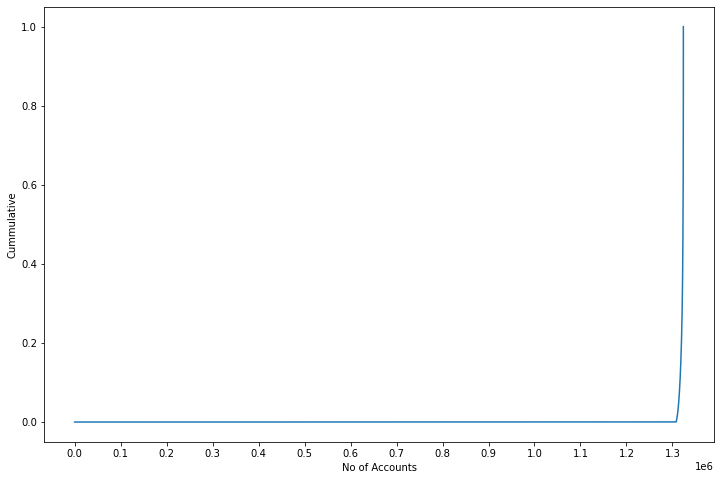

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(range(0,len(unique_cust)),np.cumsum(np.sort(unique_cust['totals.transactionRevenue'])))
plt.xlabel('No of Accounts')
plt.xticks(range(0,len(unique_cust),100000))
plt.ylabel('Cummulative')
plt.show()

###### Out of the 1,323,730 unique accounst in the data set we can see more than 1,300,000 have a spent of 0 which proves the 80-20 rule, in our case more like 98-2

In [ ]:
df = df_train.groupby('fullVisitorId').agg({'date':'count','visitNumber':'count'}).reset_index()
df['More_than_1'] = ['Multiple' if df['date'][i] > 1 else 'Once' for i in range(len(df))]
df['More_than_1'].value_counts(normalize=True)

Once        0.859729
Multiple    0.140271
Name: More_than_1, dtype: float64

##### 85% of our customers have visited us only once

#### Creating some derived varible for better Analysis

In [ ]:
# https://stackoverflow.com/questions/26763344/convert-pandas-column-to-datetime
# https://stackoverflow.com/questions/3682748/converting-unix-timestamp-string-to-readable-date

df_train['date'] = pd.to_datetime(df_train['date'],infer_datetime_format=True,format='%Y%m%d')
time = []
for i in df_train['visitStartTime']:
    time.append(datetime.utcfromtimestamp(i).strftime('%H')) # convert posix time to hour
df_train['Time'] = time
df_train['day'] = df_train['date'].dt.dayofweek #get day of week from date

In [ ]:
# Sorting data by visitorid and date
df_train=df_train.sort_values(by=['fullVisitorId','date']).reset_index().drop(['index'],axis=1)
df_train.head()

channelGrouping       date        fullVisitorId     visitId  visitNumber  \
0  Organic Search 2017-11-28  0000000259678714014  1511914780            2   
1  Organic Search 2017-11-28  0000000259678714014  1511912001            1   
2  Organic Search 2016-10-20  0000010278554503158  1477029466            1   
3  Organic Search 2016-11-30  0000020424342248747  1480578901            1   
4  Organic Search 2017-02-11  0000027376579751715  1486866293            1   

   visitStartTime device.browser device.operatingSystem  device.isMobile  \
0      1511914780         Chrome              Macintosh            False   
1      1511912001         Chrome              Macintosh            False   
2      1477029466         Chrome              Macintosh            False   
3      1480578901         Chrome                Windows            False   
4      1486866293         Chrome              Macintosh            False   

  device.deviceCategory  ... totals.timeOnSite totals.transactions  \
0               desktop  ...              57.0                 0.0   
1               desktop  ...              72.0                 0.0   
2               desktop  ...             194.0                 0.0   
3               desktop  ...             297.0                 0.0   
4               desktop  ...              49.0                 0.0   

  totals.transactionRevenue trafficSource.campaign trafficSource.source  \
0                       0.0              (not set)               google   
1                       0.0              (not set)               google   
2                       0.0              (not set)               google   
3                       0.0              (not set)             (direct)   
4                       0.0              (not set)             (direct)   

  trafficSource.medium trafficSource.keyword  trafficSource.referralPath  \
0              organic                 other                        miss   
1              organic                 other                        miss   
2              organic                 other                        miss   
3               (none)                 other                        miss   
4               (none)                 other                        miss   

   Time  day  
0    00    1  
1    23    1  
2    05    3  
3    07    2  
4    02    5  

[5 rows x 30 columns]

In [ ]:
uniq = []
rev = []
a = 'asa'
for i in range(len(df_train)):
    if a != df_train['fullVisitorId'][i]:
        a = df_train['fullVisitorId'][i]
        rev.append(df_train['totals.transactionRevenue'][i])
        uniq.append(1)
    else:
        uniq.append(0)
        rev.append(0)
    
df_train['Unique_Visitor'] = uniq
df_train['Unique_Revenue'] = rev

#### How many Visitors do we have at Day Level?

In [ ]:
date_df = df_train.groupby('date').agg({'fullVisitorId':'count','totals.transactionRevenue':'sum','Unique_Visitor':'sum','Unique_Revenue':'sum'}).reset_index()
date_df.head()

date  fullVisitorId  totals.transactionRevenue  Unique_Visitor  \
0 2016-08-01           1711               6.116060e+09            1569   
1 2016-08-02           2140               1.361190e+09            1884   
2 2016-08-03           2890               0.000000e+00            2502   
3 2016-08-04           3161               1.182890e+09            2771   
4 2016-08-05           2702               5.594260e+09            2295   

   Unique_Revenue  
0    4.167970e+09  
1    1.145580e+09  
2    0.000000e+00  
3    3.016600e+08  
4    4.727990e+09

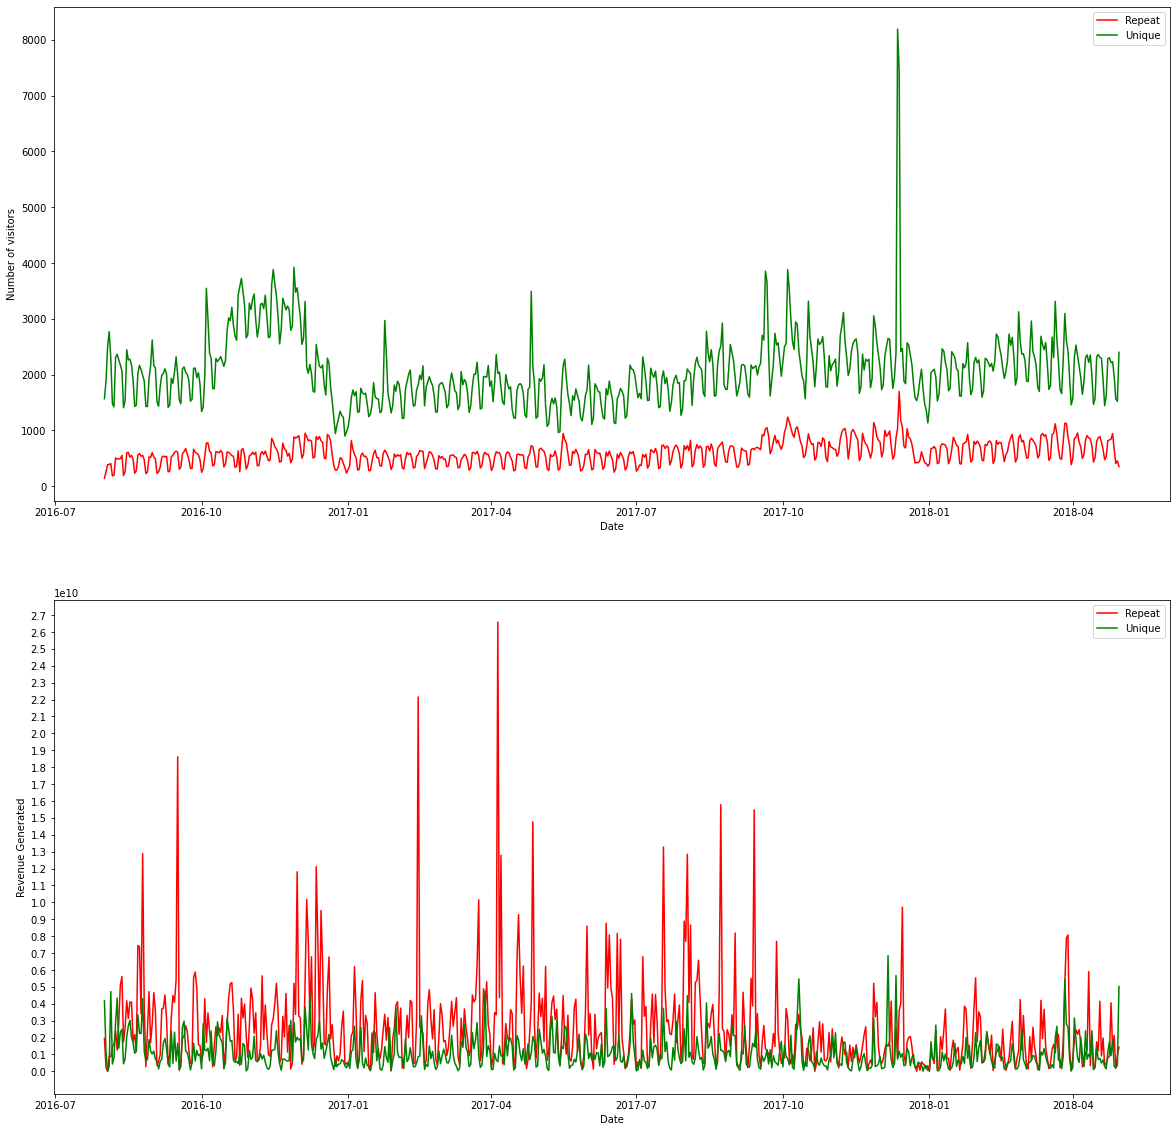

In [ ]:
plt.figure(figsize=(20,20))

plt.subplot(211)
plt.plot(date_df['date'],date_df['fullVisitorId']-date_df['Unique_Visitor'],color='r',label='Repeat')
plt.plot(date_df['date'],date_df['Unique_Visitor'],color='g',label='Unique')
plt.xlabel('Date')
plt.ylabel('Number of visitors')
plt.legend()

plt.subplot(212)
plt.plot(date_df['date'],date_df['totals.transactionRevenue']-date_df['Unique_Revenue'],color='r',label='Repeat')
plt.plot(date_df['date'],date_df['Unique_Revenue'],color='g',label='Unique')
plt.xlabel('Date')
plt.ylabel('Revenue Generated')
plt.yticks(range(0,int(max(date_df['totals.transactionRevenue'])),1000000000))
plt.legend()

plt.show()

##### On an average we have close to 3k visitors everyday out of which 2k are new customers, producing close to 4*1e9 of revenue/day in total out of which 1e9 is produced by the new customers and rest by repeat customers.

#### Looking at other object column and doing basic Cleaning

In [ ]:
browser = df_train.groupby('device.browser').agg({'fullVisitorId':'count','totals.transactionRevenue':'sum','Unique_Visitor':'sum','Unique_Revenue':'sum'}).reset_index()
browser.head()

device.browser  fullVisitorId  \
0                                          (not set)             12   
1                                    +Simple Browser              8   
2                                                  0              7   
3  ;__CT_JOB_ID__:0a075729-93a5-43d0-9638-4cbd41d...              1   
4  ;__CT_JOB_ID__:0b39e7ca-1431-42e3-ba1f-9d8951a...              1   

   totals.transactionRevenue  Unique_Visitor  Unique_Revenue  
0                        0.0              12             0.0  
1                        0.0               7             0.0  
2                        0.0               7             0.0  
3                        0.0               1             0.0  
4                        0.0               1             0.0

Browser column need some cleaning

In [ ]:
l = list(df_train['device.browser'].unique())
d = [len(i) for i in l]
leng = {l[i]:d[i] for i in range(len(l))}
leng

{'Chrome': 6,
 'Safari (in-app)': 15,
 'Safari': 6,
 'Android Webview': 15,
 'Internet Explorer': 17,
 'Opera Mini': 10,
 'Firefox': 7,
 'YaBrowser': 9,
 'Samsung Internet': 16,
 'Edge': 4,
 'Coc Coc': 7,
 'Opera': 5,
 'MRCHROME': 8,
 'UC Browser': 10,
 'Iron': 4,
 'Amazon Silk': 11,
 'Puffin': 6,
 'Nintendo Browser': 16,
 'Mozilla Compatible Agent': 24,
 'Nokia Browser': 13,
 'BlackBerry': 10,
 'Android Browser': 15,
 'SeaMonkey': 9,
 'Maxthon': 7,
 'LYF_LS_4002_11': 14,
 'SAMSUNG-SM-B355E Opera': 22,
 'Playstation Vita Browser': 24,
 'rpfanjzoxyemsgbtichqkudwlv': 26,
 'Nichrome': 8,
 'User Agent': 10,
 'Mozilla': 7,
 '+Simple Browser': 15,
 '(not set)': 9,
 'ThumbSniper': 11,
 'wncrmxukofqljsgvzahiybpdet': 26,
 ';__CT_JOB_ID__:2e0eca60-83ab-482d-bb81-343d113254fb;': 52,
 'Seznam': 6,
 ';__CT_JOB_ID__:76fd1acb-e365-43c0-b967-908bcf5d5b59;': 52,
 'zurcqesbhljxmpwdgnvkoyafit': 26,
 'DESKTOP': 7,
 'Autn-WKOOP': 10,
 'cajrnbtvqwfkolzyxushpdgime': 26,
 'Apple-iPhone7C2': 15,
 'MQQBrowser':

In [ ]:
pipe = []
random = []
for i in df_train['device.browser'].unique():
    if '__CT' in i:
        pipe.append(i)
    if len(i) == 26 and i != 'subjectAgent: NoticiasBoom':
        random.append(i)

df_train['device.browser'].replace(pipe,'Pipeline',inplace=True)
df_train['device.browser'].replace(random,'Random',inplace=True)
df_train['device.browser'].replace(['Amazon Silk','Amazon.com'],'Amazon',inplace=True)
df_train['device.browser'].replace(['Opera Mini','SAMSUNG-SM-B355E Opera'],'Opera',inplace=True)
df_train['device.browser'].replace(['Firefox','Mozilla','Mozilla Compatible Agent'],'Firefox',inplace=True)
df_train['device.browser'].replace('Safari (in-app)','Safari',inplace=True)
df_train['device.browser'].replace('MRCHROME','Chrome',inplace=True)
df_train['device.browser'].replace(['DDG-Android-3.1.1','Android Webview','Android Browser','Android Runtime'],'Android',inplace=True)
df_train['device.browser'].replace(['+Simple Browser','Browser','(not set)','0'],'Others',inplace=True)
df_train['device.browser'].replace(['IE with Chrome Frame','Edge'],'Internet Explorer',inplace=True)

In [ ]:
df_train['device.operatingSystem'].unique()

array(['Macintosh', 'Windows', 'Chrome OS', 'Android', 'iOS', 'Linux',
       '(not set)', 'Windows Phone', 'Samsung', 'Xbox', 'Tizen',
       'Nintendo WiiU', 'BlackBerry', 'Firefox OS', 'Playstation Vita',
       'OS/2', 'Nintendo Wii', 'SunOS', 'Nintendo 3DS', 'FreeBSD',
       'SymbianOS', 'Nokia', 'NTT DoCoMo', 'OpenBSD'], dtype=object)

In [ ]:
df_train['device.operatingSystem'].replace('Windows Phone','Windows',inplace=True)
df_train['device.operatingSystem'].replace(['Nintendo Wii','Nintendo WiiU','Nintendo 3DS','Xbox','Playstation Vita'],'Console',inplace=True)
df_train['device.operatingSystem'].replace(['OpenBSD','FreeBSD'],'BSD',inplace=True)

In [ ]:
df_train['geoNetwork.region'].unique()

array(['California', 'not available in demo dataset', 'Lima Region',
       'Haryana', 'Illinois', 'Istanbul', 'County Dublin', 'Michigan',
       'Ile-de-France', 'Stockholm County', '(not set)', 'Bangkok',
       'Seoul', 'New York', 'Texas', 'Tamil Nadu', 'Buenos Aires',
       'Moscow', 'Hamburg', 'Washington', 'Taipei City', 'Zurich',
       'Berlin', 'Victoria', 'Karnataka', 'Dubai', 'Bogota', 'Hanoi',
       'Lagos', 'Bihar', 'Telangana', 'Rajasthan', 'Dublin City',
       'Jakarta', 'Delhi', 'Lazio', 'Chon Buri', 'State of Sao Paulo',
       'Community of Madrid', 'Western Australia', 'Ontario',
       'Maharashtra', 'Metro Manila', 'Masovian Voivodeship', 'England',
       'British Columbia', 'Lam Djong', 'Ho Chi Minh City',
       'Madhya Pradesh', 'Lesser Poland Voivodeship', 'Vienna',
       'Wisconsin', 'West Bengal', 'Quebec', 'Hordaland', 'Izmir',
       'Tel Aviv District', 'Nakhon Pathom', 'New South Wales',
       'Colorado', 'Nakhon Ratchasima', 'Budapest', 'Georgia'

In [ ]:
df_train['geoNetwork.metro'].unique()

array(['San Francisco-Oakland-San Jose CA',
       'not available in demo dataset', '(not set)', 'Chicago IL',
       'Los Angeles CA', 'Detroit MI', 'New York NY', 'Houston TX',
       'Seattle-Tacoma WA', 'London', 'La Crosse-Eau Claire WI',
       'Denver CO', 'Atlanta GA', 'Boston MA-Manchester NH', 'Austin TX',
       'Dallas-Ft. Worth TX', 'JP_KANTO', 'Washington DC (Hagerstown MD)',
       'Minneapolis-St. Paul MN', 'Indianapolis IN', 'Charlotte NC',
       'Central Scotland', 'Phoenix AZ', 'Milwaukee WI', 'Reno NV',
       'Louisville KY', 'Pittsburgh PA', 'Memphis TN', 'Philadelphia PA',
       'Grand Rapids-Kalamazoo-Battle Creek MI', 'San Diego CA',
       'Kansas City MO', 'JP_KINKI', 'New Orleans LA',
       'Sacramento-Stockton-Modesto CA', 'Columbus OH', 'Portland OR',
       'Meridian (exc. Channel Islands)',
       'Orlando-Daytona Beach-Melbourne FL', 'Panama City FL',
       'Idaho Falls-Pocatello ID', 'Nashville TN', 'Tulsa OK',
       'West Palm Beach-Ft. Pierce FL

In [ ]:
df_train['geoNetwork.city'].unique()

array(['Mountain View', 'not available in demo dataset', 'La Victoria',
       'Oakland', 'Gurgaon', 'Chicago', 'Los Angeles', 'San Francisco',
       'Istanbul', 'Dublin', 'Ann Arbor', 'Vincennes', 'Stockholm',
       '(not set)', 'Bangkok', 'Seoul', 'New York', 'Houston', 'Chennai',
       'San Bruno', 'Buenos Aires', 'Moscow', 'Hamburg', 'Sunnyvale',
       'Kirkland', 'Paris', 'Zurich', 'Berlin', 'Melbourne', 'Bengaluru',
       'Dubai', 'Bogota', 'Hanoi', 'Lagos', 'Patna', 'Hyderabad',
       'Jaipur', 'Jakarta', 'New Delhi', 'Rome', 'Irvine', 'Seattle',
       'Sao Paulo', 'Madrid', 'Perth', 'Toronto', 'Pune', 'Makati',
       'Warsaw', 'Cupertino', 'San Jose', 'London', 'Mumbai', 'Burnaby',
       'Palo Alto', 'Dalat', 'Ho Chi Minh City', 'Indore', 'Krakow',
       'Vienna', 'Eau Claire', 'Kolkata', 'Montreal', 'Bergen', 'Izmir',
       'Tel Aviv-Yafo', 'Nakhon Pathom', 'Sydney', 'Boulder', 'Budapest',
       'Erode', 'Atlanta', 'Boston', 'Singapore', 'Austin', 'Dallas',
       

In [ ]:
df_train['geoNetwork.networkDomain'].unique()

array(['unknown.unknown', '(not set)', 'xtra.co.nz', ..., 'pk.edu.pl',
       'endeavourconnect.com.au', 'probank.gr'], dtype=object)

In [ ]:
df_train['trafficSource.campaign'].unique()

array(['(not set)', 'Data Share Promo',
       '1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS',
       'AW - Dynamic Search Ads Whole Site',
       '1000557 | GA | US | en | Hybrid | GDN Remarketing',
       'Smart Display Campaign', 'AW - Accessories',
       '"google + redesign/Accessories March 17" All Users Similar Audiences',
       'Page: contains "/google+redesign/bags" All Users Similar Audiences',
       'Page: contains "/google+redesign/drinkware" Similar Audiences',
       'Sports & Fitness/Health & Fitness Buffs',
       '"google + redesign/Accessories March 17" All Users',
       'Technology/Technophiles',
       'Page: contains "/google+redesign/office" Similar Audiences',
       'Media & Entertainment/Music Lovers',
       'Media & Entertainment/Movie Lovers', 'Value Shoppers Affinity',
       'Run of Network Line Item',
       'Page: contains "/google+redesign/electronics"',
       'Page: contains "/google+redesign/drinkware"', '(direct)',
       'Lifestyles & 

In [ ]:
df_train['trafficSource.medium'].unique()

array(['organic', '(none)', 'referral', 'affiliate', 'cpc', 'cpm',
       '(not set)'], dtype=object)

In [ ]:
df_train['geoNetwork.region'].replace(['not available in demo dataset','(not set)'],'NA',inplace=True)
df_train['geoNetwork.metro'].replace(['not available in demo dataset','(not set)'],'NA',inplace=True)
df_train['geoNetwork.city'].replace(['not available in demo dataset','(not set)'],'NA',inplace=True)
df_train['geoNetwork.networkDomain'].replace(['unknown.unknown','(not set)'],'NA',inplace=True)
df_train['trafficSource.campaign'].replace(['not available in demo dataset','(not set)'],'NA',inplace=True)
df_train['trafficSource.medium'].replace(['(none)','(not set)'],'NA',inplace=True)

<b>Hits and Pageview seem to be very much correlated, timeonsite is a little correlated with pageviews and hits</b>

#### Creating some basic function for Univariate Analysis

In [ ]:
def graph(df,col,lab,ax,uni=False):
    ax2 = ax.twinx()
    df[col] = df[col].astype(str)
    if uni:
        df = df.sort_values(by=['Unique_Visitor','Unique_Revenue']).reset_index().drop(['index'],axis=1)
        ax.bar(df[col],(df['Unique_Visitor']*100)/sum(df['Unique_Visitor']),color='g',label='Unique Visitors')
        ax2.plot(df[col],(df['Unique_Revenue']*100)/sum(df['Unique_Revenue']),color='b',label='Revenue')
    else:
        df = df.sort_values(by=['Repeat_Cust','Repeat_Rev']).reset_index().drop(['index'],axis=1)
        ax.bar(df[col],(df['Repeat_Cust']*100)/sum(df['Repeat_Cust']),color='k',label='Repeat Visitors')
        ax2.plot(df[col],(df['Repeat_Rev']*100)/sum(df['Repeat_Rev']),color='r',label='Revenue')
        
    ax.set_xlabel(lab,labelpad=0.2)
    for tick in ax.get_xticklabels():
        tick.set_rotation(10)
    
    ax.set_ylabel('%Visitors')
    ax2.set_ylabel('%Revenue')
    ax.legend(loc ='upper center')
    ax2.legend()
    
    return ax
    
def group(df,col):
    if len(df[col].unique()) > 10:
        df1=df.copy()
        df1[col] = df[col].replace(list(dict(df[col].value_counts()).keys())[10:],'Combined Others')
        df_group = df1.groupby(col).agg({'fullVisitorId':'count','totals.transactionRevenue':'sum','Unique_Visitor':'sum','Unique_Revenue':'sum'}).reset_index()
    else:
        df_group = df.groupby(col).agg({'fullVisitorId':'count','totals.transactionRevenue':'sum','Unique_Visitor':'sum','Unique_Revenue':'sum'}).reset_index()
    
    df_group['Repeat_Cust'] = df_group['fullVisitorId']-df_group['Unique_Visitor']
    df_group['Repeat_Rev'] = df_group['totals.transactionRevenue']-df_group['Unique_Revenue']
    return df_group

In [ ]:
col = ['day','channelGrouping','device.browser','device.operatingSystem','device.deviceCategory','device.isMobile','Time',\
       'geoNetwork.continent','geoNetwork.subContinent','geoNetwork.country', 'geoNetwork.region','geoNetwork.metro', 'geoNetwork.city', \
       'totals.hits', 'totals.pageviews', 'totals.sessionQualityDim','totals.timeOnSite','trafficSource.campaign', \
        'trafficSource.source','trafficSource.medium', 'trafficSource.keyword']

lab = ['Days','Channel','Browser','OS','Device','IsMobile','Hour','Continent','SubContinent','Country','Region','Metro','City','Hits',\
      'PageViews','SessionQuality','TimeSpent','Campaign','Source','Medium','Keyword']

### Unique Customers Analysis

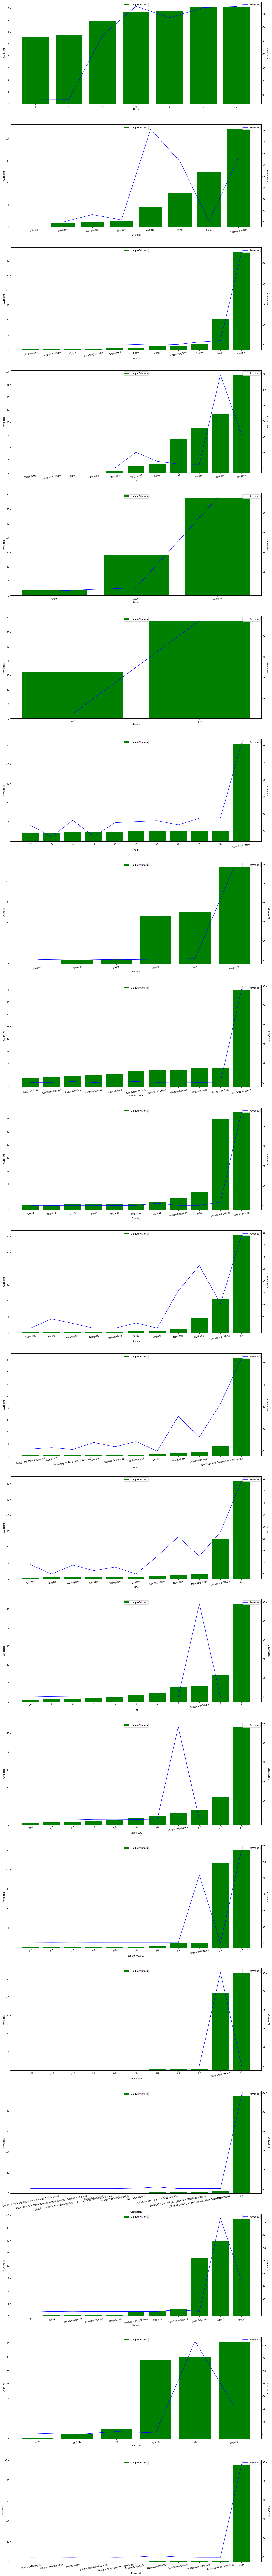

In [ ]:
fig,ax=plt.subplots(nrows=len(col), ncols=1,figsize=(20,len(col)*10))
for i in range(0,len(col)):
    ax[i]=graph(group(df_train,col[i]),col[i],lab[i],ax[i],True)
# plt.suptitle('Unique Customers Stats',fontsize=16)
plt.show()

#### Observations
- We observe most of Customers and Revenue coming from weekdays compared to weekends with most coming from Monday,Tuesday and Wednesday with a combined 49% customers and 57% revenue, for comparison we have 23% customers coming in Saturday and Sunday generating a revenue of 7%
- 45% of our Customers come from Organic Search genrating only 27% of Revenue compared to 8% customers Coming from Referrals generating us 40% revenue. Therefore investing in the referral channel would give us more profits
- 70% of our customers use Chrome Browser generating us 85% of revenue.
- Even though 40% of our customers use Windows Operating system but they generate only ~21% of revenue compared to 23% customer who have Macintosh who generate 40% of our Revenue.
- We have 65% of users coming from Desktop generating 90% of our revenue. We can decrease of investment in ads in apps.
- We get 37.5% of our customer between 1500hrs to 2100hrs generating 49% of revenue
- Close to 45% of our customers are from America more specifically Northern America generating 96% of our Revenue, therefore investing in American Marekting would be very beneficial
- More than 60% of our Customers and 40% Revenue comes from Data with missing Region, Metro and City
- 90% of our customers have their hits between 1 to 9 and generate a revenue of 1 to 2%
- 90% of our customers have their PageViews between 1 to 9 and generate a revenue of 1 to 2%
- 50% of our Customers have a SessionQuality of 0 generating a Revenue of 57%. Customers with SessionQuality between 1-8 are about 40% generating 1% revenue
- 58% of our Customers spend less than 11sec and genrate ~1% revenue
- 90% customers and 95% revnue comes from customers who have not come across any campaigns
- 37% customers come from Google generating 25% revenue compared to 30% customers coming Directly generating 75% revenue
- 37% customers come from Organice Medium generating only 22% revenue compared to 30% customers whose medium is missing generating ~72% revenue

### Repeat Customer Analysis

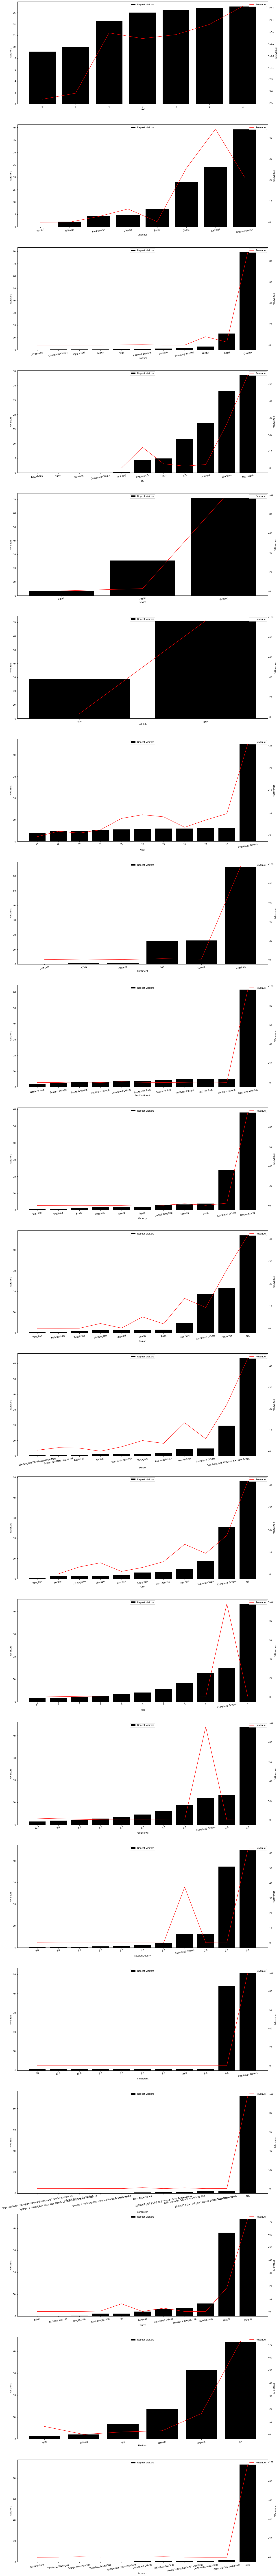

In [ ]:
fig,ax=plt.subplots(nrows=len(col), ncols=1,figsize=(20,len(col)*10))
for i in range(0,len(col)):
    ax[i]=graph(group(df_train,col[i]),col[i],lab[i],ax[i])
plt.show()

#### Observations
- 34% customers Come on Tuesday and Wednesday generating 45.5% revenue.
- 45% Customers from Organic Search genrating 21% of Revenue compared to 25% customers Coming from Referrals generating 45% revenue. Therefore investing in the referral channel would give us more profits
- 80% of our customers use Chrome Browser generating us 85% of revenue.
- 33% of Customers use Macintosh generating 53% of revenue followed by 30% customer using Windows generating 25% Revenue
- We have 70% of users coming from Desktop generating 95% of our revenue 
- We get 41% of our customer between 1500hrs to 2100hrs generating 60% of revenue
- Close to 65% of our customers are from America more specifically Northern America generating 96% of our Revenue, therefore investing in American Marekting would be very beneficial/ Campaigns run in Northern America are a huge success
- More than 50% of our Customers and 40% Revenue comes from Data with missing Region, Metro and City
- 82% of our customers have their hits between 1 to 9 and generate a revenue of 1 to 2%
- 85% of our customers have their PageViews between 1 to 9 and generate a revenue of 1 to 2%
- 45% of our Customers have a SessionQuality of 0 generating a Revenue of 62%. Customers with SessionQuality between 1-8 are about 48% generating 1% revenue
- 48% of our Customers spend less than 11sec and genrate ~1% revenue
- 90% customers and 95% revenue comes from customers who have not come across any campaigns
- 41% customers come from Google generating 20% revenue compared to 45% customers coming Directly generating 72% revenue
- 32% customers come from Organice Medium generating only 18% revenue compared to 45% customers whose medium is missing generating ~72% revenue

#### Do we have any Correalted variables?

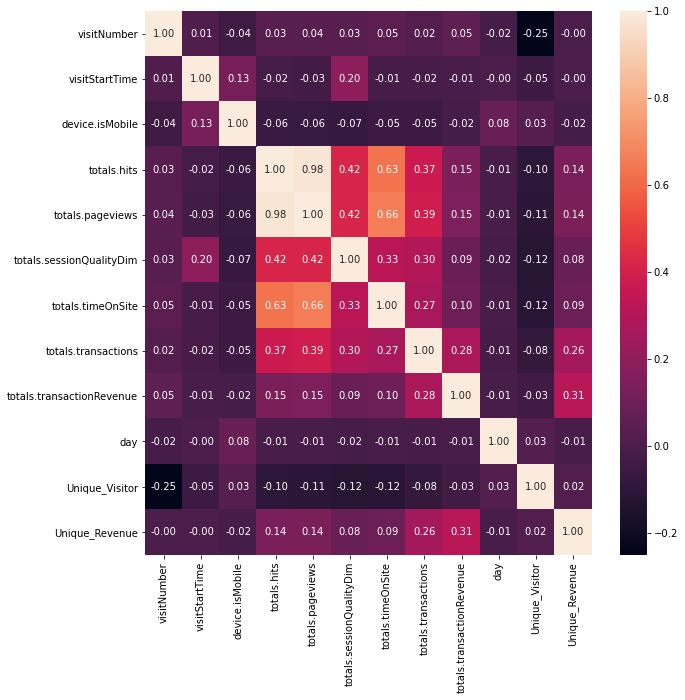

In [ ]:
df = df_train.drop(['visitId'],axis=1).corr()
plt.figure(figsize=(10,10))
sns.heatmap(df,xticklabels=df.columns,yticklabels=df.columns,annot=True,fmt='.2f')
plt.show()

### Multivariate Analysis

In [ ]:
def graph(df,col,lab,ax,c):
    ax2 = ax.twinx()
    df[col] = df[col].astype(str)
    df = df.sort_values(by=['fullVisitorId','totals.transactionRevenue']).reset_index().drop(['index'],axis=1)
    ax.bar(df[col],(df['Unique_Visitor']*100)/sum(df['Unique_Visitor']),color=c[0],label='Unique Visitors')
    ax2.plot(df[col],(df['Unique_Revenue']*100)/sum(df['Unique_Revenue']),color=c[1],label='Unique Revenue')
    
    ax.bar(df[col],(df['Repeat_Cust']*100)/sum(df['Repeat_Cust']),color=c[2],\
           bottom=(df['Unique_Visitor']*100)/sum(df['Unique_Visitor']),label='Repeat Visitors')
    ax2.plot(df[col],(df['Repeat_Rev']*100)/sum(df['Repeat_Rev']),color=c[3],label='Repeat Revenue')
        
    ax.set_xlabel(lab,labelpad=0.2)
    for tick in ax.get_xticklabels():
        tick.set_rotation(10)
    
    ax.set_ylabel('%Visitors')
    ax2.set_ylabel('%Revenue')
    ax.legend(loc ='upper center')
    ax2.legend()
    
    return ax
    
def group(df,col):
    if len(df[col].unique()) > 10:
        df1=df.copy()
        df2 = df1.groupby(col).agg({'totals.transactionRevenue':'sum'}).reset_index()
        df2 = df2.sort_values(by='totals.transactionRevenue',ascending=False).reset_index().drop(['index'],axis=1)
        df1[col] = df[col].replace(list(df2[col])[10:],'Combined Others')
        df_group = df1.groupby(col).agg({'fullVisitorId':'count','totals.transactionRevenue':'sum','Unique_Visitor':'sum','Unique_Revenue':'sum'}).reset_index()
    else:
        df_group = df.groupby(col).agg({'fullVisitorId':'count','totals.transactionRevenue':'sum','Unique_Visitor':'sum','Unique_Revenue':'sum'}).reset_index()
    
    df_group['Repeat_Cust'] = df_group['fullVisitorId']-df_group['Unique_Visitor']
    df_group['Repeat_Rev'] = df_group['totals.transactionRevenue']-df_group['Unique_Revenue']
    return df_group

In [ ]:
df_train['channel-browser'] = df_train['channelGrouping']+'-'+df_train['device.browser']
df_train['channel-os'] = df_train['channelGrouping']+'-'+df_train['device.operatingSystem']
df_train['channel-mob'] = df_train['channelGrouping']+'-'+df_train['device.deviceCategory']
df_train['channel-cont'] = df_train['channelGrouping']+'-'+df_train['geoNetwork.continent']
df_train['channel-hits'] = df_train['channelGrouping']+'-'+df_train['totals.hits'].astype(str)
df_train['channel-page'] = df_train['channelGrouping']+'-'+df_train['totals.pageviews'].astype(str)
df_train['channel-sess'] = df_train['channelGrouping']+'-'+df_train['totals.sessionQualityDim'].astype(str)
df_train['channel-time'] = df_train['channelGrouping']+'-'+df_train['totals.timeOnSite'].astype(str)
df_train['channel-med'] = df_train['channelGrouping']+'-'+df_train['trafficSource.medium']
df_train['channel-time'] = df_train['channelGrouping']+'-'+df_train['Time'].astype(str)
df_train['channel-day'] = df_train['channelGrouping']+'-'+df_train['day'].astype(str)

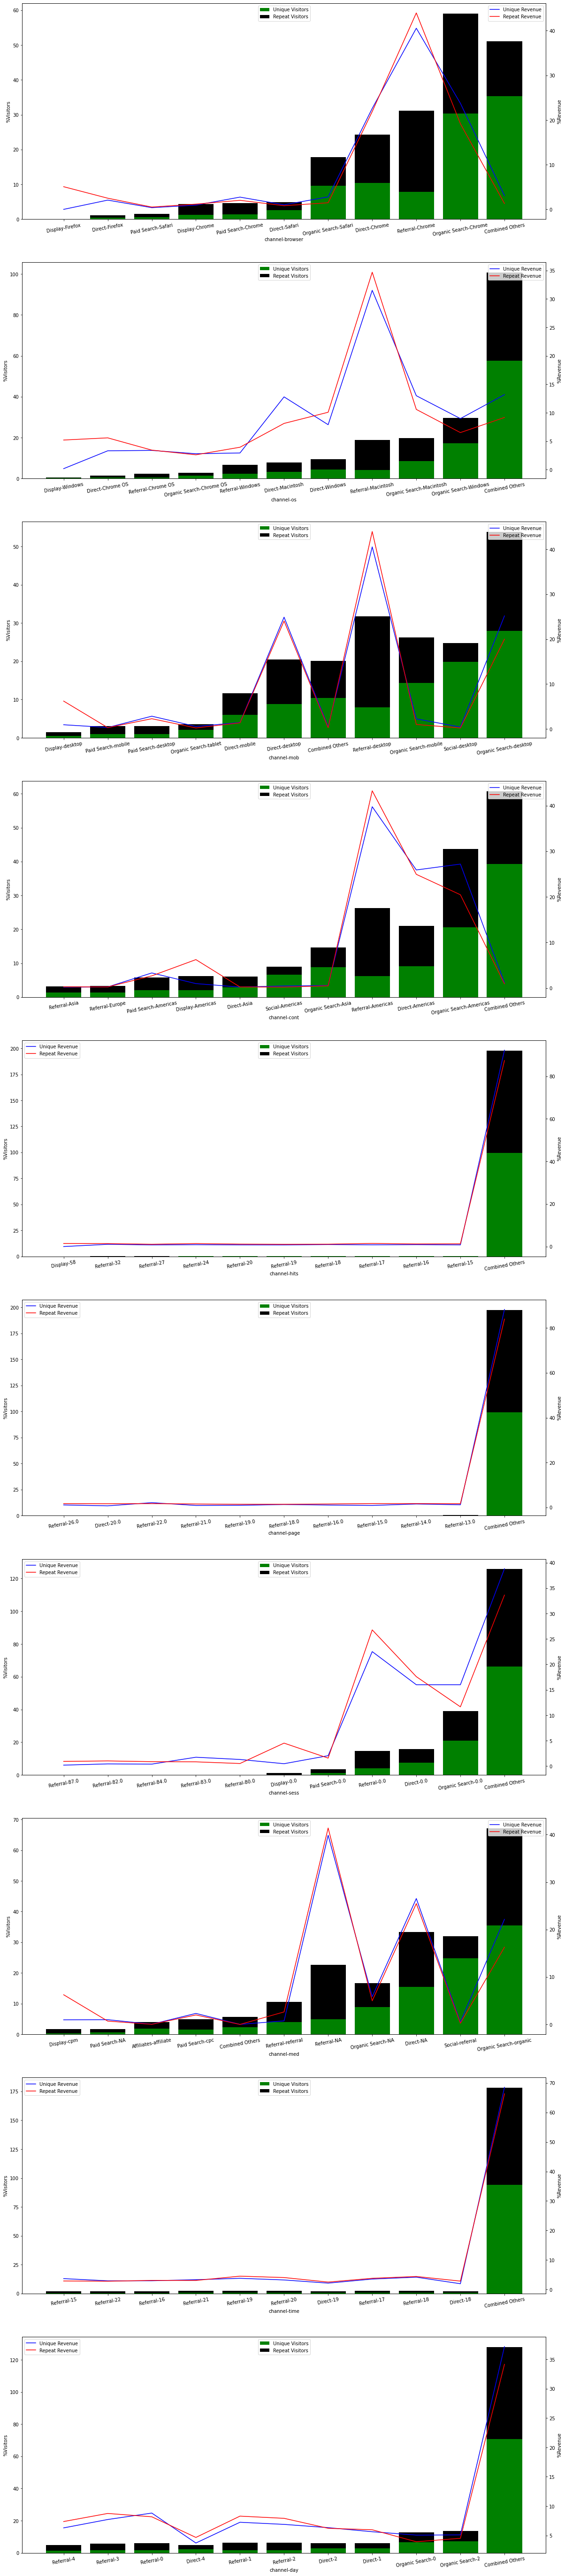

In [ ]:
col=['channel-browser','channel-os','channel-mob','channel-cont','channel-hits','channel-page','channel-sess',\
'channel-med','channel-time','channel-day']

lab=col

fig,ax=plt.subplots(nrows=len(col), ncols=1,figsize=(20,len(col)*10))
for i in range(0,len(col)):
    ax[i]=graph(group(df_train,col[i]),col[i],lab[i],ax[i],['g','b','k','r'])
plt.show()

No combination of columns with Channel is able to differentiate customers who spent vs who did not

In [ ]:
df_train['browser-os'] = df_train['device.browser']+'-'+df_train['device.operatingSystem']
df_train['browser-mob'] = df_train['device.browser']+'-'+df_train['device.deviceCategory']
df_train['browser-cont'] = df_train['device.browser']+'-'+df_train['geoNetwork.continent']
df_train['browser-med'] = df_train['device.browser']+'-'+df_train['trafficSource.medium']
df_train['browser-hits'] = df_train['device.browser']+'-'+df_train['totals.hits'].astype(str)
df_train['browser-page'] = df_train['device.browser']+'-'+df_train['totals.pageviews'].astype(str)
df_train['browser-sess'] = df_train['device.browser']+'-'+df_train['totals.sessionQualityDim'].astype(str)
df_train['browser-time'] = df_train['device.browser']+'-'+df_train['Time'].astype(str)
df_train['browser-day'] = df_train['device.browser']+'-'+df_train['day'].astype(str)

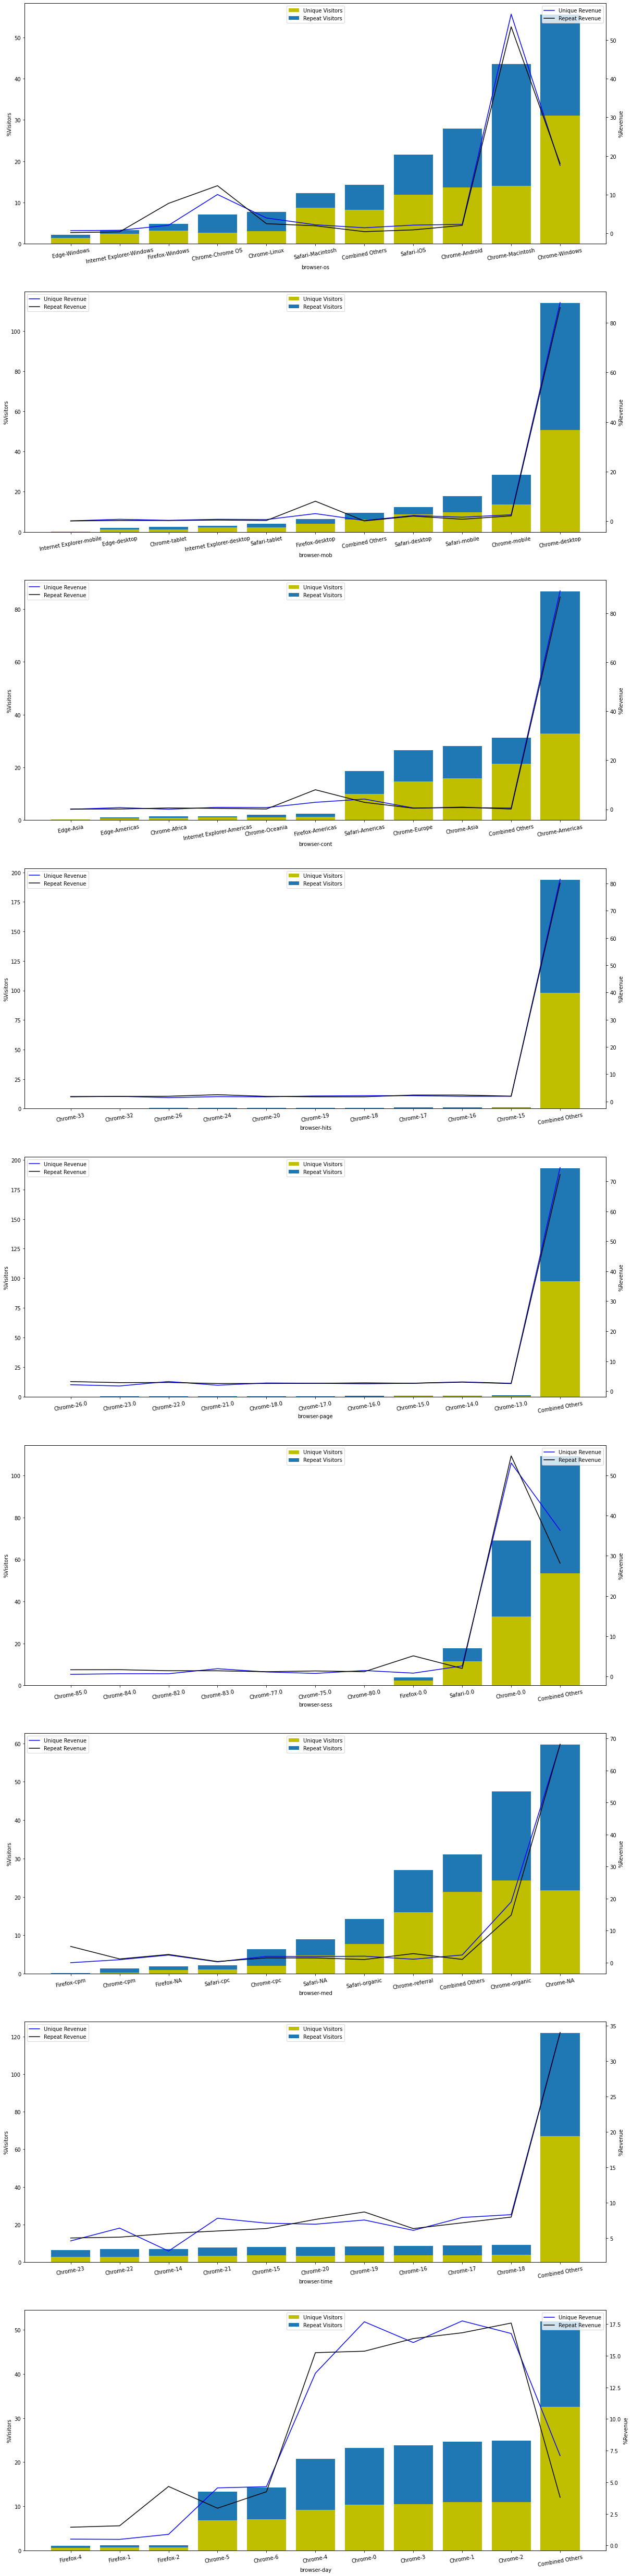

In [ ]:
col=['browser-os','browser-mob','browser-cont','browser-hits','browser-page','browser-sess','browser-med',\
     'browser-time','browser-day']

lab=col

fig,ax=plt.subplots(nrows=len(col), ncols=1,figsize=(20,len(col)*10))
for i in range(0,len(col)):
    ax[i]=graph(group(df_train,col[i]),col[i],lab[i],ax[i],['y','b','C0','k'])
plt.show()

The combination of (Chrome,Desktop),(Chrome,Americas) and (Chrome,NA(Medium)) are contributing to close 80% of revenue and combinations of (Chrome,0(session)),(Chrome,Macintosh) are contibuting to 50% revenue. 

These combinations can be made into new features

In [ ]:
df_train['os-mob'] = df_train['device.operatingSystem']+'-'+df_train['device.deviceCategory']
df_train['os-cont'] = df_train['device.operatingSystem']+'-'+df_train['geoNetwork.continent']
df_train['os-med'] = df_train['device.operatingSystem']+'-'+df_train['trafficSource.medium']
df_train['os-hits'] = df_train['device.operatingSystem']+'-'+df_train['totals.hits'].astype(str)
df_train['os-page'] = df_train['device.operatingSystem']+'-'+df_train['totals.pageviews'].astype(str)
df_train['os-sess'] = df_train['device.operatingSystem']+'-'+df_train['totals.sessionQualityDim'].astype(str)
df_train['os-time'] = df_train['device.operatingSystem']+'-'+df_train['Time'].astype(str)
df_train['os-day'] = df_train['device.operatingSystem']+'-'+df_train['day'].astype(str)

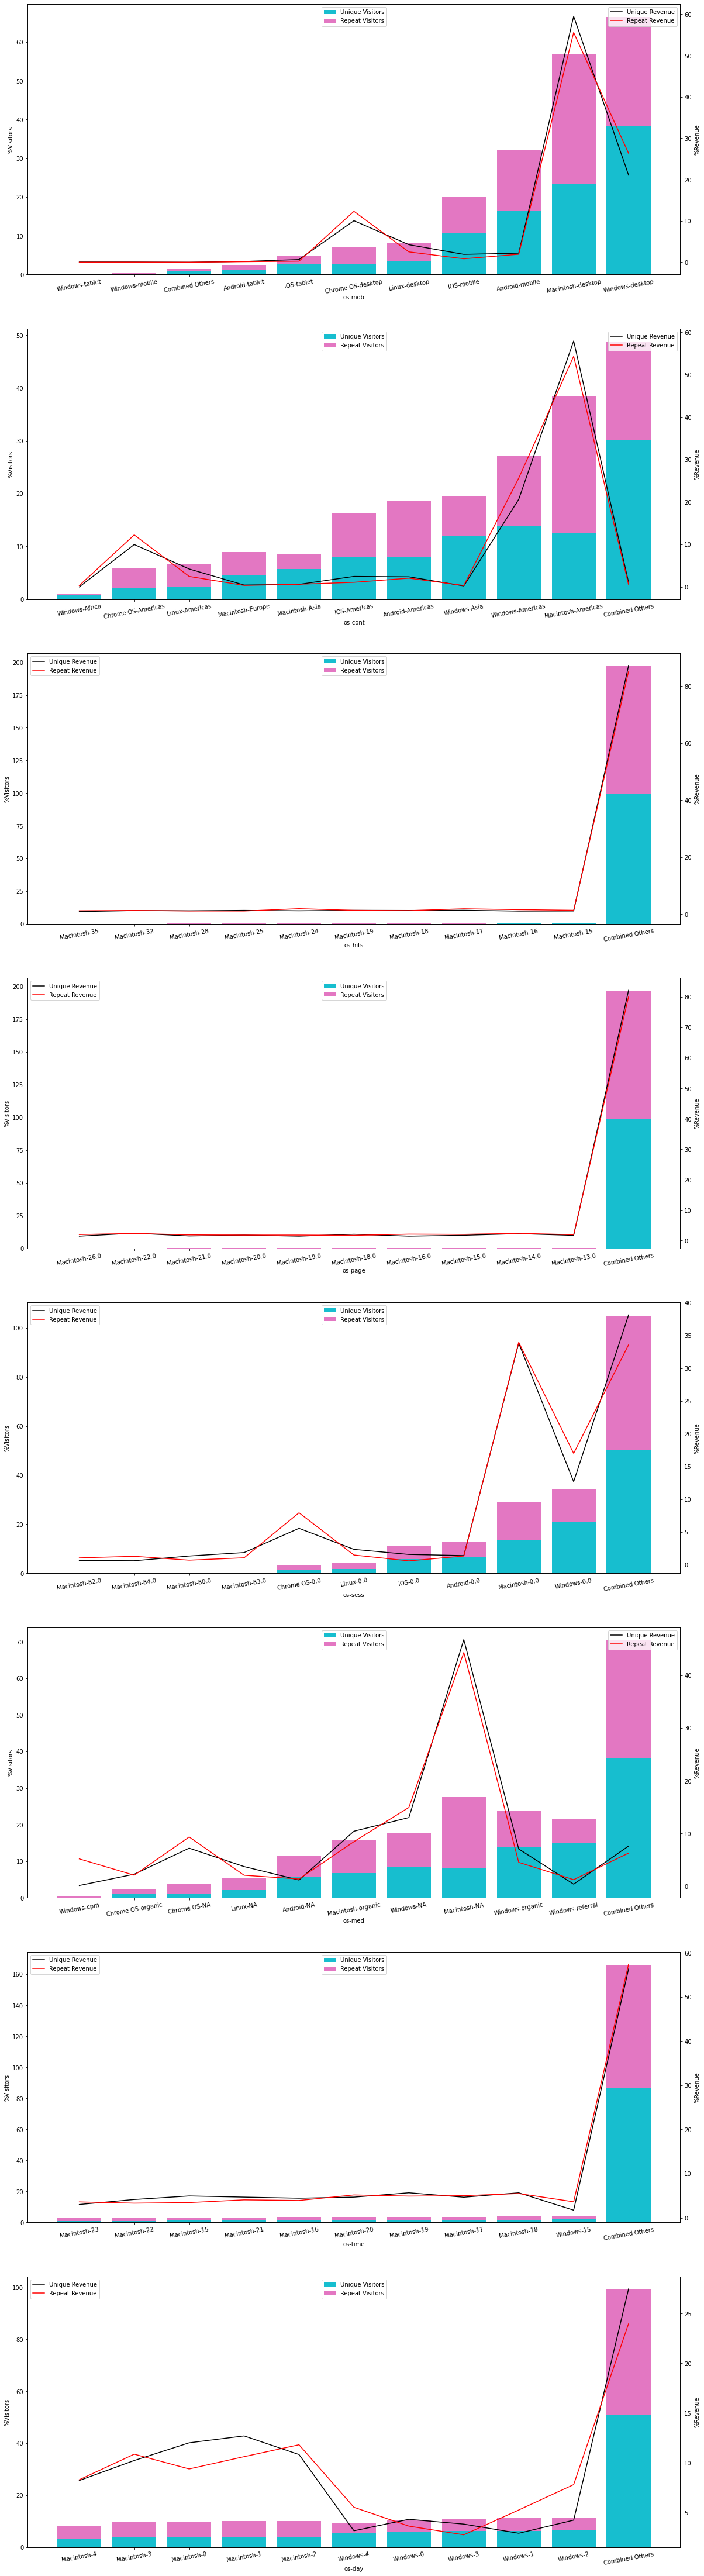

In [ ]:
col=['os-mob','os-cont','os-hits','os-page','os-sess','os-med','os-time','os-day']

lab=col

fig,ax=plt.subplots(nrows=len(col), ncols=1,figsize=(20,len(col)*10))
for i in range(0,len(col)):
    ax[i]=graph(group(df_train,col[i]),col[i],lab[i],ax[i],['tab:cyan','k','tab:pink','r'])
plt.show()

The combination of (Macintosh,Desktop) and (Macintosh,Americas) are contributing to close 60% of revenue and combinations of (Macintosh,NA(medium)) are contibuting to >40% revenue.

These combinations can be made into new features

In [ ]:
df_train['device-cont'] = df_train['device.deviceCategory']+'-'+df_train['geoNetwork.continent']
df_train['device-med'] = df_train['device.deviceCategory']+'-'+df_train['trafficSource.medium']
df_train['device-hits'] = df_train['device.deviceCategory']+'-'+df_train['totals.hits'].astype(str)
df_train['device-page'] = df_train['device.deviceCategory']+'-'+df_train['totals.pageviews'].astype(str)
df_train['device-sess'] = df_train['device.deviceCategory']+'-'+df_train['totals.sessionQualityDim'].astype(str)
df_train['device-time'] = df_train['device.deviceCategory']+'-'+df_train['Time'].astype(str)
df_train['device-day'] = df_train['device.deviceCategory']+'-'+df_train['day'].astype(str)

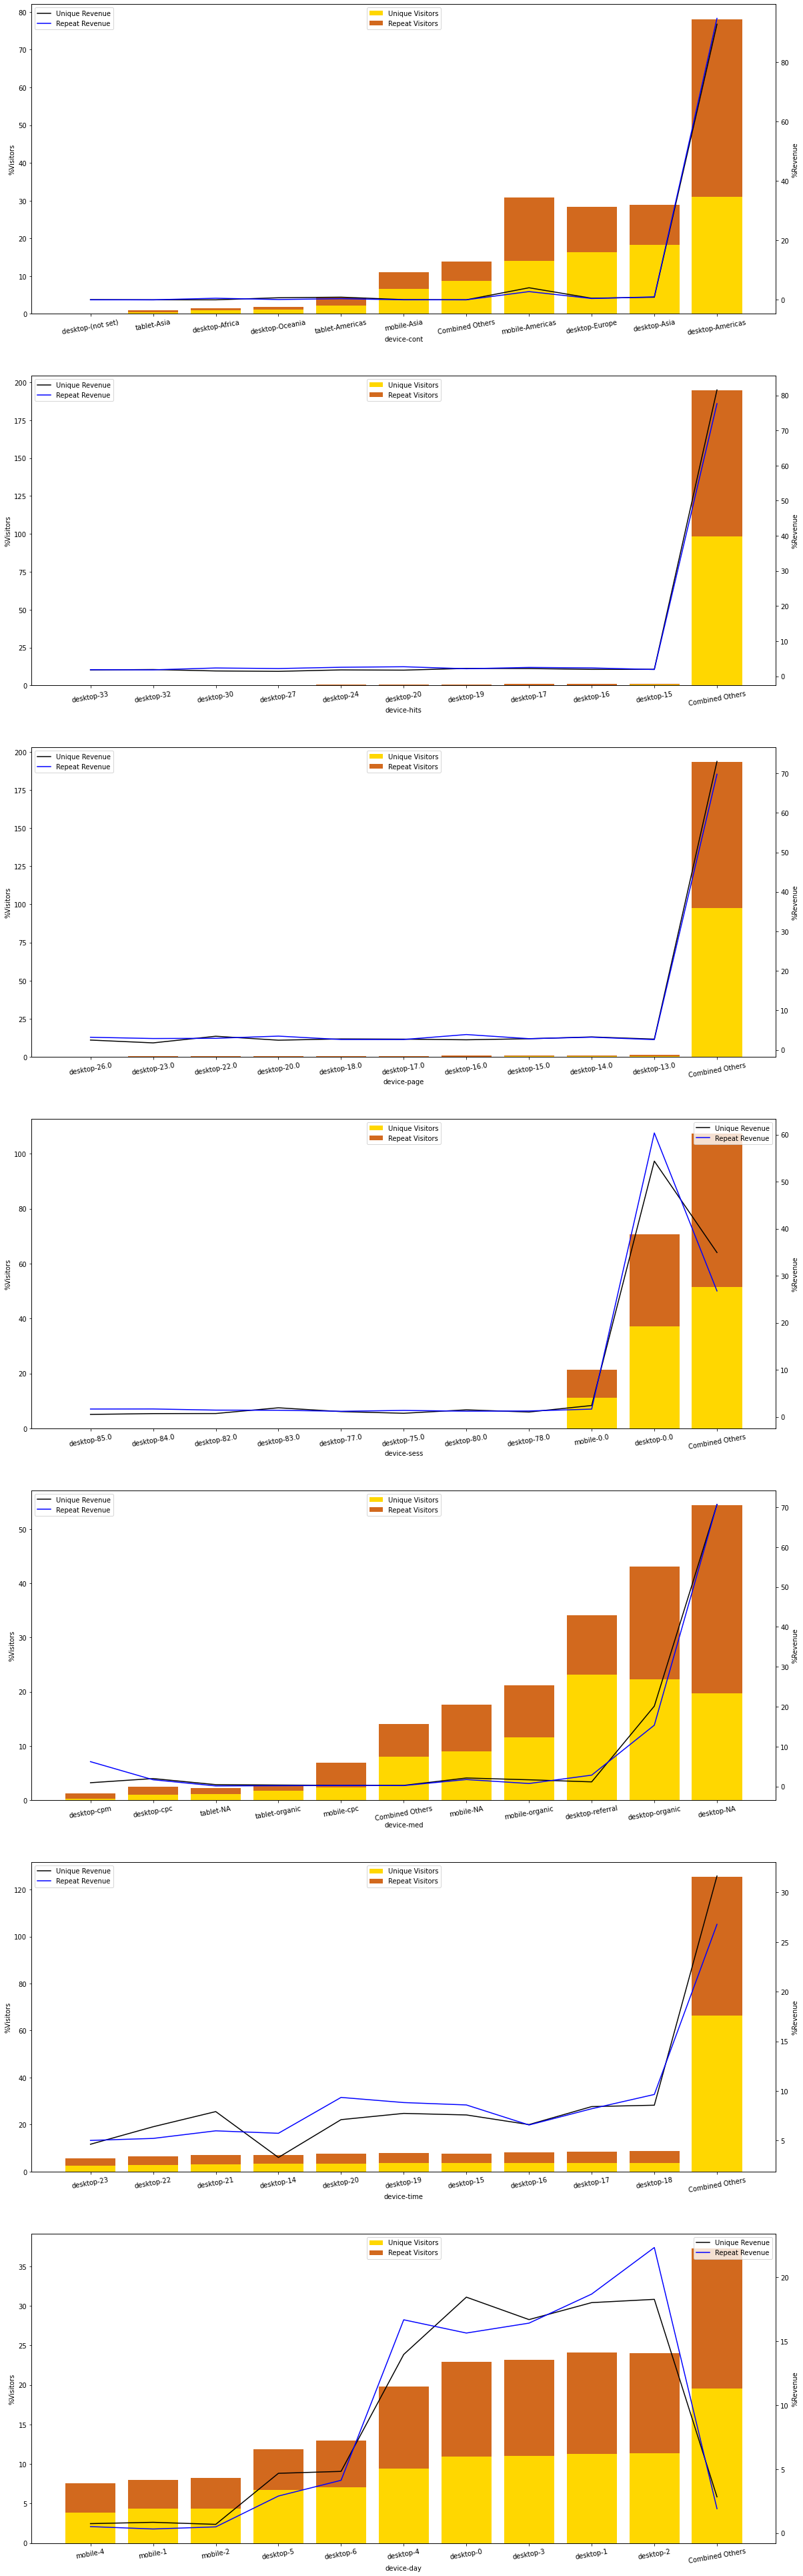

In [ ]:
col=['device-cont','device-hits','device-page','device-sess','device-med','device-time','device-day']

lab=col

fig,ax=plt.subplots(nrows=len(col), ncols=1,figsize=(20,len(col)*10))
for i in range(0,len(col)):
    ax[i]=graph(group(df_train,col[i]),col[i],lab[i],ax[i],['gold','k','chocolate','b'])
plt.show()

The combination of (Desktop,Americas) is contributing to close >80% of revenue and combinations of (Desktop,NA(medium)) and (Desktop,0(session)) are contibuting to >60% revenue.

These combinations can be made into new features

In [ ]:
df_train['cont-med'] = df_train['geoNetwork.continent']+'-'+df_train['trafficSource.medium']
df_train['cont-hits'] = df_train['geoNetwork.continent']+'-'+df_train['totals.hits'].astype(str)
df_train['cont-page'] = df_train['geoNetwork.continent']+'-'+df_train['totals.pageviews'].astype(str)
df_train['cont-sess'] = df_train['geoNetwork.continent']+'-'+df_train['totals.sessionQualityDim'].astype(str)
df_train['cont-time'] = df_train['geoNetwork.continent']+'-'+df_train['Time'].astype(str)
df_train['cont-day'] = df_train['geoNetwork.continent']+'-'+df_train['day'].astype(str)

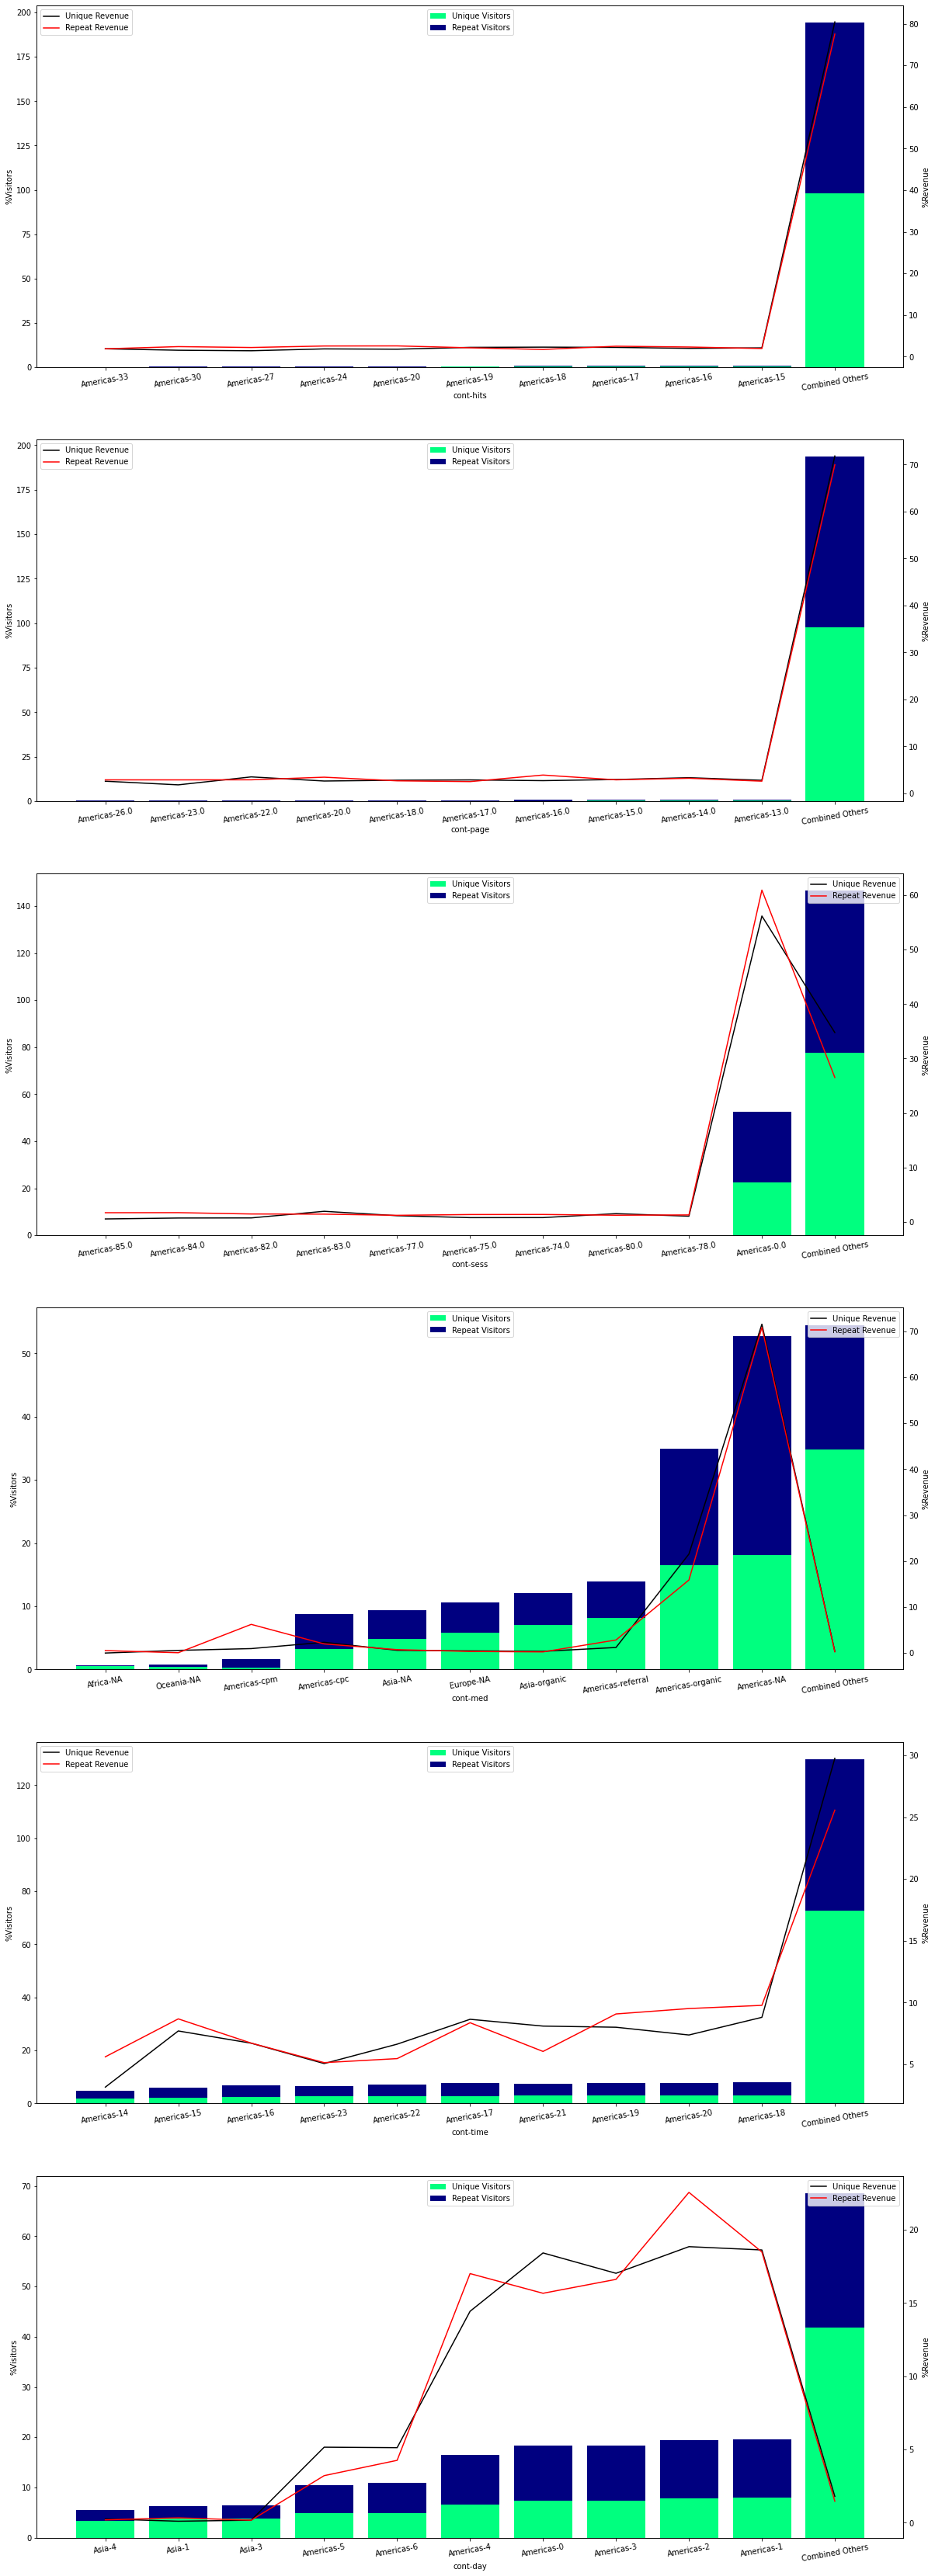

In [ ]:
col=['cont-hits','cont-page','cont-sess','cont-med','cont-time','cont-day']

lab=col

fig,ax=plt.subplots(nrows=len(col), ncols=1,figsize=(20,len(col)*10))
for i in range(0,len(col)):
    ax[i]=graph(group(df_train,col[i]),col[i],lab[i],ax[i],['springgreen','k','navy','r'])
plt.show()

The combination of (Americas,0(session)) and (America,NA(medium)) is contributing to close >70% of revenue.

These combinations can be made into new features

In [ ]:
df_train['hits-med'] = df_train['totals.hits'].astype(str)+'-'+df_train['trafficSource.medium']
df_train['hits-page'] = df_train['totals.hits'].astype(str)+'-'+df_train['totals.pageviews'].astype(str)
df_train['hits-sess'] = df_train['totals.hits'].astype(str)+'-'+df_train['totals.sessionQualityDim'].astype(str)
df_train['hits-time'] = df_train['totals.hits'].astype(str)+'-'+df_train['Time'].astype(str)
df_train['hits-day'] = df_train['totals.hits'].astype(str)+'-'+df_train['day'].astype(str)

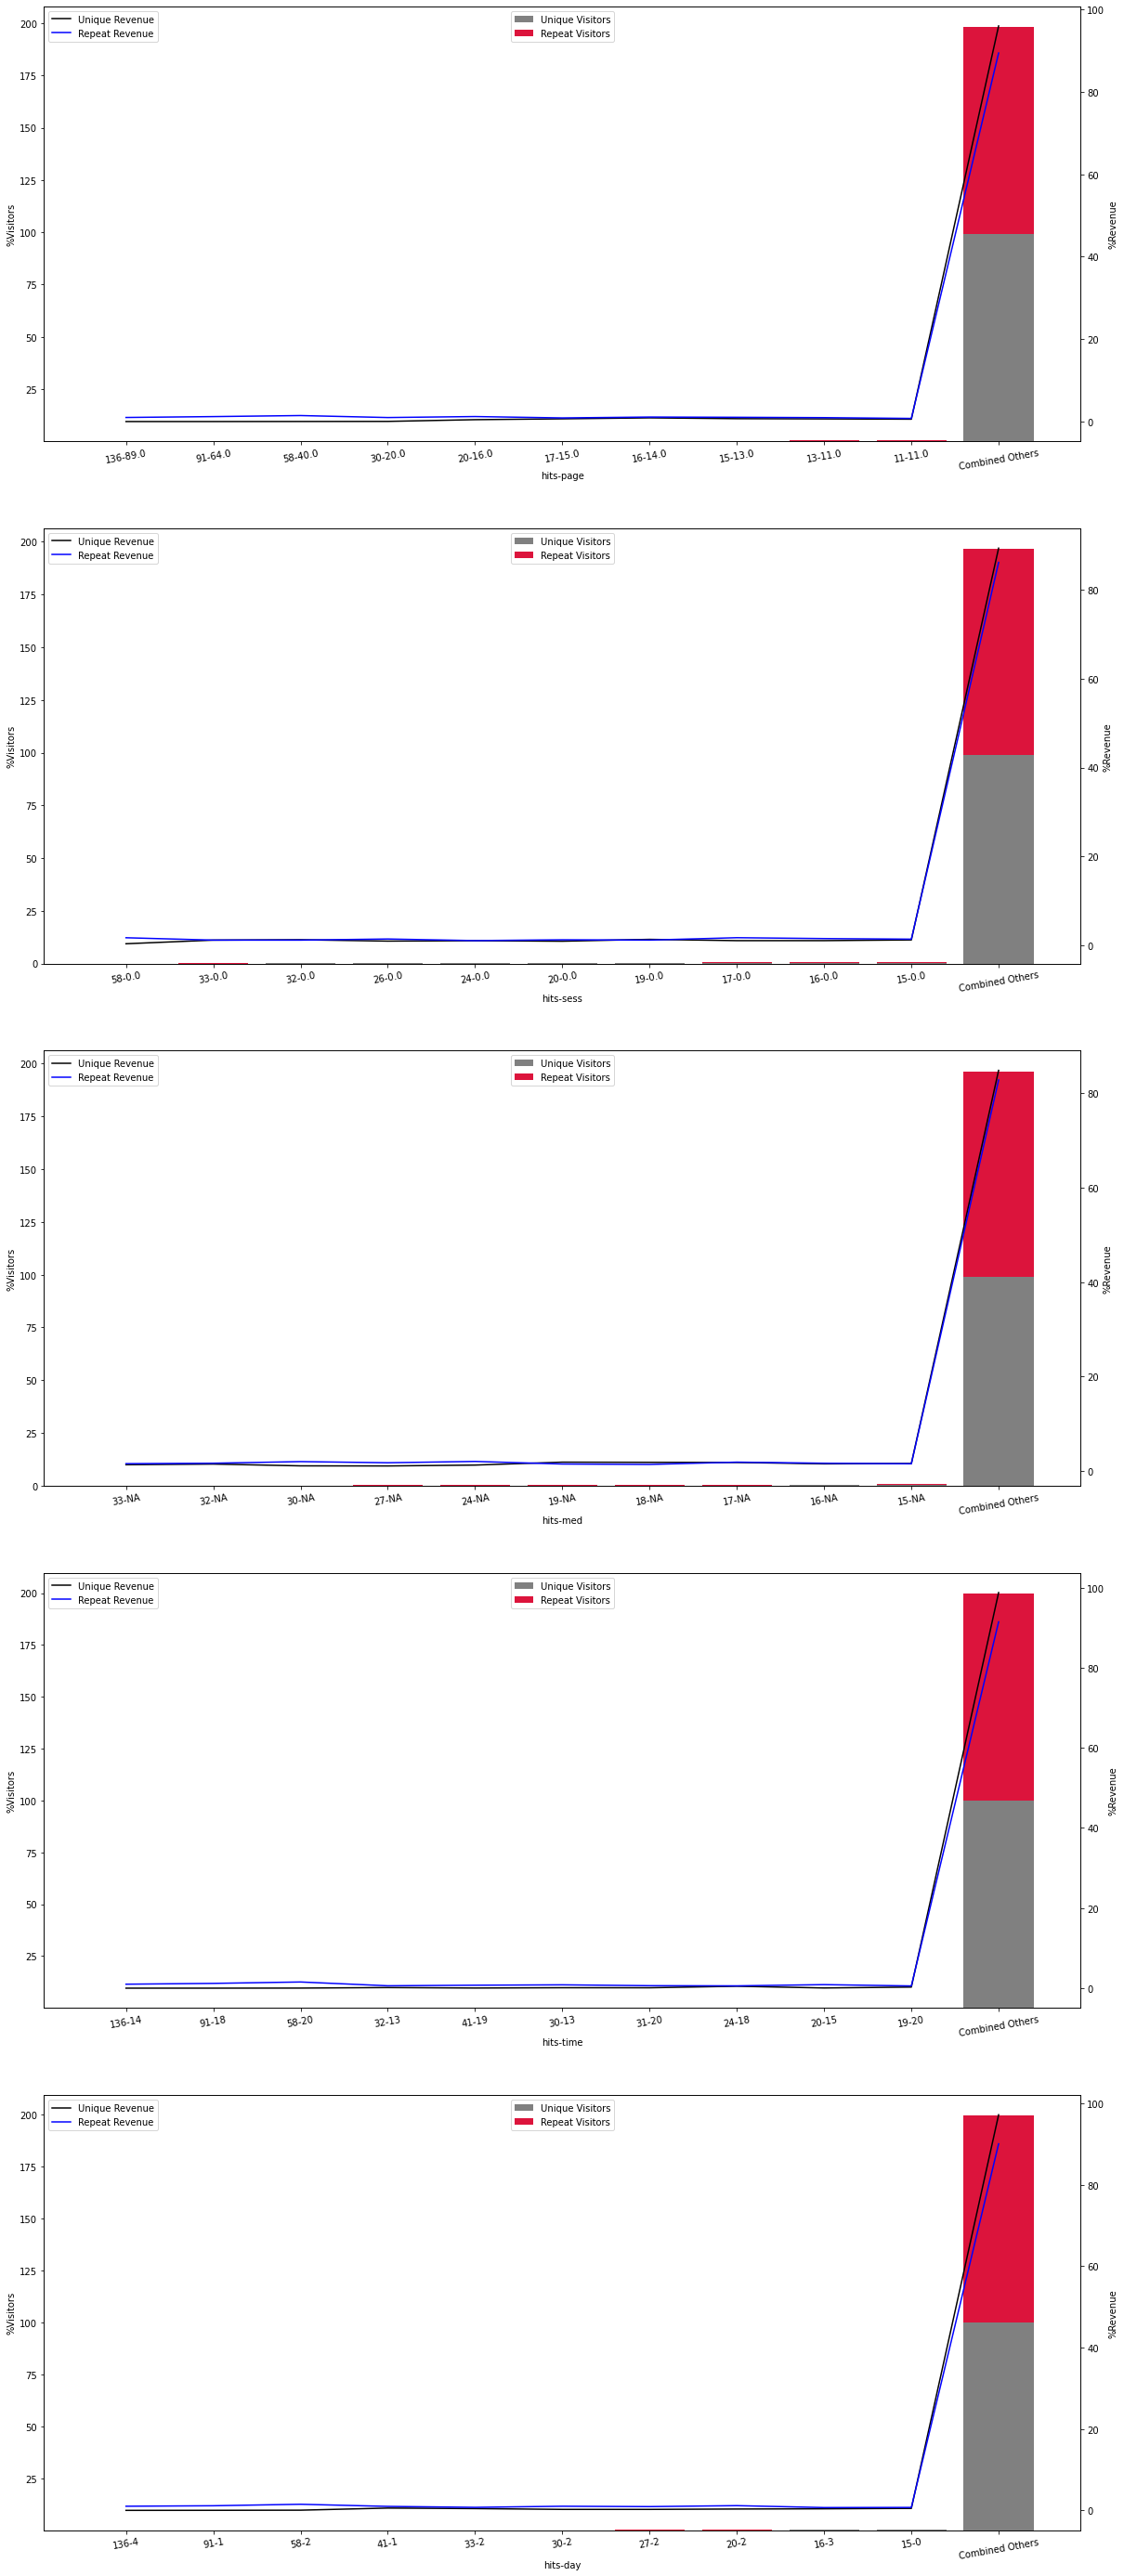

In [ ]:
col=['hits-page','hits-sess','hits-med','hits-time','hits-day']

lab=col

fig,ax=plt.subplots(nrows=len(col), ncols=1,figsize=(20,len(col)*10))
for i in range(0,len(col)):
    ax[i]=graph(group(df_train,col[i]),col[i],lab[i],ax[i],['gray','k','crimson','b'])
plt.show()

No other combination of columns with Hots is able to differentiate customers who spent vs who did not

In [ ]:
df_train['page-med'] = df_train['totals.pageviews'].astype(str)+'-'+df_train['trafficSource.medium']
df_train['page-sess'] = df_train['totals.pageviews'].astype(str)+'-'+df_train['totals.sessionQualityDim'].astype(str)
df_train['page-time'] = df_train['totals.pageviews'].astype(str)+'-'+df_train['Time'].astype(str)
df_train['page-day'] = df_train['totals.pageviews'].astype(str)+'-'+df_train['day'].astype(str)

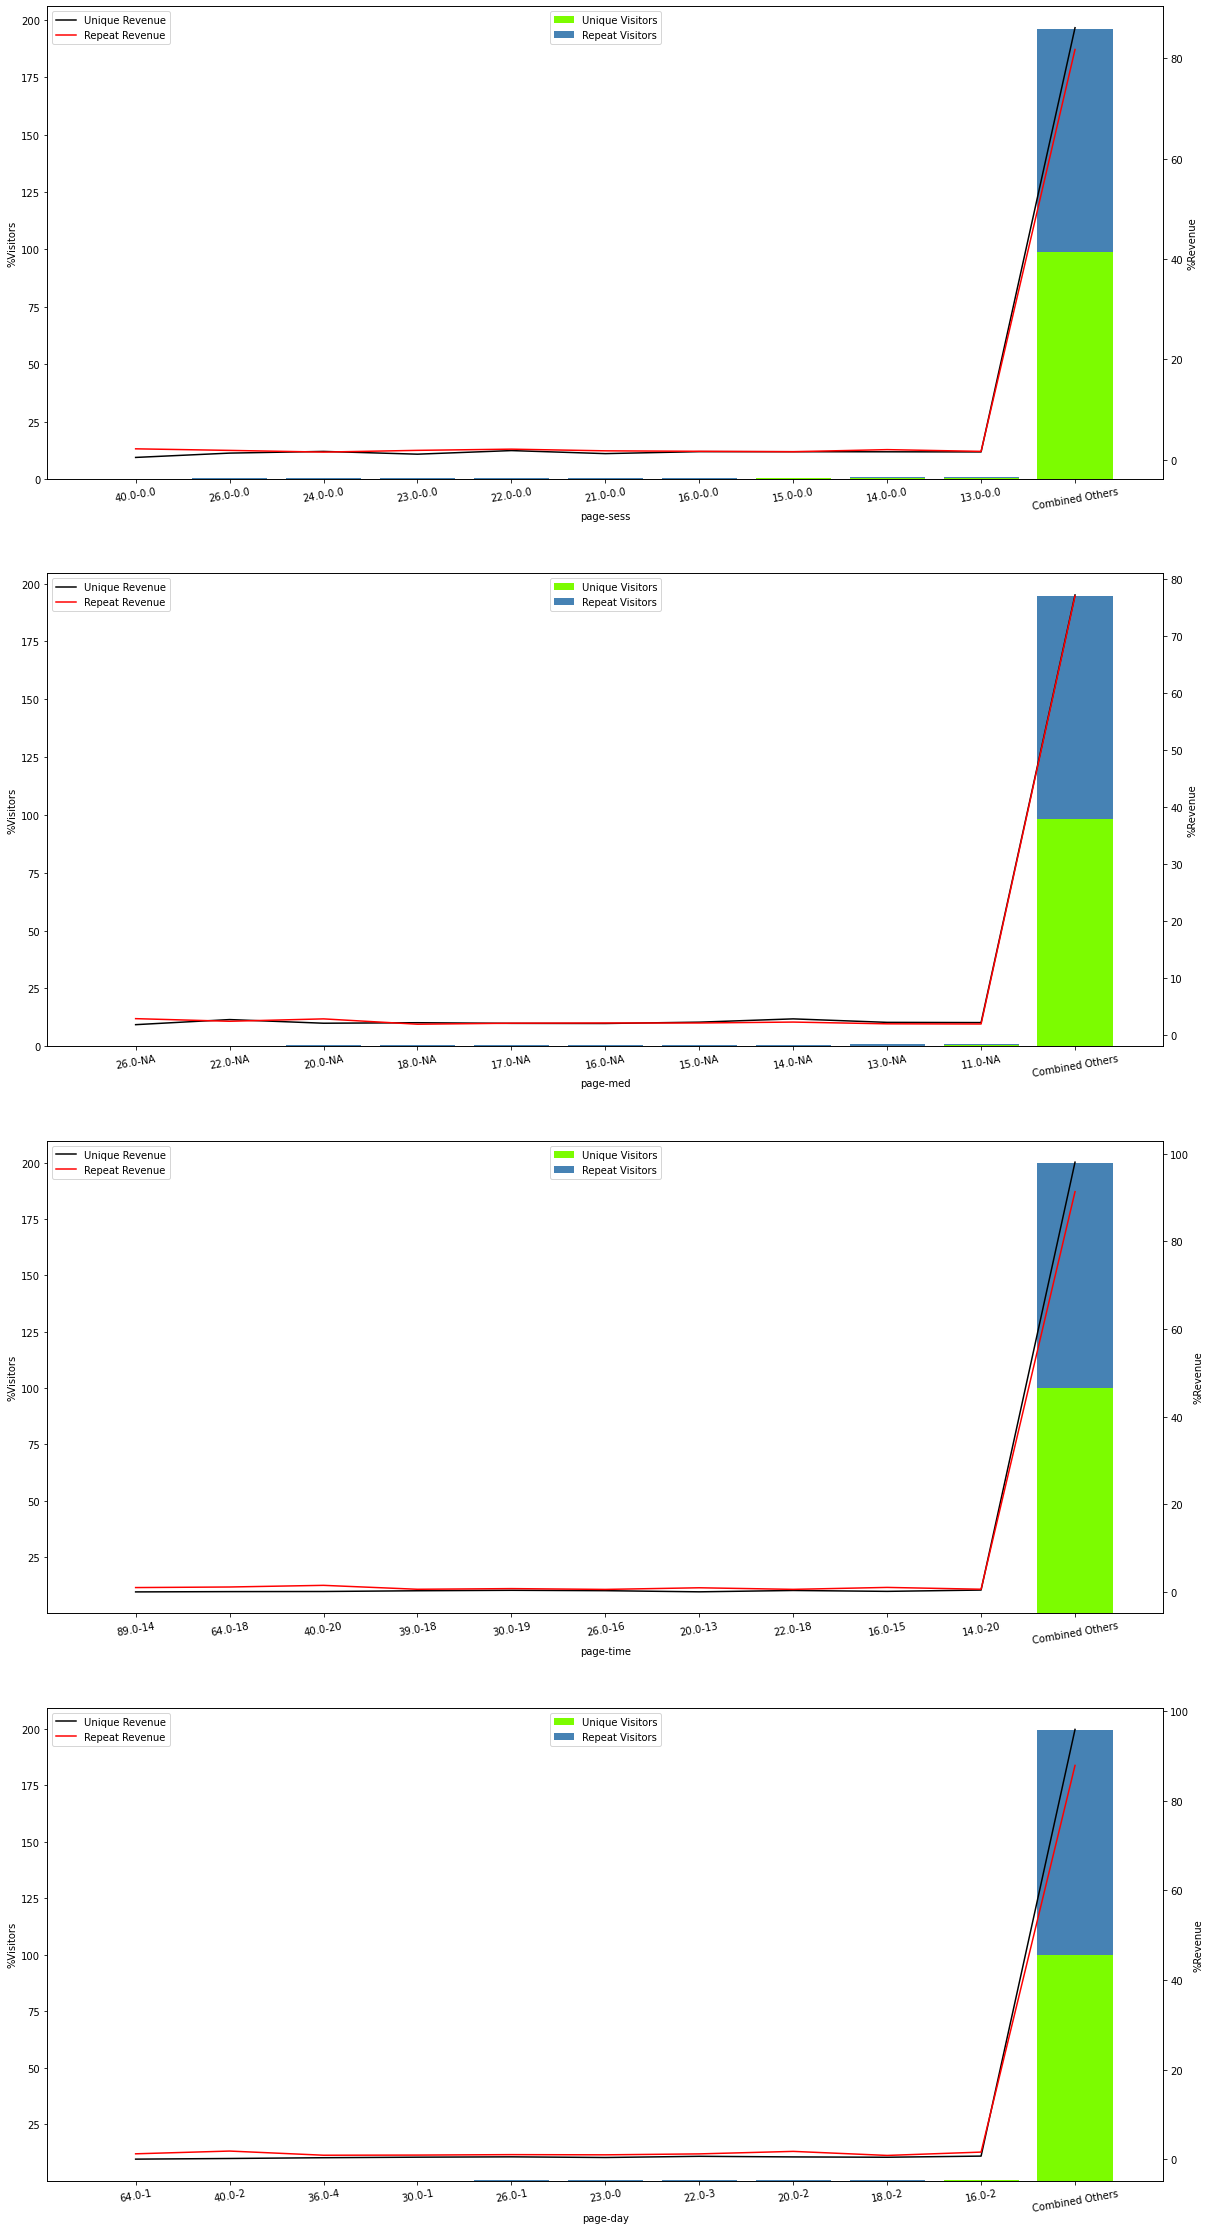

In [ ]:
col=['page-sess','page-med','page-time','page-day']

lab=col

fig,ax=plt.subplots(nrows=len(col), ncols=1,figsize=(20,len(col)*10))
for i in range(0,len(col)):
    ax[i]=graph(group(df_train,col[i]),col[i],lab[i],ax[i],['lawngreen','k','steelblue','r'])
plt.show()

No other combination of columns with PageView is able to differentiate customers who spent vs who did not

In [ ]:
df_train['sess-med'] = df_train['totals.sessionQualityDim'].astype(str)+'-'+df_train['trafficSource.medium']
df_train['sess-time'] = df_train['totals.sessionQualityDim'].astype(str)+'-'+df_train['Time'].astype(str)
df_train['sess-day'] = df_train['totals.sessionQualityDim'].astype(str)+'-'+df_train['day'].astype(str)

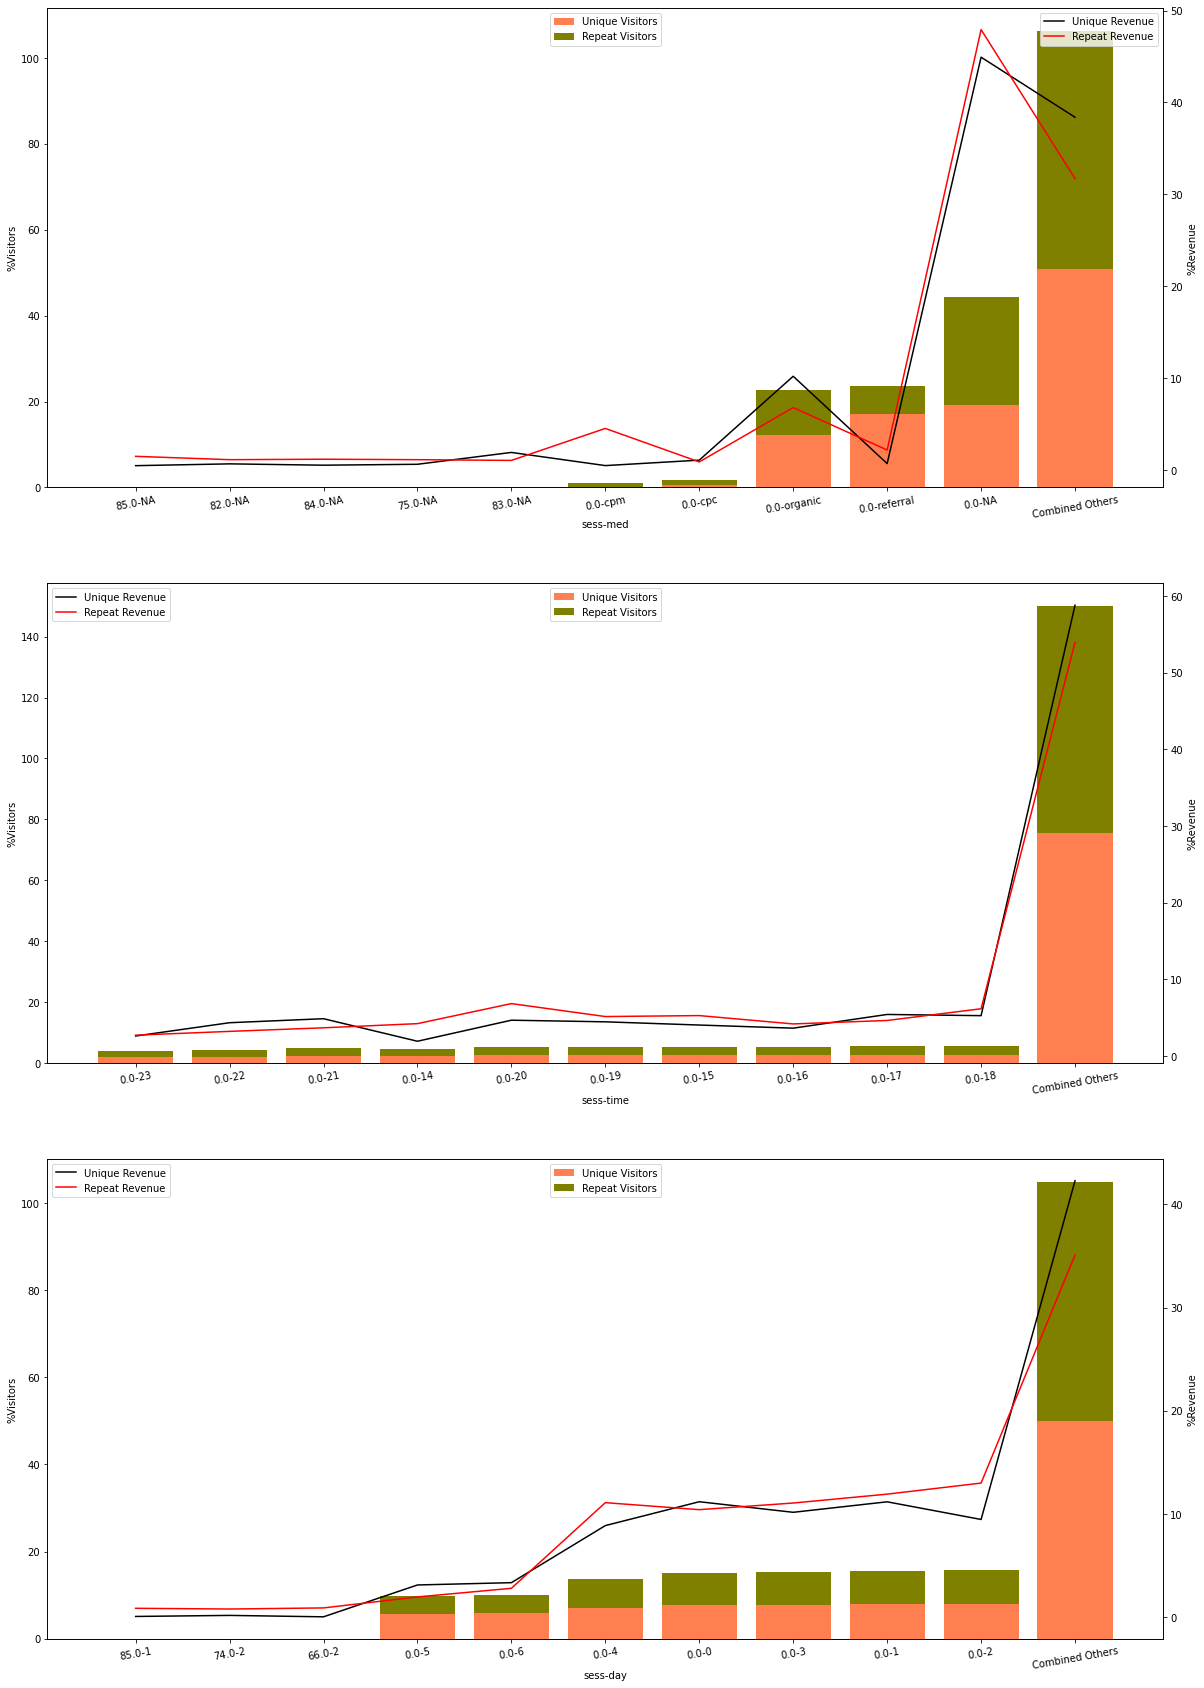

In [ ]:
col=['sess-med','sess-time','sess-day']

lab=col

fig,ax=plt.subplots(nrows=len(col), ncols=1,figsize=(20,len(col)*10))
for i in range(0,len(col)):
    ax[i]=graph(group(df_train,col[i]),col[i],lab[i],ax[i],['coral','k','olive','r'])
plt.show()

No other combination of columns with Session is able to differentiate customers who spent vs who did not

In [ ]:
df_train['time-med'] = df_train['Time'].astype(str)+'-'+df_train['trafficSource.medium']
df_train['time-day'] = df_train['Time'].astype(str)+'-'+df_train['day'].astype(str)

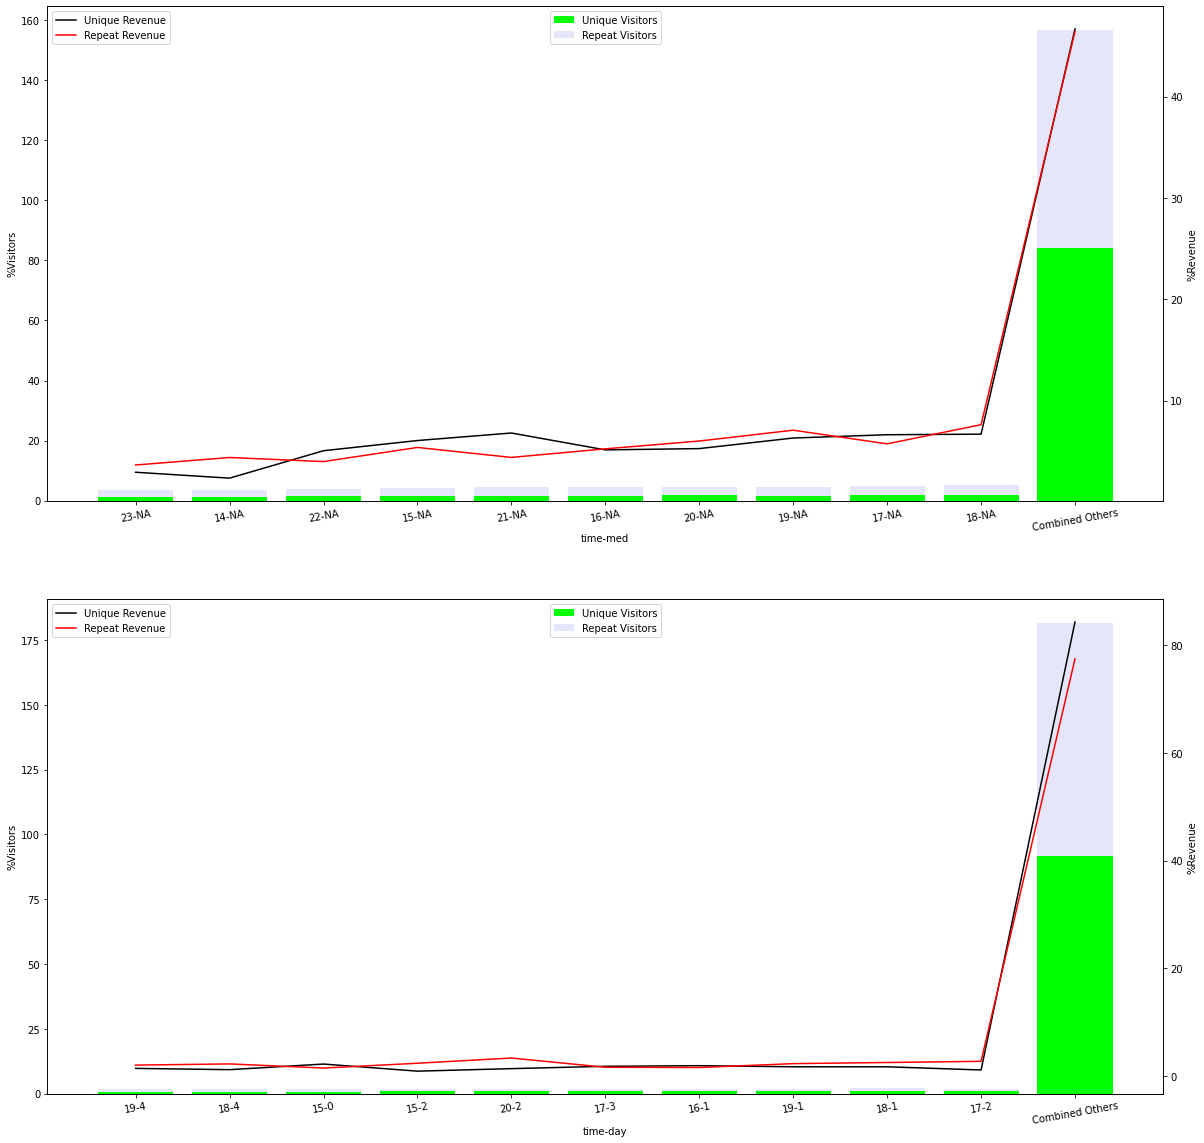

In [ ]:
col=['time-med','time-day']

lab=col

fig,ax=plt.subplots(nrows=len(col), ncols=1,figsize=(20,len(col)*10))
for i in range(0,len(col)):
    ax[i]=graph(group(df_train,col[i]),col[i],lab[i],ax[i],['lime','k','lavender','r'])
plt.show()

No other combination of columns withTime(hour of day) is able to differentiate customers who spent vs who did not

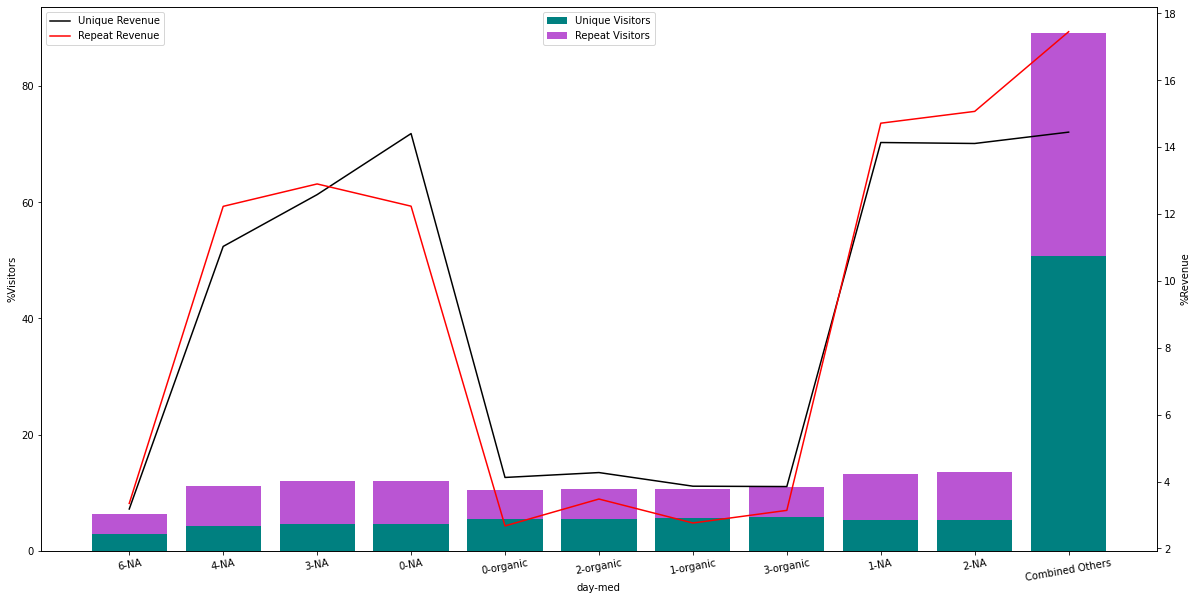

In [ ]:
df_train['day-med'] = df_train['day'].astype(str)+'-'+df_train['trafficSource.medium']
# fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(20,10))
# ax=graph(group(df_rep(df_train,'day-med'),'day-med'),'day-med','day-med',ax,['teal','k','mediumorchid','r'])
# plt.show()
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(20,10))
ax=graph(group(df_train,'day-med'),'day-med','day-med',ax,['teal','k','mediumorchid','r'])
plt.show()

No other combination of columns with day of week is able to differentiate customers who spent vs who did not

### Creating same variables for test dataset

In [ ]:
df_test['date'] = pd.to_datetime(df_test['date'],infer_datetime_format=True,format='%Y%m%d')
time = []
for i in df_test['visitStartTime']:
    time.append(datetime.utcfromtimestamp(i).strftime('%H')) # convert posix time to hour
df_test['Time'] = time
df_test['day'] = df_test['date'].dt.dayofweek #get day of week from date

pipe = []
random = []
for i in df_test['device.browser'].unique():
    if '__CT' in i:
        pipe.append(i)
    if len(i) == 26 and i != 'subjectAgent: NoticiasBoom':
        random.append(i)

df_test['device.browser'].replace(pipe,'Pipeline',inplace=True)
df_test['device.browser'].replace(random,'Random',inplace=True)
df_test['device.browser'].replace(['Amazon Silk','Amazon.com'],'Amazon',inplace=True)
df_test['device.browser'].replace(['Opera Mini','SAMSUNG-SM-B355E Opera'],'Opera',inplace=True)
df_test['device.browser'].replace(['Firefox','Mozilla','Mozilla Compatible Agent'],'Firefox',inplace=True)
df_test['device.browser'].replace('Safari (in-app)','Safari',inplace=True)
df_test['device.browser'].replace('MRCHROME','Chrome',inplace=True)
df_test['device.browser'].replace(['DDG-Android-3.1.1','Android Webview','Android Browser','Android Runtime'],'Android',inplace=True)
df_test['device.browser'].replace(['+Simple Browser','Browser','(not set)','0'],'Others',inplace=True)
df_test['device.browser'].replace(['IE with Chrome Frame','Edge'],'Internet Explorer',inplace=True)

df_test['device.operatingSystem'].replace('Windows Phone','Windows',inplace=True)
df_test['device.operatingSystem'].replace(['Nintendo Wii','Nintendo WiiU','Nintendo 3DS','Xbox','Playstation Vita'],'Console',inplace=True)
df_test['device.operatingSystem'].replace(['OpenBSD','FreeBSD'],'BSD',inplace=True)

df_test['geoNetwork.region'].replace(['not available in demo dataset','(not set)'],'NA',inplace=True)
df_test['geoNetwork.metro'].replace(['not available in demo dataset','(not set)'],'NA',inplace=True)
df_test['geoNetwork.city'].replace(['not available in demo dataset','(not set)'],'NA',inplace=True)
df_test['geoNetwork.networkDomain'].replace(['unknown.unknown','(not set)'],'NA',inplace=True)
df_test['trafficSource.campaign'].replace(['not available in demo dataset','(not set)'],'NA',inplace=True)
df_test['trafficSource.medium'].replace(['(none)','(not set)'],'NA',inplace=True)

In [ ]:
df_train.to_csv('train_v3.csv')
df_test.to_csv('test_v3.csv')

In [ ]:
df_train.shape,df_test.shape

((1708337, 30), (401589, 30))

## Feature Engineering

In [ ]:
import pandas as pd
from tqdm import tqdm
import datetime
import numpy as np

In [ ]:
df_train = pd.read_csv('train_v3.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)
df_test = pd.read_csv('test_v3.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)

In [ ]:
df = pd.DataFrame()
df['column'] = list(df_train.columns)
df['train'] = list(df_train.dtypes)
df['test'] = list(df_test.dtypes)
df

column    train     test
0              channelGrouping   object   object
1                         date   object   object
2                fullVisitorId   object   object
3                      visitId    int64    int64
4                  visitNumber    int64    int64
5               visitStartTime    int64    int64
6               device.browser   object   object
7       device.operatingSystem   object   object
8              device.isMobile     bool     bool
9        device.deviceCategory   object   object
10        geoNetwork.continent   object   object
11     geoNetwork.subContinent   object   object
12          geoNetwork.country   object   object
13           geoNetwork.region   object   object
14            geoNetwork.metro   object   object
15             geoNetwork.city   object   object
16    geoNetwork.networkDomain   object   object
17                 totals.hits    int64    int64
18            totals.pageviews  float64  float64
19    totals.sessionQualityDim  float64  float64
20           totals.timeOnSite  float64    int64
21         totals.transactions  float64  float64
22   totals.transactionRevenue  float64  float64
23      trafficSource.campaign   object   object
24        trafficSource.source   object   object
25        trafficSource.medium   object   object
26       trafficSource.keyword   object   object
27  trafficSource.referralPath   object   object
28                        Time    int64    int64
29                         day    int64    int64

In [ ]:
#converting ints to floats
col = ['visitNumber','visitStartTime','totals.hits','totals.sessionQualityDim','totals.timeOnSite','Time','day']

for i in col:
    df_train[col]=df_train[col].astype('float')
    df_test[col]=df_test[col].astype('float')

In [ ]:
#Column aggregation idea
col_agg = {}
col_fin = ['fullVisitorId']
o_cols = ['fullVisitorId']
n_cols = ['visitId','visitStartTime','totals.transactionRevenue']
for i in df_train.columns:
    if i =='date':
        col_agg[i] = {'max','min'}
        col_fin.append(i+'_max')
        col_fin.append(i+'_min')
    elif i == 'device.isMobile':
        col_agg[i]='max'
        col_fin.append(i+'_max')
    elif i not in o_cols and df_train[i].dtype == 'O':
        col_agg[i]='max'
        col_fin.append(i)
    elif i not in n_cols and df_train[i].dtype == 'int64':
        col_agg[i]={'max','min','mean','sum'}
        col_fin.append(i+'_max')
        col_fin.append(i+'_min')
        col_fin.append(i+'_mean')
        col_fin.append(i+'_sum')
    elif i not in n_cols and df_train[i].dtype == 'float64':
        col_agg[i]={'max','min','mean','sum'}
        col_fin.append(i+'_max')
        col_fin.append(i+'_min')
        col_fin.append(i+'_mean')
        col_fin.append(i+'_sum')
        
print(col_agg)

{'channelGrouping': 'max', 'date': {'max', 'min'}, 'visitNumber': {'mean', 'sum', 'max', 'min'}, 'device.browser': 'max', 'device.operatingSystem': 'max', 'device.isMobile': 'max', 'device.deviceCategory': 'max', 'geoNetwork.continent': 'max', 'geoNetwork.subContinent': 'max', 'geoNetwork.country': 'max', 'geoNetwork.region': 'max', 'geoNetwork.metro': 'max', 'geoNetwork.city': 'max', 'geoNetwork.networkDomain': 'max', 'totals.hits': {'mean', 'sum', 'max', 'min'}, 'totals.pageviews': {'mean', 'sum', 'max', 'min'}, 'totals.sessionQualityDim': {'mean', 'sum', 'max', 'min'}, 'totals.timeOnSite': {'mean', 'sum', 'max', 'min'}, 'totals.transactions': {'mean', 'sum', 'max', 'min'}, 'trafficSource.campaign': 'max', 'trafficSource.source': 'max', 'trafficSource.medium': 'max', 'trafficSource.keyword': 'max', 'trafficSource.referralPath': 'max', 'Time': {'mean', 'sum', 'max', 'min'}, 'day': {'mean', 'sum', 'max', 'min'}}


### Label Encoding the Categorical Data (Idea from winner solution)

In [ ]:
from sklearn.preprocessing import LabelEncoder as label

col = ['date','fullVisitorId']
for i in tqdm(df_train.columns):
    if i not in col and df_train[i].dtype == 'O':
        encode = label()
        encode.fit(list(df_train[i].values)+list(df_test[i].values))
        df_train[i] = encode.transform(list(df_train[i].values))
        df_test[i] = encode.transform(list(df_test[i].values))
        
        np.save('LabelEncoder/'+i+'_class.npy',encode.classes_)
        
# encoder = LabelEncoder()
# encoder.classes_ = numpy.load('.npy')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:51<00:00,  3.72s/it]


In [ ]:
df_train.to_csv('train_label.csv')
df_test.to_csv('test_label.csv')

    Our Train Dataset has data from 1stAug2016 to 30Apr2018 i.e. 638 days f data and our Train Dataset has data from 1stMay2018 to 15Oct2018 i.e. 168 days of data.<br>

    We need to predict the revenue generated by these customers in the period of 1stDec2018 to 31stJan2019 i.e. we have to predict whether the customer is going to spend in the upcoming 62 days where we have a clear 46 days gap between last data point we have to prediction date. We need to replicate this scenario in our dataset before modelling so that model is able to learn correctly.

    Therefore we will keep the train data of 168 days, test data of 62 days with a gap of 46 days between those last date of train to last date of test.
    
    With this in Mind we can come up with following datasets:
    1. Train data from 1stAug2016 to  15thJan2017, Test data from 2ndMar2017 to 3rdMay2017
    2. Train data from 16thJan2017 to  2ndJul2017, Test data from 17thAug2017 to 18thOct2017
    3. Train data from 3rdJul2017 to 17thDec2017, Test data from 1stFeb2018 to 4thApr2018
    4. Train data from 18thDec2017 to 3rdJun2018, Test data from 19thJul2018 to 19thSep2018
    
    For the next dataset we need data from 4thJune2018 to 18thNov2018 which we donrt have.
    
    We would be creating the datasets such that we keep all the independent parameters for the train set and dependent parameter of the testset. We would be creating a column "returned" which implies if the customer present in train is also present in test set which implies we came back after the cooling period of 46days

In [ ]:
def create_dataset(df,train_sdate,train_edate,test_sdate,test_edate,col_agg,col,train=True):
    
    if train:
        train = df.loc[(df['date']>=train_sdate) & (df['date']<=train_edate)].reset_index().drop('index',axis=1)
        test = df.loc[(df['date']>=test_sdate) & (df['date']<=test_edate)].reset_index().drop('index',axis=1)

        train_min = datetime.datetime.strptime(min(train['date']),'%Y-%m-%d')
        train_max = datetime.datetime.strptime(max(train['date']),'%Y-%m-%d')

        ret_cust = test[test['fullVisitorId'].isin(set(train['fullVisitorId']) & set(test['fullVisitorId']))]
        ret_cust_rev = ret_cust.groupby('fullVisitorId').agg({'totals.transactionRevenue':'sum'}).reset_index()
        ret_cust_rev['returned'] = 1

        non_ret = pd.DataFrame()
        non_ret['fullVisitorId'] = list(set(train['fullVisitorId']) - set(test['fullVisitorId']))
        non_ret['totals.transactionRevenue'] = 0.0
        non_ret['returned'] = 0

        df = pd.concat([ret_cust_rev, non_ret], ignore_index=True)

        df_group = train.groupby('fullVisitorId').agg(col_agg).reset_index()
        df_group.columns=col

        df_fin = pd.merge(df_group,df,how='left',left_on='fullVisitorId',right_on='fullVisitorId')

        first = []
        last  = []
        for i in range(0,len(df_fin)):
            x = (datetime.datetime.strptime(df_fin['date_min'][i],'%Y-%m-%d') - train_min).days 
            # number of days between start of session and his first arrival
            first.append(x)

            x = (train_max - datetime.datetime.strptime(df_fin['date_max'][i],'%Y-%m-%d')).days 
            # number of days from last day of period to his last session
            last.append(x)

        df_fin['first_arrival'] = first
        df_fin['last_arrival'] = last

        return df_fin
    else:
        test_min = datetime.datetime.strptime(min(df['date']),'%Y-%m-%d')
        test_max = datetime.datetime.strptime(max(df['date']),'%Y-%m-%d')
        
        df_group = df.groupby('fullVisitorId').agg(col_agg).reset_index()
        df_group.columns=col
        
        first = []
        last  = []
        for i in range(0,len(df_group)):
            x = (datetime.datetime.strptime(df_group['date_min'][i],'%Y-%m-%d') - test_min).days 
            # number of days between start of session and his first arrival
            first.append(x)

            x = (test_max - datetime.datetime.strptime(df_group['date_max'][i],'%Y-%m-%d')).days 
            # number of days from last day of period to his last session
            last.append(x)

        df_group['first_arrival'] = first
        df_group['last_arrival'] = last
        
        return df_group

In [ ]:
df_train_test = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
df_train_test.shape

(2109926, 30)

In [ ]:
%time df1 = create_dataset(df_train_test,'2016-08-01','2017-01-15','2017-03-02','2017-05-03',col_agg,col_fin)

CPU times: user 1min 7s, sys: 1.21 s, total: 1min 8s
Wall time: 1min 8s


In [ ]:
%time df2 = create_dataset(df_train_test,'2017-01-16','2017-07-02','2017-08-17','2017-10-18',col_agg,col_fin)

CPU times: user 51.3 s, sys: 274 ms, total: 51.6 s
Wall time: 51.5 s


In [ ]:
%time df3 = create_dataset(df_train_test,'2017-07-03','2017-12-17','2018-02-01','2018-04-04',col_agg,col_fin)

CPU times: user 1min 9s, sys: 1.08 s, total: 1min 10s
Wall time: 1min 9s


In [ ]:
%time df4 = create_dataset(df_train_test,'2017-12-18','2018-06-03','2018-07-19','2018-09-19',col_agg,col_fin)

CPU times: user 1min 6s, sys: 1.2 s, total: 1min 7s
Wall time: 1min 6s


In [ ]:
df_final = pd.concat([df1,df2,df3,df4], ignore_index=True)
df_final.shape

(1417575, 56)

In [ ]:
df_final.to_csv('label_final.csv')

In [ ]:
df_test = pd.read_csv('test_label.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)
df_test.head()

channelGrouping        date        fullVisitorId     visitId  visitNumber  \
0                4  2018-05-11  7460955084541987166  1526099341          2.0   
1                2  2018-05-11   460252456180441002  1526064483        166.0   
2                4  2018-05-11  3461808543879602873  1526067157          2.0   
3                2  2018-05-11   975129477712150630  1526107551          4.0   
4                4  2018-05-11  8381672768065729990  1526060254          1.0   

   visitStartTime  device.browser  device.operatingSystem  device.isMobile  \
0    1.526099e+09               9                       1             True   
1    1.526064e+09               9                       8            False   
2    1.526067e+09               9                       4            False   
3    1.526108e+09               9                      19             True   
4    1.526060e+09              22                      18             True   

   device.deviceCategory  ...  totals.sessionQualityDim  totals.transactions  \
0                      1  ...                       1.0                  0.0   
1                      0  ...                       1.0                  0.0   
2                      0  ...                       1.0                  0.0   
3                      1  ...                       1.0                  0.0   
4                      2  ...                       1.0                  0.0   

   totals.transactionRevenue  trafficSource.referralPath  \
0                        0.0                           0   
1                        0.0                           0   
2                        0.0                           0   
3                        0.0                           0   
4                        0.0                           0   

   trafficSource.campaign  trafficSource.source  trafficSource.medium  \
0                      41                   117                     4   
1                      41                     0                     3   
2                      41                   117                     4   
3                      41                     0                     3   
4                      41                   117                     4   

   trafficSource.keyword  Time  day  
0                   3205   4.0  4.0  
1                      8  18.0  4.0  
2                   3205  19.0  4.0  
3                      8   6.0  4.0  
4                   3205  17.0  4.0  

[5 rows x 30 columns]

In [ ]:
%time df_te_lb = create_dataset(df_test,0,0,0,0,col_agg,col_fin,False)

Wall time: 54.3 s


In [ ]:
df_te_lb.to_csv('test_label_final.csv')

### Handling Imbalance

In [ ]:
import pandas as pd
import numpy as np
import random

In [ ]:
data = pd.read_csv('label_final.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)
data['totals.transactionRevenue'] = np.log1p(data['totals.transactionRevenue'])
data.head()

fullVisitorId  channelGrouping    date_max    date_min  \
0  0000010278554503158                4  2016-10-20  2016-10-20   
1  0000020424342248747                4  2016-11-30  2016-11-30   
2   000005103959234087                4  2016-08-21  2016-08-21   
3  0000093957001069502                4  2016-09-27  2016-09-27   
4  0000114156543135683                7  2016-08-08  2016-08-08   

   visitNumber_max  visitNumber_min  visitNumber_mean  visitNumber_sum  \
0              1.0              1.0               1.0              1.0   
1              1.0              1.0               1.0              1.0   
2              1.0              1.0               1.0              1.0   
3              1.0              1.0               1.0              1.0   
4              1.0              1.0               1.0              1.0   

   device.browser  device.operatingSystem  ...  Time_mean  Time_sum  day_max  \
0               9                       8  ...        5.0       5.0      3.0   
1               9                      18  ...        7.0       7.0      2.0   
2               9                       1  ...       22.0      22.0      6.0   
3               9                      18  ...       14.0      14.0      1.0   
4              51                       8  ...       10.0      10.0      0.0   

   day_min  day_mean  day_sum  totals.transactionRevenue  returned  \
0      3.0       3.0      3.0                        0.0         0   
1      2.0       2.0      2.0                        0.0         0   
2      6.0       6.0      6.0                        0.0         0   
3      1.0       1.0      1.0                        0.0         0   
4      0.0       0.0      0.0                        0.0         0   

   first_arrival  last_arrival  
0             80            87  
1            121            46  
2             20           147  
3             57           110  
4              7           160  

[5 rows x 56 columns]

In [ ]:
data_ret = data[data['returned']==1]
data_nret = data[data['returned']==0]

a,b = divmod(len(data_nret),len(data_ret)) # returns number of times all rows to multiply(len(data_nret)//len(data_ret)) and 
                                           # number of times 1 row to multiply(len(data_nret)%len(data_ret))
df1 = np.repeat(data_ret.values,a,axis=0)
rows = random.sample(range(0,len(data_ret)),b)
df2 = np.repeat(data_ret.iloc[rows],1,axis=0)

df = pd.DataFrame(np.vstack((df1,df2)),columns=data_ret.columns)
df.shape

(1408691, 56)

In [ ]:
data_fin = data_nret.append(df,ignore_index=True)
data_fin.shape

(2817382, 56)

In [ ]:
data_fin.to_csv('label_bal_fin.csv')

### Modelling

In [ ]:
!pip install xgboost
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.6/173.6 MB 12.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.5 MB/s eta 0:00:0000:0100:01


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import SGDRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier,XGBRegressor
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_csv('label_bal_fin.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)
data = data.sample(frac = 1, random_state=3).reset_index().drop(['index','date_max','date_min'],axis=1)
data.head()

fullVisitorId  channelGrouping  visitNumber_max  visitNumber_min  \
0  4371679763590286482                4              1.0              1.0   
1  7750940405738849850                6              2.0              4.5   
2   233086844142012058                4              1.0              1.5   
3  0126859910514144642                7              1.0              1.0   
4  1083760617263662951                4              1.0              1.0   

   visitNumber_mean  visitNumber_sum  device.browser  device.operatingSystem  \
0               1.0              1.0               9                       4   
1              27.0              7.0               9                       4   
2               3.0              2.0              38                      18   
3               1.0              1.0               9                      18   
4               1.0              1.0               9                      18   

   device.isMobile_max  device.deviceCategory  ...  Time_mean  Time_sum  \
0                False                      0  ...       23.0      23.0   
1                False                      0  ...       72.0      16.0   
2                False                      0  ...       15.0      15.0   
3                False                      0  ...        1.0       1.0   
4                False                      0  ...       13.0      13.0   

   day_max  day_min  day_mean  day_sum  totals.transactionRevenue  returned  \
0      3.0      3.0       3.0      3.0                        0.0         1   
1      0.0      1.0       6.0      2.0                        0.0         1   
2      2.0      4.0       8.0      6.0                        0.0         0   
3      6.0      6.0       6.0      6.0                        0.0         0   
4      2.0      2.0       2.0      2.0                        0.0         0   

   first_arrival  last_arrival  
0             94            73  
1            163           139  
2            160            18  
3            146            21  
4            114            53  

[5 rows x 54 columns]

In [ ]:
df = data.drop_duplicates('fullVisitorId')
len(df[df['returned']==1])

8103

In [ ]:
test_lab = pd.read_csv('test_label_final.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)
test = pd.read_csv('test_v3.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)

test_val = test.groupby('fullVisitorId').agg({'totals.transactionRevenue':'sum'})
test_val['totals.transactionRevenue'] = np.log1p(test_val['totals.transactionRevenue'])

#### Linear Model

In [ ]:
col = ['fullVisitorId','totals.transactionRevenue','returned']
grid = {'C':[10**i for i in range(-5,4)],'penalty':['l2', 'l1']}
lr = LogisticRegression()
search = RandomizedSearchCV(lr,grid,cv=3,verbose=2,n_jobs=-2,random_state=3,scoring='roc_auc')
result = search.fit(data.drop(col,axis=1),data['returned'])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8271228850908536
{'penalty': 'l2', 'C': 0.01}


In [ ]:
# Reffer for scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
grid = {'alpha':[10**i for i in range(-5,4)],'penalty':['l2', 'l1']}

reg_model = SGDRegressor(random_state=3,loss='squared_error')
search = RandomizedSearchCV(reg_model,grid,cv=3,verbose=2,n_jobs=-2,random_state=3,scoring = 'neg_root_mean_squared_error')
# result = search.fit(data.drop(col,axis=1)[data['returned']==1] ,data['totals.transactionRevenue'][data['returned']==1])
result = search.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-6.504354050053705e+16
{'penalty': 'l2', 'alpha': 0.01}


In [ ]:
col_tes = ['fullVisitorId','date_max','date_min']
col = ['fullVisitorId','totals.transactionRevenue','returned']

classification = LogisticRegression(penalty='l2',C=0.01)
reg = SGDRegressor(loss='squared_loss',penalty='l2',alpha=0.01)

classification.fit(data.drop(col,axis=1),data['returned'])
reg.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

class_res = classification.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = reg.predict(test_lab.drop(col_tes, axis=1))

df1 = pd.DataFrame()
df1['fullVisitorId'] = test_lab['fullVisitorId']
df1['PredictedLogRevenue'] = class_res[:,1]*reg_res

val = pd.merge(df,test_val,left_on='fullVisitorId',right_on='fullVisitorId')
print('RMSE: ',np.sqrt(mean_squared_error(val['totals.transactionRevenue'],val['PredictedLogRevenue'])))

RMSE:  2.949197197245644e+16


In [ ]:
df1.to_csv('linear.csv',index=False)

Kaggle Score: 29491971972456600

##### Got Pretty Bad RMSE using Linear Model, Therefore we need More Bigger and Powerful Algorithms.

#### Decision Tree

In [ ]:
col = ['fullVisitorId','totals.transactionRevenue','returned']

grid = {"splitter":["best","random"],
        "max_depth" : [1,3,5,7,9,11,12],
        "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
        "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
        "max_features":["auto","log2","sqrt",None],
        "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] 
       }
dtc = DecisionTreeClassifier()
search = RandomizedSearchCV(dtc,grid,cv=3,verbose=2,n_jobs=-2,random_state=3,scoring='neg_log_loss')
result = search.fit(data.drop(col,axis=1),data['returned'])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-0.5699217868383738
{'splitter': 'best', 'min_weight_fraction_leaf': 0.1, 'min_samples_leaf': 7, 'max_leaf_nodes': 70, 'max_features': 'log2', 'max_depth': 11}


In [ ]:
grid = {"splitter":["best","random"],
        "max_depth" : [1,3,5,7,9,11,12],
        "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
        "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
        "max_features":["auto","log2","sqrt",None],
        "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] 
       }

dtr = DecisionTreeRegressor()

col = ['fullVisitorId','totals.transactionRevenue','returned']

search = RandomizedSearchCV(dtr,grid,cv=3,verbose=1,n_jobs=-2,random_state=3,scoring='neg_root_mean_squared_error')
result = search.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-4.107910235171391
{'splitter': 'best', 'min_weight_fraction_leaf': 0.1, 'min_samples_leaf': 7, 'max_leaf_nodes': 70, 'max_features': 'log2', 'max_depth': 11}


In [ ]:
col_tes = ['fullVisitorId','date_max','date_min']
col = ['fullVisitorId','totals.transactionRevenue','returned']

classification = DecisionTreeClassifier(splitter='best',min_weight_fraction_leaf=0.1,min_samples_leaf=7,max_leaf_nodes=70,
                                        max_features='log2',max_depth=11)
reg = DecisionTreeRegressor(splitter='best',min_weight_fraction_leaf=0.1,min_samples_leaf=7,max_leaf_nodes=70,
                            max_features='log2',max_depth=11)

classification.fit(data.drop(col,axis=1),data['returned'])
reg.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

class_res = classification.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = reg.predict(test_lab.drop(col_tes, axis=1))

class_res = classification.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = reg.predict(test_lab.drop(col_tes, axis=1))
pred=class_res[:,1]*reg_res

df1 = pd.DataFrame()
df1['fullVisitorId'] = test_lab['fullVisitorId']
df1['PredictedLogRevenue'] = pred

val = pd.merge(df1,test_val,left_on='fullVisitorId',right_on='fullVisitorId')
print('RMSE: ',np.sqrt(mean_squared_error(val['totals.transactionRevenue'],val['PredictedLogRevenue'])))

RMSE:  2.0837279689789248


In [ ]:
df1.to_csv('dt.csv',index=False)

Kaggle Score: 0.88654

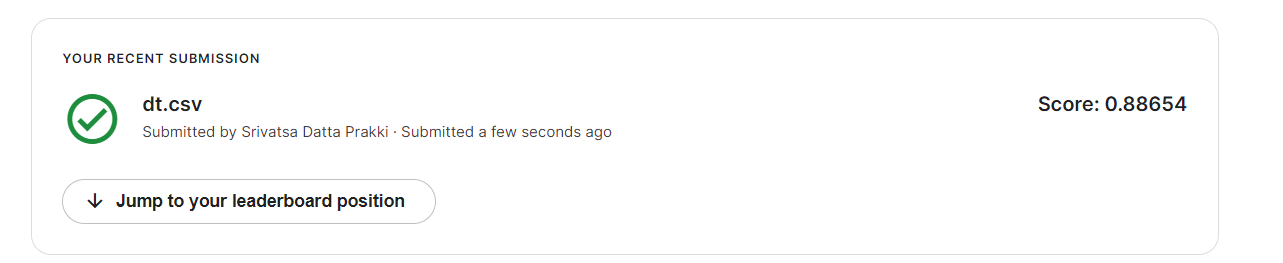

#### Random Forest

In [ ]:
## https://stackoverflow.com/questions/53782169/random-forest-tuning-with-randomizedsearchcv
grid = {'n_estimators':[100,200,300,500,700,800],
        'max_depth':[2,3,5,7,8,9,10],
        'min_samples_split':[2,3,5,7],
        'min_samples_leaf':[1,2,3,4]
       }

rfc = RandomForestClassifier()

col = ['fullVisitorId','totals.transactionRevenue','returned']

search = RandomizedSearchCV(rfc,grid,cv=3,verbose=1,n_jobs=-2,random_state=3,scoring='neg_log_loss')
result = search.fit(data.drop(col,axis=1),data['returned'])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-0.37209458354902053
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}


In [ ]:
grid = {'n_estimators':[100,200,300,500,700,800],
        'max_depth':[2,3,5,7,8,9,10],
        'min_samples_split':[2,3,5,7],
        'min_samples_leaf':[1,2,3,4]
       }

rfr = RandomForestRegressor()

col = ['fullVisitorId','totals.transactionRevenue','returned']

search = RandomizedSearchCV(rfr,grid,cv=3,verbose=1,n_jobs=-2,random_state=3,scoring='neg_root_mean_squared_error')
result = search.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-3.9565696282576277
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}


In [ ]:
col_tes = ['fullVisitorId','date_max','date_min']
col = ['fullVisitorId','totals.transactionRevenue','returned']

classification = RandomForestClassifier(n_estimators=500,min_samples_split=5,min_samples_leaf=2,max_depth=10,n_jobs=-1)
reg = RandomForestRegressor(n_estimators=500,min_samples_split=2,min_samples_leaf=3,max_depth=5,n_jobs=-1)

classification.fit(data.drop(col,axis=1),data['returned'])
reg.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

class_res = classification.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = reg.predict(test_lab.drop(col_tes, axis=1))

class_res = classification.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = reg.predict(test_lab.drop(col_tes, axis=1))
pred=class_res[:,1]*reg_res

df1 = pd.DataFrame()
df1['fullVisitorId'] = test_lab['fullVisitorId']
df1['PredictedLogRevenue'] = pred

val = pd.merge(df1,test_val,left_on='fullVisitorId',right_on='fullVisitorId')
print('RMSE: ',np.sqrt(mean_squared_error(val['totals.transactionRevenue'],val['PredictedLogRevenue'])))

RMSE:  2.083695534435819


In [ ]:
df1.to_csv('rf.csv',index=False)

Kaggle Score: 0.88367

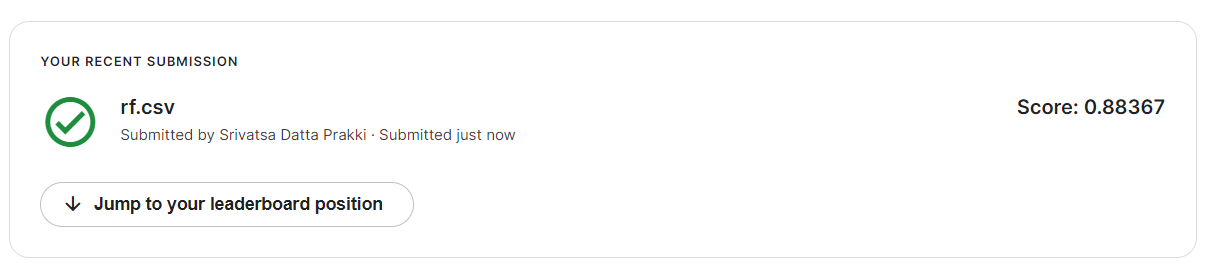

#### LightGBM

In [ ]:
lgbc=LGBMClassifier()

col = ['fullVisitorId','totals.transactionRevenue','returned']
grid={
    'learning_rate':[0.005,0.01,0.015,0.03,0.035,0.05],
     'n_estimators':[50,100,150,200],
    'num_leaves': [5,10,15],
    'objective':['binary'],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

search=RandomizedSearchCV(lgbc,grid,verbose=1,cv=3,n_jobs=-2,random_state=3,scoring='neg_log_loss')
result = search.fit(data.drop(col,axis=1),data['returned'])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-0.41458576243133943
{'subsample': 1, 'objective': 'binary', 'num_leaves': 5, 'n_estimators': 200, 'learning_rate': 0.05, 'colsample_bytree': 1}


In [ ]:
lgbr = LGBMRegressor()

col = ['fullVisitorId','totals.transactionRevenue','returned']

grid={
    'learning_rate':[0.005,0.01,0.015,0.03,0.035,0.05],
     'n_estimators':[50,100,150,200],
    'num_leaves': [5,10,15],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

search=RandomizedSearchCV(lgbr,grid,verbose=1,cv=3,n_jobs=-2,random_state=3,scoring='neg_root_mean_squared_error')
result = search.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-3.955793419600308
{'subsample': 0.3, 'num_leaves': 5, 'n_estimators': 100, 'learning_rate': 0.03, 'colsample_bytree': 1}


In [ ]:
col_tes = ['fullVisitorId','date_max','date_min']
col = ['fullVisitorId','totals.transactionRevenue','returned']

classification = LGBMClassifier(n_estimators=200,subsample=1,num_leaves=5,learning_rate=0.05,colsample_bytree=1,n_jobs=-1)
reg = LGBMRegressor(n_estimators=100,subsample=0.3,learning_rate=0.03,num_leaves=5,colsample_bytree=1,n_jobs=-1)

classification.fit(data.drop(col,axis=1),data['returned'])
reg.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

class_res = classification.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = reg.predict(test_lab.drop(col_tes, axis=1))
pred=class_res[:,1]*reg_res

df1 = pd.DataFrame()
df1['fullVisitorId'] = test_lab['fullVisitorId']
df1['PredictedLogRevenue'] = pred

val = pd.merge(df1,test_val,left_on='fullVisitorId',right_on='fullVisitorId')
print('RMSE: ',np.sqrt(mean_squared_error(val['totals.transactionRevenue'],val['PredictedLogRevenue'])))

RMSE:  2.06825725607099


In [ ]:
df1.to_csv('lg_sk.csv',index=False)

Kaggle Score: 0.88375

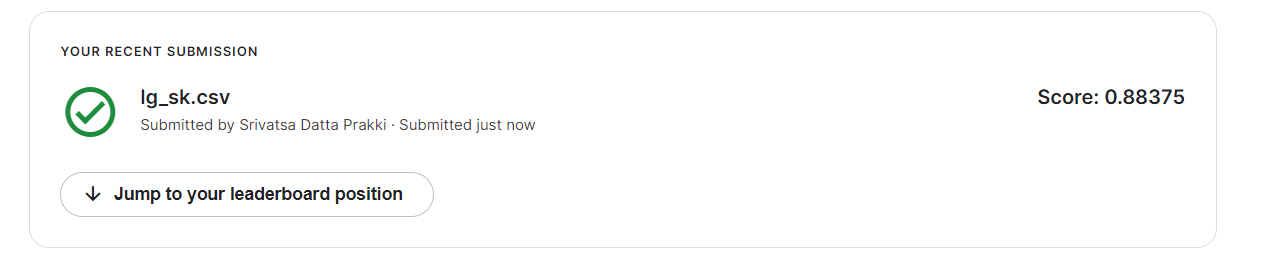

### Stacking

In [ ]:
col_tes = ['fullVisitorId','date_max','date_min']
col = ['fullVisitorId','totals.transactionRevenue','returned']

cmodels = [('dt',DecisionTreeClassifier(splitter='best',min_weight_fraction_leaf=0.1,min_samples_leaf=7,max_leaf_nodes=70,
                                        max_features='log2',max_depth=11)),
           ('lgb',LGBMClassifier(n_estimators=200,subsample=1,num_leaves=5,learning_rate=0.05,colsample_bytree=1))]

rmodels = [('dtr',DecisionTreeRegressor(splitter='best',min_weight_fraction_leaf=0.1,min_samples_leaf=7,max_leaf_nodes=70,
                            max_features='log2',max_depth=11)),
           ('lgbr',LGBMRegressor(n_estimators=100,subsample=0.3,learning_rate=0.03,num_leaves=5,colsample_bytree=1))]

cstack = StackingClassifier(estimators=cmodels, 
                            final_estimator=RandomForestClassifier(n_estimators=500,min_samples_split=5,
                                                                   min_samples_leaf=2,max_depth=10))
rstack = StackingRegressor(estimators=rmodels, 
                           final_estimator=RandomForestRegressor(n_estimators=500,min_samples_split=2,
                                                                 min_samples_leaf=3,max_depth=5))

cstack.fit(data.drop(col,axis=1),data['returned'])
rstack.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

class_res = cstack.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = rstack.predict(test_lab.drop(col_tes, axis=1))
pred = class_res[:,1]*reg_res

df1 = pd.DataFrame()
df1['fullVisitorId'] = test_lab['fullVisitorId']
df1['PredictedLogRevenue'] = pred

val = pd.merge(df1,test_val,left_on='fullVisitorId',right_on='fullVisitorId')
print('RMSE: ',np.sqrt(mean_squared_error(val['totals.transactionRevenue'],val['PredictedLogRevenue'])))

RMSE:  2.058549128084132


In [ ]:
df1.to_csv('stack.csv',index=False)

Kaggle Score: 0.88383

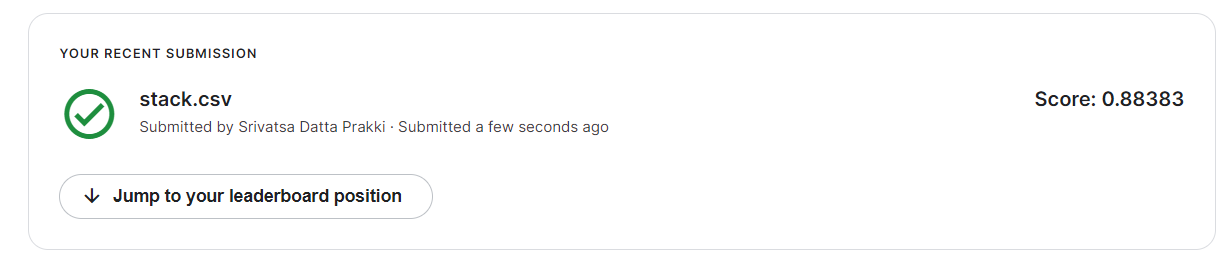

In [ ]:
col_tes = ['fullVisitorId','date_max','date_min']
col = ['fullVisitorId','totals.transactionRevenue','returned']

cmodels = [('dt',DecisionTreeClassifier(splitter='best',min_weight_fraction_leaf=0.2,min_samples_leaf=10,max_leaf_nodes=10,
                                        max_features='sqrt',max_depth=7)),
           ('rf',RandomForestClassifier(n_estimators=500,min_samples_split=5,
                                                                   min_samples_leaf=2,max_depth=10)),
           ('lgb',LGBMClassifier(n_estimators=200,subsample=1,learning_rate=0.05,num_leaves=5,colsample_bytree=1))
          ]

rmodels = [('dtr',DecisionTreeRegressor(splitter='best',min_weight_fraction_leaf=0.2,min_samples_leaf=10,max_leaf_nodes=10,
                                       max_features='sqrt',max_depth=7)),
           ('rfr',RandomForestRegressor(n_estimators=500,min_samples_split=2,
                                                                 min_samples_leaf=3,max_depth=5)),
           ('lgbr',LGBMRegressor(n_estimators=200,subsample=1,learning_rate=0.05,num_leaves=5,colsample_bytree=1))]

cstack = StackingClassifier(estimators=cmodels, 
                            final_estimator=LogisticRegression())
rstack = StackingRegressor(estimators=rmodels, 
                           final_estimator=LinearRegression())

cstack.fit(data.drop(col,axis=1),data['returned'])
rstack.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

class_res = cstack.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = rstack.predict(test_lab.drop(col_tes, axis=1))
pred = class_res[:,1]*reg_res

df1 = pd.DataFrame()
df1['fullVisitorId'] = test_lab['fullVisitorId']
df1['PredictedLogRevenue'] = pred

val = pd.merge(df1,test_val,left_on='fullVisitorId',right_on='fullVisitorId')
print('RMSE: ',np.sqrt(mean_squared_error(val['totals.transactionRevenue'],val['PredictedLogRevenue'])))

RMSE:  2.1073553745105293


In [ ]:
df1.to_csv('stack_v2.csv',index=False)

Kaggle Score: 0.88443

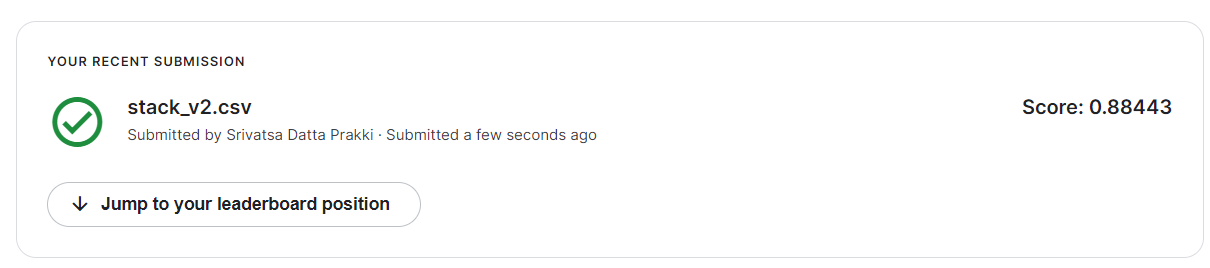

### One Hot Encoding

    Although LabelEncoding seem to work for the winner and others who tried this, but the main problem with Label Encoding  is it introduces ordinality to the data which in columns like country or region is not the correct way.
    Therefore We will be trying One-Hot-Encoding, which poses the problem of increasing the dimmensionality. To tackle this we will try to get columns into a max of 5 to 10 categories. We will check the contribution made by each category to the total revenue, and keep top 5 to 10 most contributing and smaller ones we will combine into 1

In [ ]:
import pandas as pd
import datetime

In [ ]:
df_train = pd.read_csv('train_v3.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)
df_test = pd.read_csv('test_v3.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)

In [ ]:
cats= {}
df = df_train.copy()
for i in df_train.columns:
    if df_train[i].dtype =='O' and i not in ['date','fullVisitorId'] and df_train[i].nunique() > 10:
        df1 = df.groupby(i).agg({'totals.transactionRevenue':'sum'}).reset_index()
        df1 = df1.sort_values(by='totals.transactionRevenue',ascending=False).reset_index().drop(['index'],axis=1)
        df1['totals.transactionRevenue'] = df1['totals.transactionRevenue']/sum(df1['totals.transactionRevenue'])
        sum1 = 0
        for j in range(len(df1)):
            sum1 += df1['totals.transactionRevenue'][j]
            if sum1 >= 0.9:
                print(i,'needs',j+1,'categories to get >90% of revenue')
                cats[i]=list(df1[i][0:j+1])
                break
        if j+1 > 10:
            print(i,'with',10,'categories gets',sum(df1['totals.transactionRevenue'][0:10])*100,'% revenue')
            cats[i]=list(df1[i][0:10])

device.browser needs 2 categories to get >90% of revenue
device.operatingSystem needs 3 categories to get >90% of revenue
geoNetwork.subContinent needs 1 categories to get >90% of revenue
geoNetwork.country needs 1 categories to get >90% of revenue
geoNetwork.region needs 8 categories to get >90% of revenue
geoNetwork.metro needs 8 categories to get >90% of revenue
geoNetwork.city needs 18 categories to get >90% of revenue
geoNetwork.city with 10 categories gets 78.52807313119577 % revenue
geoNetwork.networkDomain needs 91 categories to get >90% of revenue
geoNetwork.networkDomain with 10 categories gets 67.79906655030207 % revenue
trafficSource.campaign needs 2 categories to get >90% of revenue
trafficSource.source needs 2 categories to get >90% of revenue
trafficSource.keyword needs 1 categories to get >90% of revenue
trafficSource.referralPath needs 2 categories to get >90% of revenue


In [ ]:
for i in df_train.columns:
    if df_train[i].dtype =='O' and i not in ['date','fullVisitorId'] and df_train[i].nunique() > 10:
        df_train.loc[~df_train[i].isin(cats[i]),i] = 'Combined Others'
        df_test.loc[~df_test[i].isin(cats[i]),i] = 'Combined Others'

In [ ]:
for i in df_train.columns:
    if df_train[i].dtype =='O' and i not in ['date','fullVisitorId']:
        dum_tr = pd.get_dummies(df_train[i])
        dum_te = pd.get_dummies(df_test[i])
        
        if 'Combined Others' in dum_tr.columns:
            dum_tr.drop('Combined Others',axis=1,inplace=True)
        
        if 'Combined Others' in dum_te.columns:
            dum_te.drop('Combined Others',axis=1,inplace=True)
            
        dum_tr.columns = [i+'.'+j for j in dum_tr.columns]
        dum_te.columns = [i+'.'+j for j in dum_te.columns]
                 
        df_train = pd.concat([df_train,dum_tr],axis=1)
        df_train.drop(i,axis=1,inplace=True)
        
        df_test = pd.concat([df_test,dum_te],axis=1)
        df_test.drop(i,axis=1,inplace=True)
        
        if list(dum_tr) != list(dum_te):
            for j in (set(list(dum_tr)) - set(list(dum_te))):
                df_test[j] = [0]*len(df_test)

In [ ]:
df_train.to_csv('train_onehot.csv')
df_test.to_csv('test_onehot.csv')

In [ ]:
#Column aggregation idea
col_agg = {}
col_fin = ['fullVisitorId']
n_cols = ['visitId','visitStartTime','totals.transactionRevenue']
for i in df_train.columns:
    if i =='date':
        col_agg[i] = {'max','min'}
        col_fin.append(i+'_max')
        col_fin.append(i+'_min')
    
    elif i == 'device.isMobile':
        col_agg[i]={'max','count'}
        col_fin.append(i+'_count')
        col_fin.append(i+'_max')
    
    elif i not in n_cols and df_train[i].dtype == 'int64':
        col_agg[i]={'max','min','mean','sum'}
        col_fin.append(i+'_max')
        col_fin.append(i+'_min')
        col_fin.append(i+'_mean')
        col_fin.append(i+'_sum')
    
    elif i not in n_cols and df_train[i].dtype == 'float64':
        col_agg[i]={'max','min','mean','sum'}
        col_fin.append(i+'_max')
        col_fin.append(i+'_min')
        col_fin.append(i+'_mean')
        col_fin.append(i+'_sum')
    
    elif df_train[i].dtype=='uint8':
        col_agg[i]='mean'
        col_fin.append(i)
        
print(len(col_fin))

109


In [ ]:
def create_dataset(df,train_sdate,train_edate,test_sdate,test_edate,col_agg,col,train=True):
    
    if train:
        train = df.loc[(df['date']>=train_sdate) & (df['date']<=train_edate)].reset_index().drop('index',axis=1)
        test = df.loc[(df['date']>=test_sdate) & (df['date']<=test_edate)].reset_index().drop('index',axis=1)

        train_min = datetime.datetime.strptime(min(train['date']),'%Y-%m-%d')
        train_max = datetime.datetime.strptime(max(train['date']),'%Y-%m-%d')

        ret_cust = test[test['fullVisitorId'].isin(set(train['fullVisitorId']) & set(test['fullVisitorId']))]
        ret_cust_rev = ret_cust.groupby('fullVisitorId').agg({'totals.transactionRevenue':'sum'}).reset_index()
        ret_cust_rev['returned'] = 1

        non_ret = pd.DataFrame()
        non_ret['fullVisitorId'] = list(set(train['fullVisitorId']) - set(test['fullVisitorId']))
        non_ret['totals.transactionRevenue'] = 0.0
        non_ret['returned'] = 0

        df = pd.concat([ret_cust_rev, non_ret], ignore_index=True)

        df_group = train.groupby('fullVisitorId').agg(col_agg).reset_index()
        df_group.columns=col

        df_fin = pd.merge(df_group,df,how='left',left_on='fullVisitorId',right_on='fullVisitorId')

        first = []
        last  = []
        for i in range(0,len(df_fin)):
            x = (datetime.datetime.strptime(df_fin['date_min'][i],'%Y-%m-%d') - train_min).days 
            # number of days between start of session and his first arrival
            first.append(x)

            x = (train_max - datetime.datetime.strptime(df_fin['date_max'][i],'%Y-%m-%d')).days 
            # number of days from last day of period to his last session
            last.append(x)

        df_fin['first_arrival'] = first
        df_fin['last_arrival'] = last


        return df_fin
    else:
        test_min = datetime.datetime.strptime(min(df['date']),'%Y-%m-%d')
        test_max = datetime.datetime.strptime(max(df['date']),'%Y-%m-%d')
        
        df_group = df.groupby('fullVisitorId').agg(col_agg).reset_index()
        df_group.columns=col
        
        first = []
        last  = []
        for i in range(0,len(df_group)):
            x = (datetime.datetime.strptime(df_group['date_min'][i],'%Y-%m-%d') - test_min).days 
            # number of days between start of session and his first arrival
            first.append(x)

            x = (test_max - datetime.datetime.strptime(df_group['date_max'][i],'%Y-%m-%d')).days 
            # number of days from last day of period to his last session
            last.append(x)

        df_group['first_arrival'] = first
        df_group['last_arrival'] = last
        
        return df_group

In [ ]:
df_train_test = pd.concat([df_train, df_test], ignore_index=True)
df_train_test.shape

(2109926, 86)

In [ ]:
%time df1 = create_dataset(df_train_test,'2016-08-01','2017-01-15','2017-03-02','2017-05-03',col_agg,col_fin)

CPU times: user 1min 15s, sys: 1.51 s, total: 1min 17s
Wall time: 1min 16s


In [ ]:
%time df2 = create_dataset(df_train_test,'2017-01-16','2017-07-02','2017-08-17','2017-10-18',col_agg,col_fin)

CPU times: user 57.7 s, sys: 669 ms, total: 58.3 s
Wall time: 57.7 s


In [ ]:
%time df3 = create_dataset(df_train_test,'2017-07-03','2017-12-17','2018-02-01','2018-04-04',col_agg,col_fin)

CPU times: user 1min 17s, sys: 1.04 s, total: 1min 18s
Wall time: 1min 17s


In [ ]:
%time df4 = create_dataset(df_train_test,'2017-12-18','2018-06-03','2018-07-19','2018-09-19',col_agg,col_fin)

CPU times: user 1min 14s, sys: 1.17 s, total: 1min 16s
Wall time: 1min 14s


In [ ]:
df_final = pd.concat([df1,df2,df3,df4], ignore_index=True)
df_final.shape

(1417575, 113)

In [ ]:
df_final.to_csv('onehot_final.csv')

In [ ]:
df_test = pd.read_csv('test_onehot.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)
df_test.head()

date        fullVisitorId     visitId  visitNumber  visitStartTime  \
0  2018-05-11  7460955084541987166  1526099341            2      1526099341   
1  2018-05-11   460252456180441002  1526064483          166      1526064483   
2  2018-05-11  3461808543879602873  1526067157            2      1526067157   
3  2018-05-11   975129477712150630  1526107551            4      1526107551   
4  2018-05-11  8381672768065729990  1526060254            1      1526060254   

   device.isMobile  totals.hits  totals.pageviews  totals.timeOnSite  \
0             True            4               3.0              973.0   
1            False            4               3.0               49.0   
2            False            4               3.0               24.0   
3             True            5               4.0               25.0   
4             True            5               4.0               49.0   

   totals.sessionQualityDim  ...  trafficSource.source.(direct)  \
0                         1  ...                              0   
1                         1  ...                              1   
2                         1  ...                              0   
3                         1  ...                              1   
4                         1  ...                              0   

   trafficSource.source.google  trafficSource.medium.affiliate  \
0                            1                               0   
1                            0                               0   
2                            1                               0   
3                            0                               0   
4                            1                               0   

   trafficSource.medium.cpc  trafficSource.medium.cpm  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   trafficSource.medium.organic  trafficSource.medium.referral  \
0                             1                              0   
1                             0                              0   
2                             1                              0   
3                             0                              0   
4                             1                              0   

   trafficSource.keyword.other  trafficSource.referralPath./  \
0                            1                             0   
1                            0                             0   
2                            1                             0   
3                            0                             0   
4                            1                             0   

   trafficSource.referralPath.miss  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  

[5 rows x 86 columns]

In [ ]:
%time df_te_lb = create_dataset(df_test,0,0,0,0,col_agg,col_fin,False)

Wall time: 57.6 s


In [ ]:
df_te_lb.to_csv('test_onehot_final.csv')

### Handling Imbalance

In [ ]:
import pandas as pd
import numpy as np
import random

In [ ]:
data = pd.read_csv('onehot_final.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)
data['totals.transactionRevenue'] = np.log1p(data['totals.transactionRevenue'])
data.head()

fullVisitorId    date_max    date_min  visitNumber_max  \
0  0000010278554503158  2016-10-20  2016-10-20                1   
1  0000020424342248747  2016-11-30  2016-11-30                1   
2   000005103959234087  2016-08-21  2016-08-21                1   
3  0000093957001069502  2016-09-27  2016-09-27                1   
4  0000114156543135683  2016-08-08  2016-08-08                1   

   visitNumber_min  visitNumber_mean  visitNumber_sum  device.isMobile_count  \
0                1                 1              1.0                      1   
1                1                 1              1.0                      1   
2                1                 1              1.0                      1   
3                1                 1              1.0                      1   
4                1                 1              1.0                      1   

   device.isMobile_max  totals.hits_max  ...  trafficSource.medium.cpm  \
0                False               11  ...                       0.0   
1                False               17  ...                       0.0   
2                 True               10  ...                       0.0   
3                False                2  ...                       0.0   
4                False                1  ...                       0.0   

   trafficSource.medium.organic  trafficSource.medium.referral  \
0                           1.0                            0.0   
1                           0.0                            0.0   
2                           1.0                            0.0   
3                           0.0                            0.0   
4                           0.0                            1.0   

   trafficSource.keyword.other  trafficSource.referralPath./  \
0                          1.0                           0.0   
1                          1.0                           0.0   
2                          1.0                           0.0   
3                          1.0                           0.0   
4                          1.0                           0.0   

   trafficSource.referralPath.miss  totals.transactionRevenue  returned  \
0                              1.0                        0.0         0   
1                              1.0                        0.0         0   
2                              1.0                        0.0         0   
3                              1.0                        0.0         0   
4                              0.0                        0.0         0   

   first_arrival  last_arrival  
0             80            87  
1            121            46  
2             20           147  
3             57           110  
4              7           160  

[5 rows x 113 columns]

In [ ]:
data_ret = data[data['returned']==1]
data_nret = data[data['returned']==0]

a,b = divmod(len(data_nret),len(data_ret)) # returns number of times all rows to multiply(len(data_nret)//len(data_ret)) and 
                                           # number of times 1 row to multiply(len(data_nret)%len(data_ret))
df1 = np.repeat(data_ret.values,a,axis=0)
rows = random.sample(range(0,len(data_ret)),b)
df2 = np.repeat(data_ret.iloc[rows],1,axis=0)

df = pd.DataFrame(np.vstack((df1,df2)),columns=data_ret.columns)
df.shape

(1408691, 113)

In [ ]:
data_fin = data_nret.append(df,ignore_index=True)
data_fin.shape

(2817382, 113)

In [ ]:
data_fin.to_csv('onehot_bal_fin.csv')

## Modelling

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import SGDRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier,XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_csv('onehot_bal_fin.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)
data = data.sample(frac = 1, random_state=3).reset_index().drop(['index','date_max','date_min'],axis=1)
data.head()

fullVisitorId  visitNumber_max  visitNumber_min  visitNumber_mean  \
0  4371679763590286482                1                1                 1   
1  7750940405738849850                7                2                27   
2   233086844142012058                2                1                 3   
3  0126859910514144642                1                1                 1   
4  1083760617263662951                1                1                 1   

   visitNumber_sum  device.isMobile_count  device.isMobile_max  \
0              1.0                      1                False   
1              4.5                      6                False   
2              1.5                      2                False   
3              1.0                      1                False   
4              1.0                      1                False   

   totals.hits_max  totals.hits_min  totals.hits_mean  ...  \
0               39               39                39  ...   
1                4                1                10  ...   
2                1                1                 2  ...   
3                2                2                 2  ...   
4                8                8                 8  ...   

   trafficSource.medium.cpm  trafficSource.medium.organic  \
0                       0.0                      1.000000   
1                       0.0                      0.166667   
2                       0.0                      1.000000   
3                       0.0                      0.000000   
4                       0.0                      0.000000   

   trafficSource.medium.referral  trafficSource.keyword.other  \
0                       0.000000                          1.0   
1                       0.833333                          1.0   
2                       0.000000                          1.0   
3                       1.000000                          1.0   
4                       0.000000                          1.0   

   trafficSource.referralPath./  trafficSource.referralPath.miss  \
0                           0.0                         1.000000   
1                           0.0                         0.166667   
2                           0.0                         1.000000   
3                           0.0                         0.000000   
4                           0.0                         1.000000   

   totals.transactionRevenue  returned  first_arrival  last_arrival  
0                        0.0         1             94            73  
1                        0.0         1             28             4  
2                        0.0         0            149             7  
3                        0.0         0            146            21  
4                        0.0         0            114            53  

[5 rows x 111 columns]

In [ ]:
df = data.drop_duplicates('fullVisitorId')
len(df[df['returned']==1])

8103

In [ ]:
test_lab = pd.read_csv('test_onehot_final.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)
test = pd.read_csv('test_v3.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)

test_val = test.groupby('fullVisitorId').agg({'totals.transactionRevenue':'sum'})
test_val['totals.transactionRevenue'] = np.log1p(test_val['totals.transactionRevenue'])

#### Linear Model

In [ ]:
col = ['fullVisitorId','totals.transactionRevenue','returned']
grid = {'C':[10**i for i in range(-5,4)],'penalty':['l2', 'l1']}
lr = LogisticRegression()
search = RandomizedSearchCV(lr,grid,cv=3,verbose=2,n_jobs=-5,random_state=3,scoring='roc_auc')
result = search.fit(data.drop(col,axis=1),data['returned'])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8380307017218426
{'penalty': 'l2', 'C': 10}


In [ ]:
# Reffer for scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
grid = {'alpha':[10**i for i in range(-5,4)],'penalty':['l2', 'l1']}

reg_model = SGDRegressor(random_state=3,loss='squared_error')
search = RandomizedSearchCV(reg_model,grid,cv=3,verbose=1,n_jobs=-2,random_state=3,scoring = 'neg_root_mean_squared_error')
# result = search.fit(data.drop(col,axis=1)[data['returned']==1] ,data['totals.transactionRevenue'][data['returned']==1])
result = search.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-1490658912854868.5
{'penalty': 'l1', 'alpha': 0.1}


In [ ]:
col_tes = ['fullVisitorId','date_max','date_min']
col = ['fullVisitorId','totals.transactionRevenue','returned']

classification = LogisticRegression(penalty='l2',C=10)
reg = SGDRegressor(loss='squared_loss',penalty='l1',alpha=0.1)

classification.fit(data.drop(col,axis=1),data['returned'])
reg.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

class_res = classification.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = reg.predict(test_lab.drop(col_tes, axis=1))

df1 = pd.DataFrame()
df1['fullVisitorId'] = test_lab['fullVisitorId']
df1['PredictedLogRevenue'] = class_res[:,1]*reg_res

val = pd.merge(df1,test_val,left_on='fullVisitorId',right_on='fullVisitorId')
print('RMSE: ',np.sqrt(mean_squared_error(val['totals.transactionRevenue'],val['PredictedLogRevenue'])))

RMSE:  79654554141940.36


In [ ]:
df1.to_csv('linear_one.csv',index=False)

Got Kaggle Score: 79654554141939.9

##### Got Pretty Bad RMSE using Linear Model, Therefore we need More Bigger and Powerful Algorithms.

#### Decision Tree

In [ ]:
col = ['fullVisitorId','totals.transactionRevenue','returned']

grid = {"splitter":["best","random"],
        "max_depth" : [1,3,5,7,9,11,12],
        "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
        "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
        "max_features":["auto","log2","sqrt",None],
        "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] 
       }
dtc = DecisionTreeClassifier()
search = RandomizedSearchCV(dtc,grid,cv=3,verbose=2,n_jobs=-5,random_state=3,scoring='neg_log_loss')
result = search.fit(data.drop(col,axis=1),data['returned'])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-0.5721263493050462
{'splitter': 'best', 'min_weight_fraction_leaf': 0.2, 'min_samples_leaf': 10, 'max_leaf_nodes': 10, 'max_features': 'sqrt', 'max_depth': 7}


In [ ]:
grid = {"splitter":["best","random"],
        "max_depth" : [1,3,5,7,9,11,12],
        "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
        "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
        "max_features":["auto","log2","sqrt",None],
        "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] 
       }

dtr = DecisionTreeRegressor()

col = ['fullVisitorId','totals.transactionRevenue','returned']

search = RandomizedSearchCV(dtr,grid,cv=3,verbose=1,n_jobs=-5,random_state=3,scoring='neg_root_mean_squared_error')
result = search.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-4.109939188432881
{'splitter': 'best', 'min_weight_fraction_leaf': 0.2, 'min_samples_leaf': 10, 'max_leaf_nodes': 10, 'max_features': 'sqrt', 'max_depth': 7}


In [ ]:
col_tes = ['fullVisitorId','date_max','date_min']
col = ['fullVisitorId','totals.transactionRevenue','returned']

classification = DecisionTreeClassifier(splitter='best',min_weight_fraction_leaf=0.2,min_samples_leaf=10,max_leaf_nodes=10,
                            max_features='sqrt',max_depth=7)

reg = DecisionTreeRegressor(splitter='best',min_weight_fraction_leaf=0.2,min_samples_leaf=10,max_leaf_nodes=10,
                            max_features='sqrt',max_depth=7)

classification.fit(data.drop(col,axis=1),data['returned'])
reg.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

class_res = classification.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = reg.predict(test_lab.drop(col_tes, axis=1))

class_res = classification.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = reg.predict(test_lab.drop(col_tes, axis=1))
pred=class_res[:,1]*reg_res

df1 = pd.DataFrame()
df1['fullVisitorId'] = test_lab['fullVisitorId']
df1['PredictedLogRevenue'] = pred

val = pd.merge(df1,test_val,left_on='fullVisitorId',right_on='fullVisitorId')
print('RMSE: ',np.sqrt(mean_squared_error(val['totals.transactionRevenue'],val['PredictedLogRevenue'])))

RMSE:  2.0910420483763543


In [ ]:
df1.to_csv('dt_one.csv',index=False)

Got Kaggle Score: 0.88817

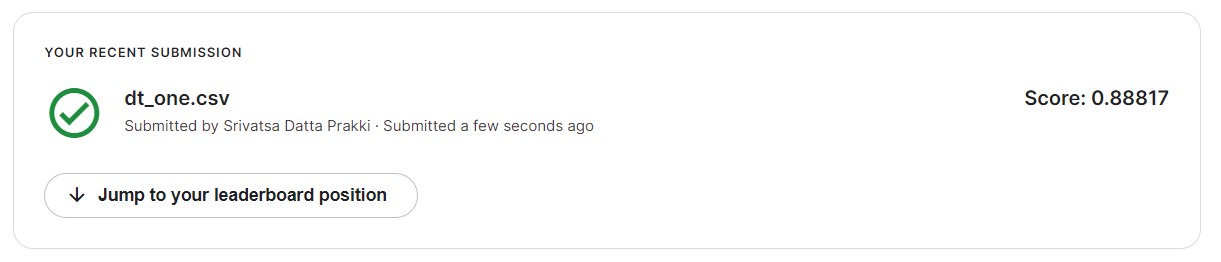

#### Random Forest

In [ ]:
## https://stackoverflow.com/questions/53782169/random-forest-tuning-with-randomizedsearchcv
grid = {'n_estimators':[100,200,300,500,700,800],
        'max_depth':[2,3,5,7,8,9,10],
        'min_samples_split':[2,3,5,7],
        'min_samples_leaf':[1,2,3,4]
       }

rfc = RandomForestClassifier()

col = ['fullVisitorId','totals.transactionRevenue','returned']

search = RandomizedSearchCV(rfc,grid,cv=3,verbose=1,n_jobs=-5,random_state=3,scoring='neg_log_loss')
result = search.fit(data.drop(col,axis=1),data['returned'])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-0.39127669992450476
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}


In [ ]:
grid = {'n_estimators':[100,200,300,500,700,800],
        'max_depth':[2,3,5,7,8,9,10],
        'min_samples_split':[2,3,5,7],
        'min_samples_leaf':[1,2,3,4]
       }

rfr = RandomForestRegressor()

col = ['fullVisitorId','totals.transactionRevenue','returned']

search = RandomizedSearchCV(rfr,grid,cv=3,verbose=1,n_jobs=-5,random_state=3,scoring='neg_root_mean_squared_error')
result = search.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-3.9394191700762526
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}


In [ ]:
col_tes = ['fullVisitorId','date_max','date_min']
col = ['fullVisitorId','totals.transactionRevenue','returned']

classification = RandomForestClassifier(n_estimators=500,min_samples_split=5,min_samples_leaf=2,max_depth=10,n_jobs=-1)
reg = RandomForestRegressor(n_estimators=500,min_samples_split=2,min_samples_leaf=3,max_depth=5,n_jobs=-1)

classification.fit(data.drop(col,axis=1),data['returned'])
reg.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

class_res = classification.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = reg.predict(test_lab.drop(col_tes, axis=1))

df = pd.DataFrame()
df['fullVisitorId'] = test_lab['fullVisitorId']
df['PredictedLogRevenue'] = class_res[:,1]*reg_res

val = pd.merge(df,test_val,left_on='fullVisitorId',right_on='fullVisitorId')
print('RMSE: ',np.sqrt(mean_squared_error(val['totals.transactionRevenue'],val['PredictedLogRevenue'])))

RMSE:  2.080613430602507


In [ ]:
df.to_csv('rf_one.csv',index=False)

Kaggle Score: 0.88259

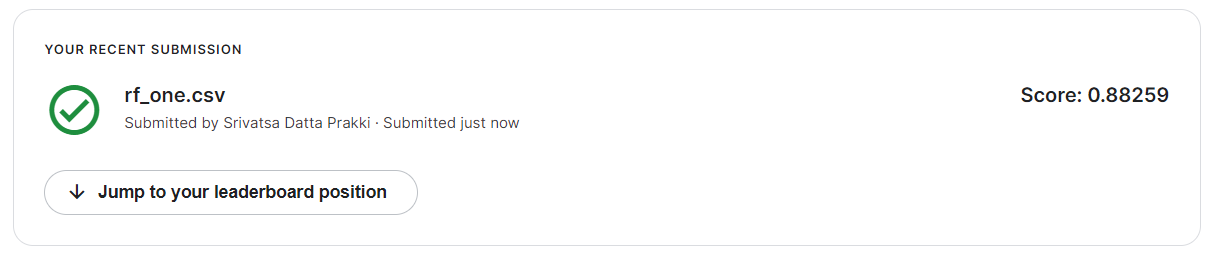

#### LightGBM

In [ ]:
lgbc=LGBMClassifier()

col = ['fullVisitorId','totals.transactionRevenue','returned']
grid={
    'learning_rate':[0.005,0.01,0.015,0.03,0.035,0.05],
     'n_estimators':[50,100,150,200],
    'num_leaves': [5,10,15],
    'objective':['binary'],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

search=RandomizedSearchCV(lgbc,grid,verbose=1,cv=3,n_jobs=-5,random_state=3,scoring='neg_log_loss')
result = search.fit(data.drop(col,axis=1),data['returned'])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-0.41817972296872874
{'subsample': 1, 'objective': 'binary', 'num_leaves': 5, 'n_estimators': 200, 'learning_rate': 0.05, 'colsample_bytree': 1}


In [ ]:
lgbr = LGBMRegressor()

col = ['fullVisitorId','totals.transactionRevenue','returned']

grid={
    'learning_rate':[0.005,0.01,0.015,0.03,0.035,0.05],
     'n_estimators':[50,100,150,200],
    'num_leaves': [5,10,15],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

search=RandomizedSearchCV(lgbr,grid,verbose=1,cv=3,n_jobs=-5,random_state=3,scoring='neg_root_mean_squared_error')
result = search.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

print(result.best_score_)
print(result.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
-3.93961376238923
{'subsample': 1, 'num_leaves': 5, 'n_estimators': 200, 'learning_rate': 0.05, 'colsample_bytree': 1}


In [ ]:
col_tes = ['fullVisitorId','date_max','date_min']
col = ['fullVisitorId','totals.transactionRevenue','returned']

classification = LGBMClassifier(n_estimators=200,subsample=1,learning_rate=0.05,num_leaves=5,colsample_bytree=1,n_jobs=-1)
reg = LGBMRegressor(n_estimators=200,subsample=1,learning_rate=0.05,num_leaves=5,colsample_bytree=1,n_jobs=-1)


classification.fit(data.drop(col,axis=1),data['returned'])
reg.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])
class_res = classification.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = reg.predict(test_lab.drop(col_tes, axis=1))
pred = class_res[:,1]*reg_res

df1 = pd.DataFrame()
df1['fullVisitorId'] = test_lab['fullVisitorId']
df1['PredictedLogRevenue'] = pred

val = pd.merge(df1,test_val,left_on='fullVisitorId',right_on='fullVisitorId')
print('RMSE: ',np.sqrt(mean_squared_error(val['totals.transactionRevenue'],val['PredictedLogRevenue'])))

RMSE:  2.071752338058492


In [ ]:
df1.to_csv('lg_one_sk.csv',index=False)

Kaggle Score:  0.88303

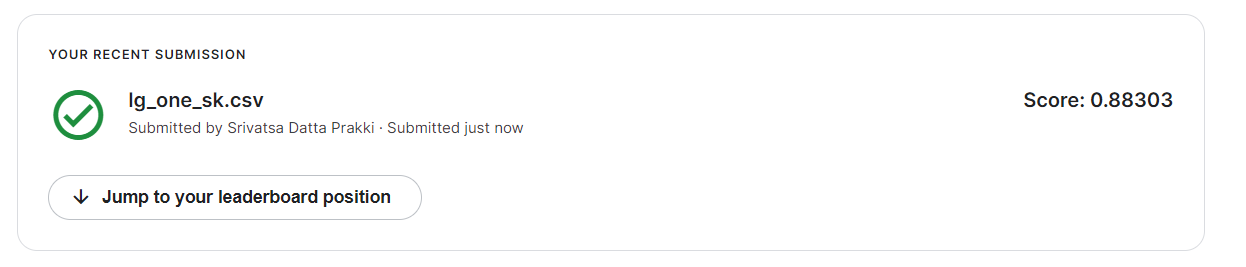

### Stacking

In [ ]:
col_tes = ['fullVisitorId','date_max','date_min']
col = ['fullVisitorId','totals.transactionRevenue','returned']

cmodels = [('dt',DecisionTreeClassifier(splitter='best',min_weight_fraction_leaf=0.2,min_samples_leaf=10,max_leaf_nodes=10,
                                        max_features='sqrt',max_depth=7)),
           ('lgb',LGBMClassifier(n_estimators=200,subsample=1,learning_rate=0.05,num_leaves=5,colsample_bytree=1))]

rmodels = [('dtr',DecisionTreeRegressor(splitter='best',min_weight_fraction_leaf=0.2,min_samples_leaf=10,max_leaf_nodes=10,
                                       max_features='sqrt',max_depth=7)),
           ('lgbr',LGBMRegressor(n_estimators=200,subsample=1,learning_rate=0.05,num_leaves=5,colsample_bytree=1))]

cstack = StackingClassifier(estimators=cmodels, 
                            final_estimator=RandomForestClassifier(n_estimators=500,min_samples_split=5,
                                                                   min_samples_leaf=2,max_depth=10))
rstack = StackingRegressor(estimators=rmodels, 
                           final_estimator=RandomForestRegressor(n_estimators=500,min_samples_split=2,
                                                                 min_samples_leaf=3,max_depth=5))

cstack.fit(data.drop(col,axis=1),data['returned'])
rstack.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

class_res = cstack.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = rstack.predict(test_lab.drop(col_tes, axis=1))
pred = class_res[:,1]*reg_res

df1 = pd.DataFrame()
df1['fullVisitorId'] = test_lab['fullVisitorId']
df1['PredictedLogRevenue'] = pred

val = pd.merge(df1,test_val,left_on='fullVisitorId',right_on='fullVisitorId')
print('RMSE: ',np.sqrt(mean_squared_error(val['totals.transactionRevenue'],val['PredictedLogRevenue'])))

RMSE:  2.071865996663456


In [ ]:
df1.to_csv('stack_one.csv',index=False)

Kaggle Score: 0.88316

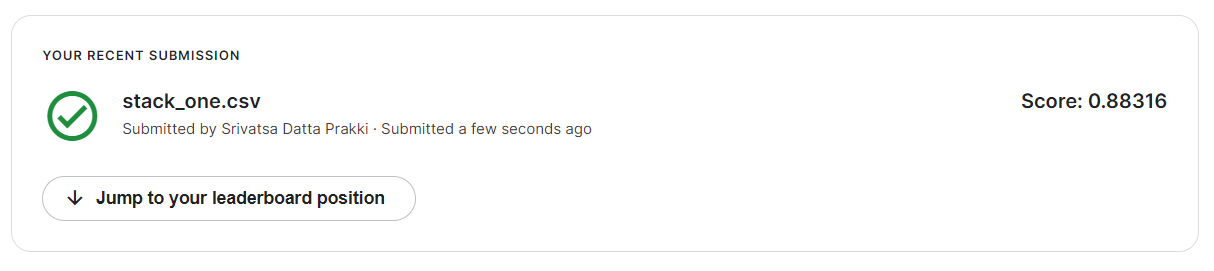

In [ ]:
col_tes = ['fullVisitorId','date_max','date_min']
col = ['fullVisitorId','totals.transactionRevenue','returned']

cmodels = [('dt',DecisionTreeClassifier(splitter='best',min_weight_fraction_leaf=0.2,min_samples_leaf=10,max_leaf_nodes=10,
                                        max_features='sqrt',max_depth=7)),
           ('rf',RandomForestClassifier(n_estimators=500,min_samples_split=5,
                                                                   min_samples_leaf=2,max_depth=10)),
           ('lgb',LGBMClassifier(n_estimators=200,subsample=1,learning_rate=0.05,num_leaves=5,colsample_bytree=1))
          ]

rmodels = [('dtr',DecisionTreeRegressor(splitter='best',min_weight_fraction_leaf=0.2,min_samples_leaf=10,max_leaf_nodes=10,
                                       max_features='sqrt',max_depth=7)),
           ('rfr',RandomForestRegressor(n_estimators=500,min_samples_split=2,
                                                                 min_samples_leaf=3,max_depth=5)),
           ('lgbr',LGBMRegressor(n_estimators=200,subsample=1,learning_rate=0.05,num_leaves=5,colsample_bytree=1))]

cstack = StackingClassifier(estimators=cmodels, 
                            final_estimator=LogisticRegression())
rstack = StackingRegressor(estimators=rmodels, 
                           final_estimator=LinearRegression())

cstack.fit(data.drop(col,axis=1),data['returned'])
rstack.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

class_res = cstack.predict_proba(test_lab.drop(col_tes, axis=1))
reg_res = rstack.predict(test_lab.drop(col_tes, axis=1))
pred = class_res[:,1]*reg_res

df1 = pd.DataFrame()
df1['fullVisitorId'] = test_lab['fullVisitorId']
df1['PredictedLogRevenue'] = pred

val = pd.merge(df1,test_val,left_on='fullVisitorId',right_on='fullVisitorId')
print('RMSE: ',np.sqrt(mean_squared_error(val['totals.transactionRevenue'],val['PredictedLogRevenue'])))

RMSE:  2.078615174526575


In [ ]:
df1.to_csv('stack_one_v2.csv',index=False)

Kaggle Score: 0.88310

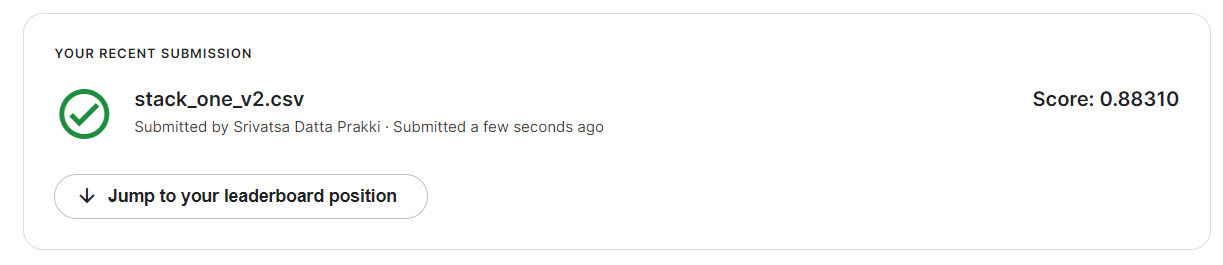

## Summary

In [2]:
from prettytable import PrettyTable

tab = PrettyTable(['Encoding','Model','Test RMSE','Kaggle Score','Possible Kaggle Rank'])
tab.add_row(['Label Encoding','Linear',2.949197197245644e+16,29491971972456600,'Last'])
tab.add_row(['Label Encoding','Decision Tree',2.0837279689789248,0.88654,68])
tab.add_row(['Label Encoding','Random Forest',2.083695534435819,0.88367,9])
tab.add_row(['Label Encoding','LightGBM',2.06825725607099,0.88375,11])
tab.add_row(['Label Encoding','Stacking(Base:DT,LGBM Meta:RF)',2.058549128084132,0.88383,13])
tab.add_row(['Label Encoding','Stacking(Base:DT,RF,LGBM Meta:Linear)',2.1073553745105293,0.88443,18])
tab.add_row([' ',' ',' ',' ',''])
tab.add_row(['OneHot Encoding','Linear',6723168741294065.0,6723168741293980,'Last'])
tab.add_row(['OneHot Encoding','Decision Tree',2.0910420483763543,0.88817,130])
tab.add_row(['OneHot Encoding','Random Forest',2.080613430602507,0.88259,3])
tab.add_row(['OneHot Encoding','LightGBM',2.071752338058492,0.88303,6])
tab.add_row(['OneHot Encoding','Stacking(Base:DT,LGBM Meta:RF)',2.071865996663456,0.88316,6])
tab.add_row(['OneHot Encoding','Stacking(Base:DT,RF,LGBM Meta:Linear)',2.078615174526575,0.88310,6])

print(tab)

+-----------------+---------------------------------------+-----------------------+-------------------+----------------------+
|     Encoding    |                 Model                 |       Test RMSE       |    Kaggle Score   | Possible Kaggle Rank |
+-----------------+---------------------------------------+-----------------------+-------------------+----------------------+
|  Label Encoding |                 Linear                | 2.949197197245644e+16 | 29491971972456600 |         Last         |
|  Label Encoding |             Decision Tree             |   2.0837279689789248  |      0.88654      |          68          |
|  Label Encoding |             Random Forest             |   2.083695534435819   |      0.88367      |          9           |
|  Label Encoding |                LightGBM               |    2.06825725607099   |      0.88375      |          11          |
|  Label Encoding |     Stacking(Base:DT,LGBM Meta:RF)    |   2.058549128084132   |      0.88383      |        